In [2]:
from helper_funcs import *

# Colourblind friendly colours
import tol_colors as tc
cset = tc.tol_cset('bright')
plt.rc('axes', prop_cycle=plt.cycler('color', list(cset)))

blue_tol = [
    '#4477AA',
    '#6d99c5',
    '#9ebbd8',
]

fsize = 24
plt.rcParams.update({'font.size': fsize})


dynamics_path = '../publication/dynamics/'
static_path = '../publication/static_tests/'

tmap = {
    'npt_000conEC_298K':'EMC (298$\,$K)',
    'npt_033conEC_298K':'EC:EMC (3:7) (298$\,$K)',
    'npt_066conEC_298K':'EC:EMC (7:3) (298$\,$K)',
    'npt_100conEC_313K':'EC (313$\,$K)',
}

conmap = {
    '000conEC':'EMC (298$\,$K)',
    '033conEC':'EC:EMC (3:7) (298$\,$K)',
    '066conEC':'EC:EMC (7:3) (298$\,$K)',
    '100conEC':'EC (313$\,$K)',
}

tmap = {
    'npt_000conEC_298K':'EMC',
    'npt_033conEC_298K':'EC:EMC',
    'npt_066conEC_298K':'EC:EMC (7:3)',
    'npt_100conEC_313K':'EC',
    'npt_000conEC_300K':'EMC',
    'npt_033conEC_300K':'EC:EMC (3:7)',
    'npt_066conEC_300K':'EC:EMC (7:3)',
    'npt_100conEC_300K':'EC',
}

conmap = {
    '000conEC':'EMC',
    '033conEC':'EC:EMC (3:7)',
    '066conEC':'EC:EMC (7:3)',
    '100conEC':'EC',
}

In [3]:
tags = [
    'SDN22NQQ/wB97X/SEED1/DSET1',
    'SDN22NQQ/wB97X/SEED1/DSET2',
    'SDN22NQQ/wB97X/SEED1/DSET3',
    'SDN22NQQ/wB97X/SEED2/DSET1',
    'SDN22NQQ/wB97X/SEED3/DSET1',
    'SDN22NQ/wB97X/SEED1/DSET1',
    'SDN22NQ/wB97X/SEED1/DSET2',
    'SDN22NQ/wB97X/SEED1/DSET3',
    'SDN22NQ/wB97X/SEED2/DSET1',
    'SDN22NQ/wB97X/SEED3/DSET1',
    'SDN22N/wB97X/SEED1/DSET1',
    'SDN22N/wB97X/SEED2/DSET1',
    'SDN22N/wB97X/SEED3/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

In [4]:
import pickle

def get_mol_positions(atoms):
	positions = []
	mol_set = set(atoms.arrays['molID'])
	for ID in mol_set:
		mol = atoms[atoms.arrays['molID'] == ID]
		com = mol.get_center_of_mass()
		positions.append(com)
	positions = np.array(positions)
	return positions#, len(mol_set)

def mol_rdf(atoms, rmax, nbins, return_num_mols=False):
	positions = get_mol_positions(atoms)
	nmols, dim = positions.shape
	box_length = atoms.get_volume()**(1/3)
	for i, p in enumerate(positions):
		# PBC
		delta = positions[i+1:]-positions[i]
		delta -= box_length*np.round(delta/box_length)
		
		# Get counts
		dists = np.linalg.norm(delta, axis=1)
		s = sorted(dists[dists <= rmax])[1:]
		if i == 0:
			counts, bins = np.histogram(s, nbins, (0,rmax))
		else:
			counts += np.histogram(s, nbins, (0,rmax))[0]

	if return_num_mols:
		return counts, bins, nmols
	else:
		return counts, bins

def compute_rdf(traj, rmax=None, nbins=100, return_rho=False):
	for i, atoms in enumerate(traj):
		if i == 0:
			counts, bins, nmols = mol_rdf(atoms, rmax=rmax, nbins=nbins, return_num_mols=True)
			volume = atoms.get_volume()
			box_length = volume**(1/3)
			r = 0.5*(bins[1:]+bins[:-1])
		else:
			counts += mol_rdf(atoms, rmax=rmax, nbins=nbins)[0]
	
	num_snapshots = i+1
	nvalid = nmols/2
	n_k = counts/(nvalid*num_snapshots)	
	dr = rmax/nbins
	shell_volumes = 4/3*np.pi*((r+dr)**3-r**3)
	rho = nmols/volume
	
	g = n_k/(rho*shell_volumes)
	if return_rho:
		return g, r, rho
	else:
		return g, r

def get_indices_of_sign_change(lst):
    arr = np.array(lst)
    sign_changes = np.where(np.diff(np.sign(arr)) != 0)[0]
    #sign_changes = sign_changes[sign_changes>55] # The limit was taken from observation
    return sign_changes



def eval_rdfs(tags, traj_path, slice=':'):
    rdfs = {}
    number_densities = {}
    for tag in tags:
        data_set, functional, seed, dset_sample = tag.split('/')
        flist = [name for name in glob.glob(f'{traj_path}{tag}/*') if '.xyz' in name]
        name = f'{data_set}_{functional}'
        print(name, dset_sample, seed)

        for file in flist:
            print(file)
            comp = file.split('/')[-1].split('.')[0][4:-5]
            comp = conmap[comp]
            traj = read(file, slice)
            aa.find_molecs(traj, fct=1.0)
            g, r, rho = compute_rdf(traj, rmax=11, return_rho=True)

            if name not in rdfs:
                rdfs[name] = {}
            if dset_sample not in rdfs[name]:
                rdfs[name][dset_sample] = {}
            if seed not in rdfs[name][dset_sample]:
                rdfs[name][dset_sample][seed] = {}
            
            if name not in number_densities:
                number_densities[name] = {}
            if dset_sample not in number_densities[name]:
                number_densities[name][dset_sample] = {}
            if seed not in number_densities[name][dset_sample]:
                number_densities[name][dset_sample][seed] = {}

            rdfs[name][dset_sample][seed][comp] = [g, r]
            number_densities[name][dset_sample][seed][comp] = rho
            del traj
    
    return rdfs, number_densities



In [5]:
import pickle

def get_mol_positions(atoms):
	positions = []
	mol_set = set(atoms.arrays['molID'])
	for ID in mol_set:
		mol = atoms[atoms.arrays['molID'] == ID]
		com = mol.get_center_of_mass()
		positions.append(com)
	positions = np.array(positions)
	return positions#, len(mol_set)

def mol_rdf(atoms, rmax, nbins, return_num_mols=False):
	positions = get_mol_positions(atoms)
	nmols, dim = positions.shape
	box_length = atoms.get_volume()**(1/3)
	for i, p in enumerate(positions):
		# PBC
		delta = positions[i+1:]-positions[i]
		delta -= box_length*np.round(delta/box_length)
		
		# Get counts
		dists = np.linalg.norm(delta, axis=1)
		s = sorted(dists[dists <= rmax])[1:]
		if i == 0:
			counts, bins = np.histogram(s, nbins, (0,rmax))
		else:
			counts += np.histogram(s, nbins, (0,rmax))[0]

	if return_num_mols:
		return counts, bins, nmols
	else:
		return counts, bins

def compute_rdf(traj, rmax=None, nbins=100, return_rho=False):
	for i, atoms in enumerate(traj):
		if i == 0:
			counts, bins, nmols = mol_rdf(atoms, rmax=rmax, nbins=nbins, return_num_mols=True)
			volume = atoms.get_volume()
			box_length = volume**(1/3)
			r = 0.5*(bins[1:]+bins[:-1])
		else:
			counts += mol_rdf(atoms, rmax=rmax, nbins=nbins)[0]
	
	num_snapshots = i+1
	nvalid = nmols/2
	n_k = counts/(nvalid*num_snapshots)	
	dr = rmax/nbins
	shell_volumes = 4/3*np.pi*((r+dr)**3-r**3)
	rho = nmols/volume
	
	g = n_k/(rho*shell_volumes)
	if return_rho:
		return g, r, rho
	else:
		return g, r

def get_indices_of_sign_change(lst):
    arr = np.array(lst)
    sign_changes = np.where(np.diff(np.sign(arr)) != 0)[0]
    #sign_changes = sign_changes[sign_changes>55] # The limit was taken from observation
    return sign_changes



def eval_rdfs(tags, traj_path, slice=':'):
    rdfs = {}
    number_densities = {}
    for tag in tags:
        data_set, functional, seed, dset_sample = tag.split('/')
        flist = [name for name in glob.glob(f'{traj_path}{tag}/*') if '.xyz' in name]
        name = f'{data_set}_{functional}'
        print(name, dset_sample, seed)

        for file in flist:
            print(file)
            comp = file.split('/')[-1].split('.')[0][4:-5]
            comp = conmap[comp]
            traj = read(file, slice)
            aa.find_molecs(traj, fct=1.0)
            g, r, rho = compute_rdf(traj, rmax=11, return_rho=True)

            if name not in rdfs:
                rdfs[name] = {}
            if dset_sample not in rdfs[name]:
                rdfs[name][dset_sample] = {}
            if seed not in rdfs[name][dset_sample]:
                rdfs[name][dset_sample][seed] = {}
            
            if name not in number_densities:
                number_densities[name] = {}
            if dset_sample not in number_densities[name]:
                number_densities[name][dset_sample] = {}
            if seed not in number_densities[name][dset_sample]:
                number_densities[name][dset_sample][seed] = {}

            rdfs[name][dset_sample][seed][comp] = [g, r]
            number_densities[name][dset_sample][seed][comp] = rho
            del traj
    
    return rdfs, number_densities

def get_start_index(time, msd, threshold, window, start_id=0):
    window = int(window)
    start_id = int(start_id)
    print(f'Using slope error thresold of: {threshold}')
    #time = time
    ids = {}
    for i, t in enumerate(time[start_id:]):
        if i > window:
            
            slope, intercept, err, r2 = get_slope(np.log(time[i:i+window]),np.log(msd[i:i+window]))
            if abs(slope-1) < threshold:
                #idx = start_id+i
                ids[start_id+i] = r2
            #else:
            #    idx = None
    idx, r2 = max(ids.items(), key=lambda x: x[1])
    return idx, r2

def get_colour(name):
    import tol_colors as tc
    cset = tc.tol_cset('bright')

    colmap = {
        'EMC (298$\,$K)':'blue',
        'EMC (300$\,$K)':'blue',
        'EC:EMC (3:7) (298$\,$K)':'green',
        'EC:EMC (3:7) (300$\,$K)':'green',
        'EC:EMC (7:3) (298$\,$K)':'yellow',
        'EC:EMC (7:3) (300$\,$K)':'yellow',
        'EC (313$\,$K)':'red',
        'EC (300$\,$K)':'red',
    }

    tmap = {
        'npt_000conEC_298K':'EMC (298$\,$K)',
        'npt_033conEC_298K':'EC:EMC (3:7) (298$\,$K)',
        'npt_066conEC_298K':'EC:EMC (7:3) (298$\,$K)',
        'npt_100conEC_313K':'EC (313$\,$K)',
        'npt_000conEC_300K':'EMC (300$\,$K)',
        'npt_033conEC_300K':'EC:EMC (3:7) (300$\,$K)',
        'npt_066conEC_300K':'EC:EMC (7:3) (300$\,$K)',
        'npt_100conEC_300K':'EC (300$\,$K)',
    }
    try:
        return getattr(cset, colmap[name])
    except:
        return getattr(cset, colmap[tmap[name]])




In [6]:
def get_dens(tags, root_path, std=False):
    thermo = dict()
    for tag in tags:
        thermo[tag] = get_all_thermo(f'{root_path}{tag}/*.thermo')
    
    densities = dict()
    densities_std = dict()
    for i, k in enumerate(thermo):
        tag = tags[i]
        densities[tag] = {}
        densities_std[tag] = {}
        for traj_name, traj_data in thermo[k].items():
            # Collect data
            if 'GAP' in tag:
                dens, dunit = traj_data['v_mdensity']['data'], '?'
            else:
                dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
            #densities[tag]['units'] = dunit
            densities[tag][traj_name] = np.mean(dens)
            densities_std[tag][traj_name] = np.std(dens)
    if std:
        return densities, densities_std, dunit
    else:
        return densities, dunit


def get_density(tags, dynamics_path, std=False):
    conmap = {
        '000conEC':'EMC (298$\,$K)',
        '033conEC':'EC:EMC (3:7) (298$\,$K)',
        '066conEC':'EC:EMC (7:3) (298$\,$K)',
        '100conEC':'EC (313$\,$K)',
    }
    conmap = {
        '000conEC':'EMC',
        '033conEC':'EC:EMC (3:7)',
        '066conEC':'EC:EMC (7:3)',
        '100conEC':'EC',
    }
    
    
    # Compute average densities
    dens = dict()
    if std:
        dens, denstd, dunit = get_dens(tags, dynamics_path, std=True)
    else:
        dens, dunit = get_dens(tags, dynamics_path)
    print(dens)

    # Collect average densities for all tags
    data = {
        'Train data':[],
        'Functional':[],
        'Seed':[],
        'Sample':[],
        'Composition':[],
        'Temperature':[],
        'Avg. density':[],
    }
    if std:
        data |= {'Std. density':[]}

    for tag, d in dens.items():
        data_set, functional, seed, dset_sample = tag.split('/')
        seed = int(seed[-1]); dset_sample = int(dset_sample[-1])

        # Add one instance per composition
        for i in range(4):
            data['Train data'].append(data_set)
            data['Functional'].append(functional)
            data['Seed'].append(seed)
            data['Sample'].append(dset_sample)
        
        # Add average densities for each composition
        for traj_name, avg_dens in d.items():
            
            #print(comp)
            _, comp, temp = traj_name.split('_')
            temp = temp[:-1]
            data['Composition'].append(conmap[comp])
            data['Temperature'].append(temp)
            #data['Composition'].append(tmap[traj_name])
            
            data['Avg. density'].append(avg_dens)
            if std:
                data['Std. density'].append(denstd[tag][traj_name])
    #for key,val in data.items():
    #    print(key, len(val))
    return pd.DataFrame(data), dunit



def get_colour(name):
    import tol_colors as tc
    cset = tc.tol_cset('bright')

    colmap = {
        'EMC':'blue',
        'EC:EMC (3:7)':'green',
        'EC:EMC (7:3)':'yellow',
        'EC':'red',
    }

    tmap = {
        'npt_000conEC_298K':'EMC',
        'npt_033conEC_298K':'EC:EMC (3:7)',
        'npt_066conEC_298K':'EC:EMC (7:3)',
        'npt_100conEC_313K':'EC',
        'npt_000conEC_300K':'EMC',
        'npt_033conEC_300K':'EC:EMC (3:7)',
        'npt_066conEC_300K':'EC:EMC (7:3)',
        'npt_100conEC_300K':'EC',
    }
    try:
        return getattr(cset, colmap[name])
    except:
        return getattr(cset, colmap[tmap[name]])
    


# Data set statistics

In [ ]:
# REMOVE?

def cache_stats(stats_dict, name, from_dict=False):
    try:
        stats_df = pd.read_pickle(name)
    except:
        if from_dict:
            stats_df = pd.DataFrame.from_dict(stats_dict)
        else:
            stats_df = pd.DataFrame(stats_dict)
        stats_df.index.name = 'Cluster size, $N_\\text{mols}$'
        stats_df.index += 1
        pd.to_pickle(stats_df, name)
    return stats_df

def cache_dict(stats_dict, name):
    try:
        stats_dict = pd.read_pickle(name)
    except:
        pd.to_pickle(stats_df, name)
    return stats_df

## Small data set (SD22NQQ)

In [277]:
import pickle
from ase.io import read

pkl_name = './SD22NQQ_xyz.pkl'

SD22NQQ1 = read(f'{static_path}/SDN22NQQ/wB97X/SEED1/DSET1/train_data/SD22NQQ1_wB97XD3BJ_Psi4.xyz', '3:') # first three structures are single atoms
SD22NQQ2 = read(f'{static_path}/SDN22NQQ/wB97X/SEED1/DSET2/train_data/SD22NQQ2_wB97XD3BJ_Psi4.xyz', '3:') # first three structures are single atoms
SD22NQQ3 = read(f'{static_path}/SDN22NQQ/wB97X/SEED1/DSET3/train_data/SD22NQQ3_wB97XD3BJ_Psi4.xyz', '3:') # first three structures are single atoms

xyz_dict = {'SD22NQQ1':SD22NQQ1, 'SD22NQQ2':SD22NQQ2, 'SD22NQQ3':SD22NQQ3}
with open(pkl_name, 'wb') as f:
    pickle.dump(xyz_dict, f)

### Cluster composition

In [11]:
import pickle

pkl_name = './SD22NQQ_xyz.pkl'

with open(pkl_name, 'rb') as f:
    SD22NQQ_dict = pickle.load(f)

SD22NQQ1_stats = np.histogram(np.array([at.info['Nmols'] for at in SD22NQQ_dict['SD22NQQ1']]), [1,2,3,4,5,6,7])[0]
SD22NQQ2_stats = np.histogram(np.array([at.info['Nmols'] for at in SD22NQQ_dict['SD22NQQ2']]), [1,2,3,4,5,6,7])[0]
SD22NQQ3_stats = np.histogram(np.array([at.info['Nmols'] for at in SD22NQQ_dict['SD22NQQ3']]), [1,2,3,4,5,6,7])[0]
SD22NQQ_stats_dict = {'SD22NQQ1':SD22NQQ1_stats, 'SD22NQQ2':SD22NQQ2_stats, 'SD22NQQ3':SD22NQQ3_stats}

SD22NQQ_stats_df = pd.DataFrame(SD22NQQ_stats_dict)
SD22NQQ_stats_df.index.name = 'Cluster size, $N_\\text{mols}$'
SD22NQQ_stats_df.index += 1
SD22NQQ_stats_df

,SD22NQQ1,SD22NQQ2,SD22NQQ3
"Cluster size, $N_\text{mols}$",,,
1,900,900,900
2,1470,1470,1470
3,2001,2001,2001
4,1917,1917,1917
5,1464,1464,1464
6,264,264,264


### Molecular composition

In [284]:
data = 'SD22NQQ1'
print(f'{data}:')
comp = collect_comp(SD22NQQ_dict[data])
comp_flat = flatten_comp(comp)
comp_flat

SD22NQQ1:


,EMC,EC,EC and EMC and other,EC or EMC and other,Other
1,150,150,0,0,600
2,70,70,70,560,700
3,40,40,220,1073,628
4,41,200,189,706,781
5,25,322,139,344,634
6,0,0,144,110,10


In [285]:
data = 'SD22NQQ2'
print(f'{data}:')
comp = collect_comp(SD22NQQ_dict[data])
comp_flat = flatten_comp(comp)
comp_flat

SD22NQQ2:


,EMC,EC,EC and EMC and other,EC or EMC and other,Other
1,150,150,0,0,600
2,70,70,70,560,700
3,40,40,220,1073,628
4,41,200,189,706,781
5,25,322,139,344,634
6,0,0,144,110,10


In [286]:
data = 'SD22NQQ3'
print(f'{data}:')
comp = collect_comp(SD22NQQ_dict[data])
comp_flat = flatten_comp(comp)
comp_flat

SD22NQQ3:


,EMC,EC,EC and EMC and other,EC or EMC and other,Other
1,150,150,0,0,600
2,70,70,70,560,700
3,40,40,220,1073,628
4,41,200,189,706,781
5,25,322,139,344,634
6,0,0,144,110,10


## Medium data set (SD22NQ)

In [21]:
import pickle
from ase.io import read

pkl_name = './SD22NQ_xyz.pkl'

SD22NQ1 = read(f'{static_path}/SDN22NQ/wB97X/SEED1/DSET1/train_data/SD22NQ1_wB97XD3BJ_Psi4.xyz', ':')
SD22NQ2 = read(f'{static_path}/SDN22NQ/wB97X/SEED1/DSET2/train_data/SD22NQ2_wB97XD3BJ_Psi4.xyz', '3:') # first three structures are single atoms
SD22NQ3 = read(f'{static_path}/SDN22NQ/wB97X/SEED1/DSET3/train_data/SD22NQ3_wB97XD3BJ_Psi4.xyz', '3:') # first three structures are single atoms

xyz_dict = {'SD22NQ1':SD22NQ1, 'SD22NQ2':SD22NQ2, 'SD22NQ3':SD22NQ3}
with open(pkl_name, 'wb') as f:
    pickle.dump(xyz_dict, f)

### Cluster composition

In [23]:
import pickle

pkl_name = './SD22NQ_xyz.pkl'

with open(pkl_name, 'rb') as f:
    SD22NQ_dict = pickle.load(f)

SD22NQ1_stats = np.histogram(np.array([at.info['Nmols'] for at in SD22NQ_dict['SD22NQ1']]), [1,2,3,4,5,6,7])[0]
SD22NQ2_stats = np.histogram(np.array([at.info['Nmols'] for at in SD22NQ_dict['SD22NQ2']]), [1,2,3,4,5,6,7])[0]
SD22NQ3_stats = np.histogram(np.array([at.info['Nmols'] for at in SD22NQ_dict['SD22NQ3']]), [1,2,3,4,5,6,7])[0]
SD22NQ_stats_dict = {'SD22NQ1':SD22NQ1_stats, 'SD22NQ2':SD22NQ2_stats, 'SD22NQ3':SD22NQ3_stats}

SD22NQ_stats_df = pd.DataFrame(SD22NQ_stats_dict)
SD22NQ_stats_df.index.name = 'Cluster size, $N_\\text{mols}$'
SD22NQ_stats_df.index += 1
SD22NQ_stats_df

,SD22NQ1,SD22NQ2,SD22NQ3
"Cluster size, $N_\text{mols}$",,,
1,7880,7880,7880
2,18253,18253,18253
3,10176,10176,10176
4,4787,4787,4787
5,1464,1464,1464
6,264,264,264


### Molecular composition

In [290]:
data = 'SD22NQ1'
print(f'{data}:')
comp = collect_comp(SD22NQ_dict[data])
comp_flat = flatten_comp(comp)
comp_flat

SD22NQ1:


,EMC,EC,EC and EMC and other,EC or EMC and other,Other
1,150,150,0,0,600
2,70,70,70,560,700
3,40,40,220,1073,628
4,41,200,189,706,781
5,25,322,139,344,634
6,0,0,144,110,10


In [291]:
data = 'SD22NQ2'
print(f'{data}:')
comp = collect_comp(SD22NQ_dict[data])
comp_flat = flatten_comp(comp)
comp_flat

SD22NQ2:


,EMC,EC,EC and EMC and other,EC or EMC and other,Other
1,887,2354,0,0,4639
2,1069,190,1092,9088,6814
3,178,1091,516,2433,5958
4,41,1528,189,706,2323
5,25,322,139,344,634
6,0,0,144,110,10


In [292]:
data = 'SD22NQ3'
print(f'{data}:')
comp = collect_comp(SD22NQ_dict[data])
comp_flat = flatten_comp(comp)
comp_flat

SD22NQ3:


,EMC,EC,EC and EMC and other,EC or EMC and other,Other
1,887,2354,0,0,4639
2,1069,190,1092,9088,6814
3,178,1091,516,2433,5958
4,41,1528,189,706,2323
5,25,322,139,344,634
6,0,0,144,110,10


## Large data set (SD22N)

In [293]:
import pickle
from ase.io import read

pkl_name = './SD22N_xyz.pkl'

SD22N = read(f'{static_path}/SDN22N/wB97X/SEED1/DSET1/train_data/SD22N_wB97XD3BJ_Psi4.xyz', ':')

xyz_dict = {'SD22N':SD22N}
with open(pkl_name, 'wb') as f:
    pickle.dump(xyz_dict, f)

### Cluster composition

In [7]:
import pickle

pkl_name = './SD22N_xyz.pkl'

with open(pkl_name, 'rb') as f:
    SD22N_dict = pickle.load(f)

SD22N_stats = np.histogram(np.array([at.info['Nmols'] for at in SD22N_dict['SD22N']]), [1,2,3,4,5,6,7])[0]
SD22N_stats_dict = {'SD22N':SD22N_stats}

SD22N_stats_df = pd.DataFrame(SD22N_stats_dict)
SD22N_stats_df.index.name = 'Cluster size, $N_\\text{mols}$'
SD22N_stats_df.index += 1
SD22N_stats_df

,SD22N
"Cluster size, $N_\text{mols}$",
1,77880
2,82253
3,37176
4,17787
5,6464
6,264


### Molecular composition

In [8]:
data = 'SD22N'
print(f'{data}:')
comp = collect_comp(SD22N_dict[data])
comp_flat = flatten_comp(comp)
comp_flat

SD22N:


,EMC,EC,EC and EMC and other,EC or EMC and other,Other
1,887,72354,0,0,4639
2,1069,40190,1092,9088,30814
3,178,23091,516,2433,10958
4,41,11528,189,706,5323
5,25,5322,139,344,634
6,0,0,144,110,10


## Overall statistics

### Expected cluster sizes

In [25]:
dfs = {
    'SD22NQQ':SD22NQQ_stats_df['SD22NQQ1'],
    'SD22NQ':SD22NQ_stats_df['SD22NQ1'],
    'SD22N':SD22N_stats_df['SD22N'],
}
stats_df = pd.concat(dfs.values(), axis=1, keys=dfs.keys())

In [26]:
tot = stats_df.aggregate('sum', axis=0)
stats_dist_df = stats_df/tot
clusters = np.arange(1, len(stats_dist_df)+1)
print(clusters)
expectation = (stats_dist_df*clusters[:,None]).aggregate('sum', axis=0).round(decimals=2)
second_moment = (stats_dist_df*clusters[:,None]**2).aggregate('sum', axis=0).round(decimals=2)
variance = second_moment-expectation**2
print(expectation)
print(variance**0.5)
SD22N_cluster_size, SD22NQ_cluster_size, SD22NQQ_cluster_size = expectation

[1 2 3 4 5 6]
SD22NQQ    3.30
SD22NQ     2.40
SD22N      2.07
dtype: float64
SD22NQQ    1.334166
SD22NQ     1.063015
SD22N      1.055983
dtype: float64


In [18]:
a = expectation**2/variance**0.5
a

SD22NQQ    8.094473
SD22NQ     8.094473
SD22N      4.432217
dtype: float64

In [17]:
l = expectation/variance**0.5
l

SD22NQQ    2.452871
SD22NQ     2.452871
SD22N      2.110579
dtype: float64

### Visual distributions

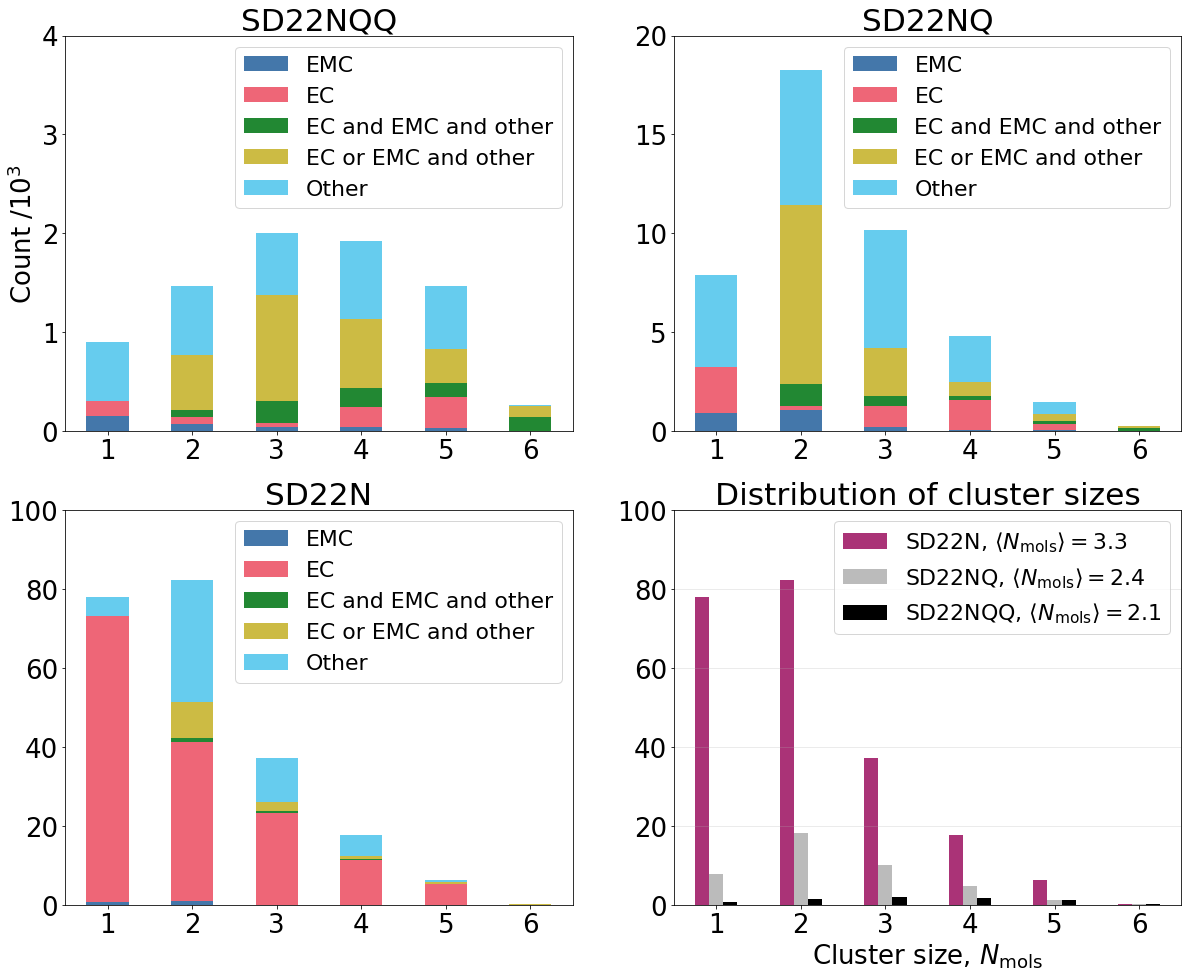

In [34]:
fsize = 26
plt.rcParams.update({'font.size': fsize})

fig, axs = plt.subplots(2,2, figsize=(10*2, 8*2), sharey=False)
comps = {
    'SD22NQQ':SD22NQQ1_comp_flat,
    'SD22NQ':SD22NQ1_comp_flat,
    'SD22N':SD22N_comp_flat,
}
axs = axs.ravel()
for i, (ax, (name, data)) in enumerate(zip(axs, comps.items())):
    d = data/1e3
    if i == 0:
        ax.set_ylim([0,4])
    elif i == 1:
        ax.set_ylim([0,20])
    else:
        ax.set_ylim([0,100])

    d.plot.bar(ax=ax, legend=False, stacked=True, rot=0)
    #ax.set_yscale('log')
    ax.legend(fontsize=fsize-4, ncols=1)
    ax.set_title(name)

axs[0].set_ylabel('Count /$10^3$')

axs[-1].set_title('Distribution of cluster sizes')
scaled_stats_df = stats_df/1e3
scaled_stats_df[['SD22N', 'SD22NQ', 'SD22NQQ']].plot.bar(
#stats_df.plot.bar(
    #ylabel='Count /$10^4$',
	rot=0,
	ax=axs[-1],
    color=cset[5:],
)
axs[-1].set_ylim([0,100])

axs[-1].grid(axis='y', alpha=0.3)
axs[-1].legend(
    [
        f'SD22N, $\\langle N_\\text{{mols}} \\rangle = {SD22N_cluster_size}$',
        f'SD22NQ, $\\langle N_\\text{{mols}} \\rangle = {SD22NQ_cluster_size}$',
        f'SD22NQQ, $\\langle N_\\text{{mols}} \\rangle = {SD22NQQ_cluster_size}$',
    ],
    fontsize=fsize-4,
)

# NPT dynamics, part A

In [6]:
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*') # Argument should be 'tag' to be consistent with zenodo

## Determining diffusion limit start times
### Taken from *Best Practices for Computing Transport Properties 1. Self-Diffusivity and Viscosity from Equilibrium Molecular Dynamics [Article v1.0]*
#### 5.2.3 Data analysis
In order to obtain reliable estimates of D, it is important to consider how the linear regression is performed for the MSD with respect to time (Equation 2). Specifically, the time interval that is included in the regression can have a significant impact on the predicted value of D. We recommend that only the “middle” of the MSD be used in the fit to approximate the long-time slope. Short time must be excluded as it follows a ballistic trajectory, while very long time is excluded due to the increased noise. **Currently, we are unaware of an objective approach for defining the “middle” region. Until such an approach exists, we recommend that the author reports how the region was selected and how much variability in D can be attributed to the choice of this region**. In addition, the uncertainty in the fit of the slope should be reported.

A typical log-log plot, borrowed from Ref. [36], is provided in Figure 2, where the linear regression to the “middle” region is included. From visual inspection, the “ballistic” short-time interval ranges from the beginning of the simulation to approximately 100 ps. **The “middle” region is identified by the linear regime with a slope of 1 (for a log-log plot)** spanning from approximately 100 ps to 1000 ps. Note that the noisy “long-time” simulation data (beyond 1000 ps) are not depicted in Figure 2 and are excluded from the linear fit.

In [7]:
diff_coeffs = []
diff_errs = []
log_r2 = []
diff_r2 = []
diff_starts = []
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):

        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']
        
        idx, r2 = get_start_index(time,msd,threshold=5e-2, window=2000, start_id=0)
        
        if idx != None:   
            D, err, R2 = diffusion_coefficient(time[idx:],msd[idx:])
            diff_coeffs.append(D)
            diff_errs.append(err)
            log_r2.append(r2)
            diff_r2.append(R2)
            print(idx, len(time), r2, D, err, R2)
            diff_starts.append(idx)
        else:
            diff_coeffs.append(np.nan)
            diff_errs.append(np.nan)
            log_r2.append(np.nan)
            diff_r2.append(np.nan)
            diff_starts.append(np.nan)

Using slope error thresold of: 0.05


/home/viktor/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/viktor/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/viktor/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


10904 99997 0.8189493628006552 3.519125589557931e-10 1.199924310352789e-12 0.9925660278578518
Using slope error thresold of: 0.05
9553 99999 0.8885632349877067 2.459632726490469e-10 1.2299945217353864e-12 0.9839087382022202
Using slope error thresold of: 0.05
5813 99999 0.9094575196033572 2.2550402047414157e-10 1.328540415272253e-12 0.9769079810047916
Using slope error thresold of: 0.05
11383 99998 0.9154798703445366 1.7586166981631645e-10 9.24380465231895e-13 0.9826049778554401
Using slope error thresold of: 0.05
12962 81083 0.8938474284211994 2.5144861015906663e-10 2.5085936959030354e-12 0.9532662594481706
Using slope error thresold of: 0.05
4380 81941 0.9213724529782152 3.1731793074403586e-10 1.9937365883226457e-12 0.9783401145764845
Using slope error thresold of: 0.05
11049 82071 0.8472508033006592 1.348931844070957e-10 9.175673523954345e-13 0.9767905670411667
Using slope error thresold of: 0.05
3876 84271 0.9646119629026357 2.337230986195487e-10 1.1981600862657323e-12 0.9849530516

- Yellow: Below 0.95
- Orange: Below 0.90
- Red: Below 0.80

In [48]:
pkl_name = './part3a_wB97_results.pkl'
try:
    df = pd.read_pickle(pkl_name)
except:
    df, dunit = get_density(tags, dynamics_path, std=True)
    df['Diffusion coefficient'] = [d*1e10 for d in diff_coeffs] # 1e-6 cm2/s
    #df['Corr. diffusion coefficient'] = [fsize_correction(D,r) for D,r in df[['Diffusion coefficient', 'Avg. density']]]
    df['Diff. fit error'] = [e*1e10 for e in diff_errs] # 1e-6 cm2/s
    df['log-log r2'] = log_r2
    df['Diff. r2'] = diff_r2
    df['Diff. start time /ns'] = [time[s]*1e-6 if type(s) == int else np.nan for s in diff_starts]
    pd.to_pickle(df, pkl_name)
df.style.applymap(rvalue_formatting, subset=['log-log r2', 'Diff. r2'])
#df.Styler.map(rvalue_formatting, subset=['log-log r2', 'Diff. r2'])

/tmp/ipykernel_752548/1009487742.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df.style.applymap(rvalue_formatting, subset=['log-log r2', 'Diff. r2'])


,Train data,Functional,Seed,Sample,Composition,Temperature,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,log-log r2,Diff. r2,Diff. start time /ns
0,SDN22NQQ,wB97X,1,1,EMC,298,1.133707,0.015552,3.519126,0.011999,0.818949,0.992566,0.109040
1,SDN22NQQ,wB97X,1,1,EC:EMC (3:7),298,1.205010,0.015673,2.459633,0.012300,0.888563,0.983909,0.095530
2,SDN22NQQ,wB97X,1,1,EC:EMC (7:3),298,1.283700,0.016119,2.255040,0.013285,0.909458,0.976908,0.058130
3,SDN22NQQ,wB97X,1,1,EC,313,1.379088,0.016214,1.758617,0.009244,0.915480,0.982605,0.113830
4,SDN22NQQ,wB97X,1,2,EMC,298,1.131117,0.016579,2.514486,0.025086,0.893847,0.953266,0.129620
5,SDN22NQQ,wB97X,1,2,EC:EMC (3:7),298,1.201672,0.014779,3.173179,0.019937,0.921372,0.978340,0.043800
6,SDN22NQQ,wB97X,1,2,EC:EMC (7:3),298,1.292896,0.016199,1.348932,0.009176,0.847251,0.976791,0.110490
7,SDN22NQQ,wB97X,1,2,EC,313,1.384449,0.016043,2.337231,0.011982,0.964612,0.984953,0.038760
8,SDN22NQQ,wB97X,1,3,EMC,298,1.117259,0.016536,4.312872,0.026862,0.879300,0.976756,0.151610
9,SDN22NQQ,wB97X,1,3,EC:EMC (3:7),298,1.183245,0.016968,2.843554,0.018265,0.955108,0.971738,0.025140


In [ ]:
def rvalue_formatting_latex_old(x, trunc=6):
    if x < 0.8:
        return r'\textcolor{RED}{'+str(x)[:trunc]+'}'
    elif x < 0.9:
        return r'\textcolor{ORANGE}{'+str(x)[:trunc]+'}'
    elif x < 0.95:
        return r'\textcolor{YELLOW}{'+str(x)[:trunc]+'}'
    else:
        return str(x)[:trunc]

In [10]:
def rvalue_formatting_latex(x, trunc=6):
    if x < 0.8:
        return r'\color{RED}'+str(x)[:trunc]
    elif x < 0.9:
        return r'\color{ORANGE}'+str(x)[:trunc]
    elif x < 0.95:
        return r'\color{YELLOW}'+str(x)[:trunc]
    else:
        return str(x)[:trunc]

In [11]:
merged_df = df.copy().drop('Functional', axis=1)
merged_df[['log-log r2', 'Diff. r2']] = merged_df[['log-log r2', 'Diff. r2']].applymap(rvalue_formatting_latex)
merged_df['Std. density'] *= 1000
merged_df['Diff. fit error'] *= 1000
merged_df['Density'] = (
    merged_df['Avg. density'].map("{:.3f}".format) + merged_df['Std. density'].map("({:.0f})".format)
)
merged_df['Diffusion coefficient'] = (
    merged_df['Diffusion coefficient'].map("{:.3f}".format) + merged_df['Diff. fit error'].map("({:.0f})".format)
)
merged_df = merged_df.drop(['Avg. density', 'Std. density', 'Diff. fit error'], axis=1)

/tmp/ipykernel_752548/504839524.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  merged_df[['log-log r2', 'Diff. r2']] = merged_df[['log-log r2', 'Diff. r2']].applymap(rvalue_formatting_latex)


In [451]:
cols = [
    'Train data',
    #'Functional',
    'Seed',
    'Sample',
    'Composition',
    'Temperature',
    'Density',
    'Diffusion coefficient',
    'Diff. r2',
    'log-log r2',
    'Diff. start time /ns',
]
dfs = []
for name, group in merged_df[cols].groupby('Train data'):
    dfs.append(group)

print(pd.concat(dfs[::-1]).to_latex(index=False))

\begin{tabular}{lrrllllllr}
\toprule
Train data & Seed & Sample & Composition & Temperature & Density & Diffusion coefficient & Diff. r2 & log-log r2 & Diff. start time /ns \\
\midrule
SDN22NQQ & 1 & 1 & EMC & 298 & 1.134(16) & 3.519(12) & 0.9925 & \color{ORANGE}0.8189 & 0.109040 \\
SDN22NQQ & 1 & 1 & EC:EMC (3:7) & 298 & 1.205(16) & 2.460(12) & 0.9839 & \color{ORANGE}0.8885 & 0.095530 \\
SDN22NQQ & 1 & 1 & EC:EMC (7:3) & 298 & 1.284(16) & 2.255(13) & 0.9769 & \color{YELLOW}0.9094 & 0.058130 \\
SDN22NQQ & 1 & 1 & EC & 313 & 1.379(16) & 1.759(9) & 0.9826 & \color{YELLOW}0.9154 & 0.113830 \\
SDN22NQQ & 1 & 2 & EMC & 298 & 1.131(17) & 2.514(25) & 0.9532 & \color{ORANGE}0.8938 & 0.129620 \\
SDN22NQQ & 1 & 2 & EC:EMC (3:7) & 298 & 1.202(15) & 3.173(20) & 0.9783 & \color{YELLOW}0.9213 & 0.043800 \\
SDN22NQQ & 1 & 2 & EC:EMC (7:3) & 298 & 1.293(16) & 1.349(9) & 0.9767 & \color{ORANGE}0.8472 & 0.110490 \\
SDN22NQQ & 1 & 2 & EC & 313 & 1.384(16) & 2.337(12) & 0.9849 & 0.9646 & 0.038760 \\
SDN22

In [12]:
cols = [
    'Train data',
    #'Functional',
    'Seed',
    'Sample',
    'Composition',
    'Temperature',
    'Density',
    'Diffusion coefficient',
    'Diff. r2',
    'log-log r2',
    'Diff. start time /ns',
]
#dfs = []
for name, group in merged_df[cols].groupby('Train data'):
    #dfs.append(group)
    print(group.to_latex(index=False))



\begin{tabular}{lrrllllllr}
\toprule
Train data & Seed & Sample & Composition & Temperature & Density & Diffusion coefficient & Diff. r2 & log-log r2 & Diff. start time /ns \\
\midrule
SDN22N & 1 & 1 & EMC & 298 & 1.072(22) & 7.285(34) & 0.9849 & 0.9759 & 0.029250 \\
SDN22N & 1 & 1 & EC:EMC (3:7) & 298 & 1.166(18) & 3.267(11) & 0.9923 & \color{YELLOW}0.9437 & 0.074930 \\
SDN22N & 1 & 1 & EC:EMC (7:3) & 298 & 1.272(17) & 2.647(11) & 0.9872 & 0.9738 & 0.043460 \\
SDN22N & 1 & 1 & EC & 313 & 1.398(17) & 2.015(10) & 0.9857 & \color{RED}0.7127 & 0.175100 \\
SDN22N & 2 & 1 & EMC & 298 & 1.025(13) & 11.382(53) & 0.9849 & 0.9583 & 0.022000 \\
SDN22N & 2 & 1 & EC:EMC (3:7) & 298 & 1.097(13) & 7.266(22) & 0.9937 & 0.9607 & 0.025340 \\
SDN22N & 2 & 1 & EC:EMC (7:3) & 298 & 1.181(13) & 4.774(33) & 0.9693 & 0.9607 & 0.074670 \\
SDN22N & 2 & 1 & EC & 313 & 1.287(13) & 5.308(13) & 0.9961 & \color{YELLOW}0.9085 & 0.101730 \\
SDN22N & 3 & 1 & EMC & 298 & 0.982(17) & 14.864(39) & 0.9953 & 0.9825 & 0.043

## Results

### Density

AttributeError: 'NoneType' object has no attribute 'set_color'

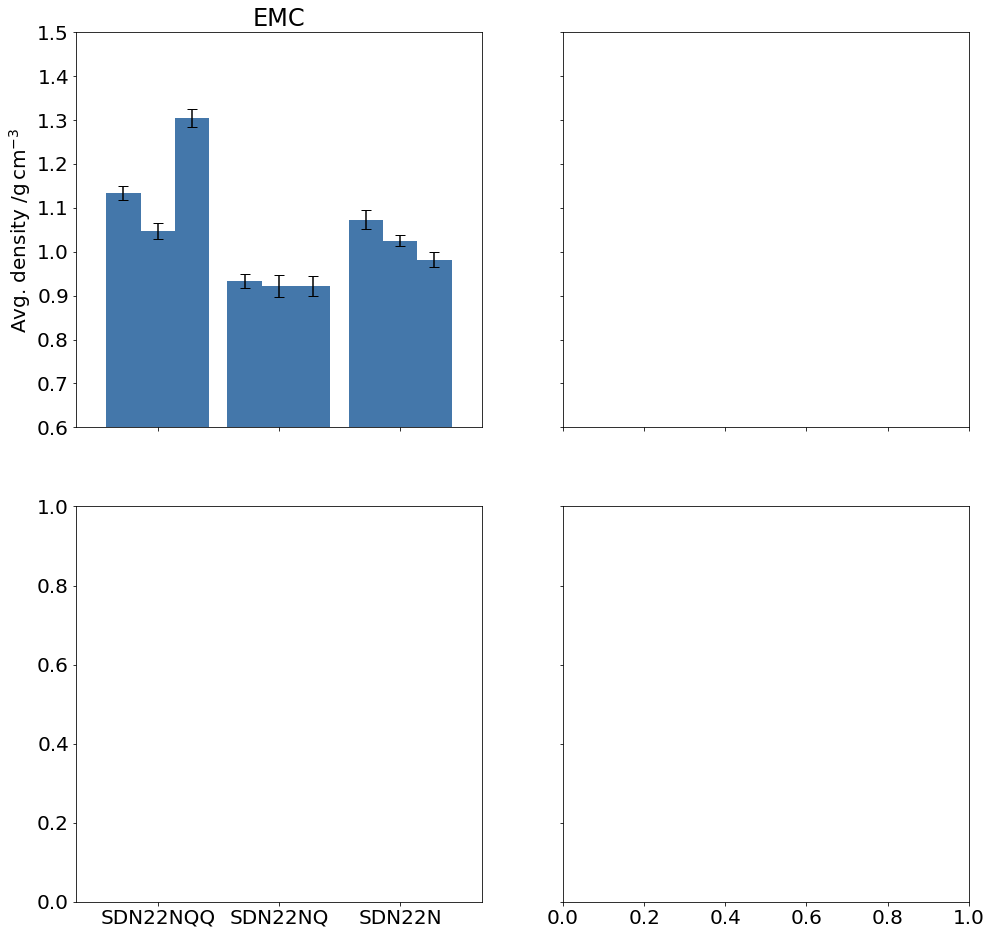

In [49]:
fsize = 20
plt.rcParams.update({'font.size': fsize})
seed_label_height = 0.64

comps = [
    'EMC',
    #'EC:EMC (3:7)', 
    #'EC:EMC (7:3)',
    'EC',
]


fig, axs = plt.subplots(2,2, figsize=(8*2, 8*2), sharey='row', sharex='col')

EMC_mask = df['Composition'] == comps[0]
EC_mask = df['Composition'] == comps[-1]
EC_EMC_df = df[EC_mask | EMC_mask]

seed_df = EC_EMC_df[EC_EMC_df['Sample'] == 1]
for ax, (n,g) in zip(axs[0,:], reversed(list(seed_df.groupby('Composition')))):
    avg_g = g.pivot(
        index='Train data',
        columns='Seed',
        values='Avg. density',
    ).sort_index(axis=0,ascending=False)#[order]
    std_g = g.pivot(
        index='Train data',
        columns='Seed',
        values='Std. density',
    ).sort_index(axis=0,ascending=False)#[order]
    a0 = avg_g.plot.bar(
        title=n,
        ylim=[0.6,1.5],
        ylabel=f'Avg. density /g$\,$cm$^{{-3}}$',
        yerr=std_g,
        capsize=5,
        color=cset[0],
        rot=0,
        width=0.85,
        legend=False,
        ax=ax,
    )
    for bars_in_group in zip(*ax.containers):
        for bar, color in zip(bars_in_group, blue_tol):
            bar.set_color(color)
    
    
    
    """
    bars = ax.containers[1]
    bar_width = bars[0].get_width()
    bar_heights = [bar.get_height() for bar in bars]
    print(bar_heights)
    bar_centers = [bar.get_x() + bar.get_width() / 2 for bar in bars]
    bar_labels = ['Seed 1', 'Seed 2', 'Seed 3']
    
    for i, container in enumerate(ax.containers):
        labels = [bar_labels[i]] * len(c)
        #print(container)
        #for c in container:
        #    print(c)
        #bars = container
        #bar_width = container.get_width()
        try:
            bar_heights = [bar.get_height() for bar in container]
        except:
            None
        print(bar_heights)

        

        for center in bar_centers:
            for i, height in enumerate(bar_heights):

                ax.annotate(
                    f'Seed {i+1}',
                    xy=(center+i*bar_width, height),
                    #color='white',
                    #va='center',
                    ha='center',
                    rotation=90,
                    va='center',
                )
                """
    ax.grid(axis='y', alpha=0.3)    


    #ax.legend(title='Seed:', ncols=3, loc='upper center', fontsize=fsize)
    """
    bar_labels = ['Seed 1', 'Seed 2', 'Seed 3']
    for i, c in enumerate(a0.containers):
        
        labels = [bar_labels[i]] * len(c)
        ax.bar_label(c, yerr=std_g, capsize=5, rotation=90, fontsize=fsize, label_type='center', padding=10, labels=labels, color='white')
    """

sample_df = EC_EMC_df[EC_EMC_df['Seed'] == 1]
for ax, (n,g) in zip(axs[1,:], reversed(list(sample_df.groupby('Composition')))):
    avg_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Avg. density',
    ).sort_index(axis=0,ascending=False)#[order]
    std_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Std. density',
    ).sort_index(axis=0,ascending=False)#[order]
    a1 = avg_g.plot.bar(
        ylim=[0.6,1.5],
        ylabel=f'Avg. density /g$\,$cm$^{{-3}}$',
        yerr=std_g,
        capsize=5,
        color=cset,
        rot=0,
        width=0.85,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    #ax.legend(title='Data set sample:', ncols=3, loc='upper center', fontsize=fsize)

    #for c in a1.containers:
    #    ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', fmt='%.3f', padding=10)
    #for i, c in enumerate(a1.containers):
    #    col_name = avg_g.columns[i]
    #    dens_vals = avg_g[col_name]
    #    dens_errs = std_g[col_name]
    #    dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]
    #    ax.bar_label(c, rotation=90, fontsize=fsize, label_type='center', padding=10, labels=dens_labels, color='white')

#axs[0,0].legend(title='Seed:', ncols=3, loc='upper left', fontsize=fsize-4)
axs[1,0].legend(title='Data set sample:', ncols=3, loc='upper center', fontsize=fsize-4)
plt.tight_layout()

### Diffusivity

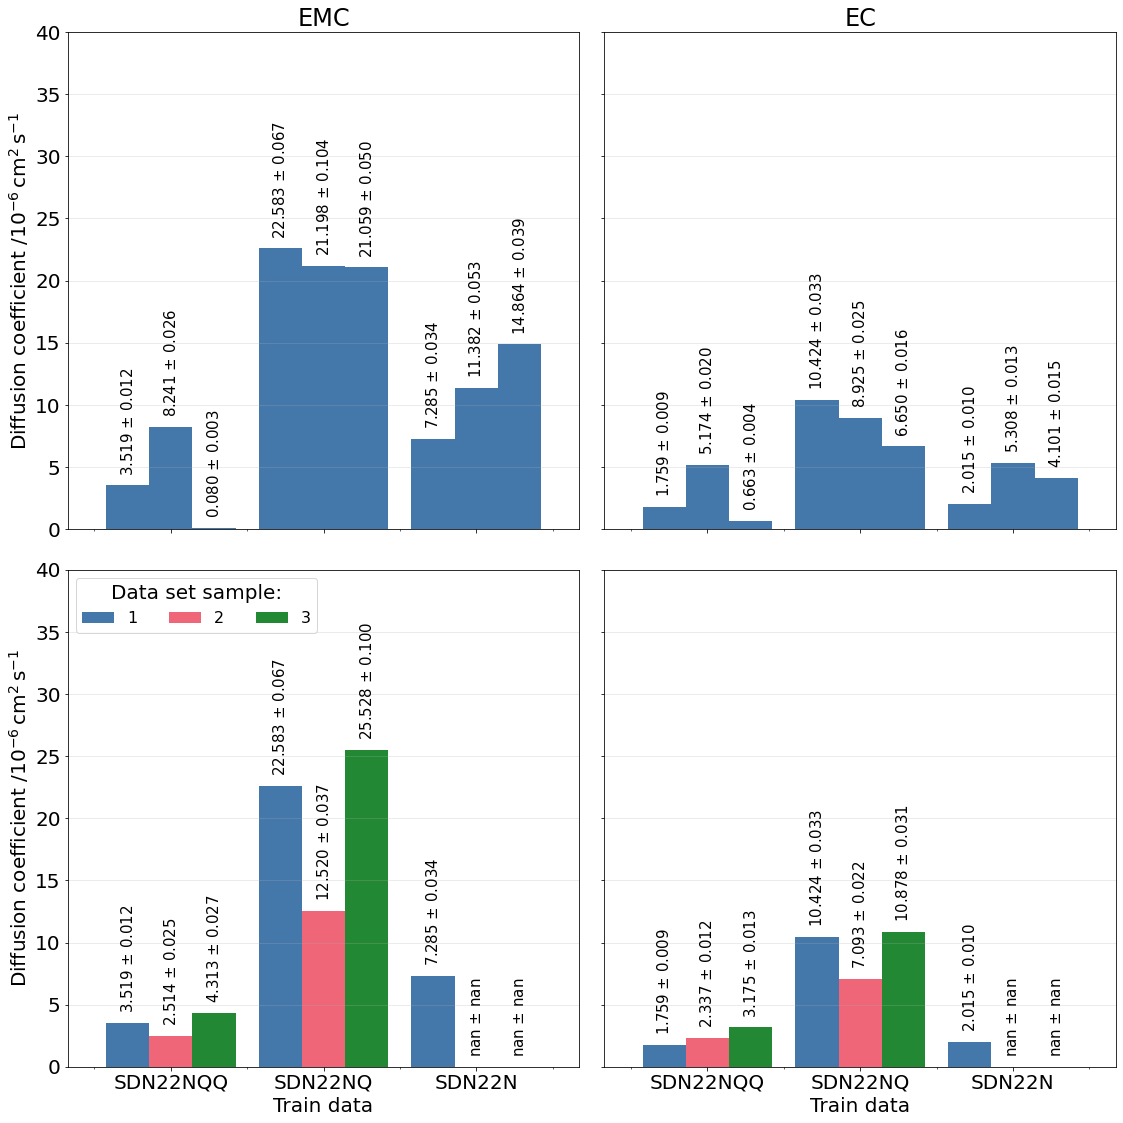

In [14]:
fsize = 20
plt.rcParams.update({'font.size': fsize})


fig, axs = plt.subplots(2,2, figsize=(8*2, 8*2), sharey='row', sharex='col')

EMC_mask = df['Composition'] == comps[0]
EC_mask = df['Composition'] == comps[-1]
EC_EMC_df = df[EC_mask | EMC_mask]

seed_df = EC_EMC_df[EC_EMC_df['Sample'] == 1]
for ax, (n,g) in zip(axs[0,:], reversed(list(seed_df.groupby('Composition')))):
    k = 1
    D_g = g.pivot(
        index='Train data',
        columns='Seed',
        values='Diffusion coefficient',
    ).sort_index(axis=0,ascending=False)#[order]
    err_g = g.pivot(
        index='Train data',
        columns='Seed',
        values='Diff. fit error',
    ).sort_index(axis=0,ascending=False)#[order]
    a0 = D_g.plot.bar(
        title=n,
        ylim=[0,40],
        ylabel=f'Diffusion coefficient /$10^{{-6}}\\,\\text{{cm}}^2\\,\\text{{s}}^{{-1}}$',
        color=cset[0],
        rot=0,
        width=0.85,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    #ax.legend(title='Seed:', ncols=3, loc='upper center', fontsize=fsize-8)

    #for c in a0.containers:
    #    ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', fmt='%.3f', padding=10)
    for i, c in enumerate(a0.containers):
        col_name = D_g.columns[i]
        diff_vals = D_g[col_name]
        diff_erros = err_g[col_name]
        diff_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(diff_vals, diff_erros)]
        ax.bar_label(c, rotation=90, fontsize=fsize-5, label_type='edge', padding=10, labels=diff_labels, color='black')

sample_df = EC_EMC_df[EC_EMC_df['Seed'] == 1]
CSET = [cset[0]]+list(cset[3:])
for ax, (n,g) in zip(axs[1,:], reversed(list(sample_df.groupby('Composition')))):
    D_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Diffusion coefficient',
    ).sort_index(axis=0,ascending=False)#[order]
    err_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Diff. fit error',
    ).sort_index(axis=0,ascending=False)#[order]
    a1 = D_g.plot.bar(
        ylim=[0,40],
        ylabel=f'Diffusion coefficient /$10^{{-6}}\\,\\text{{cm}}^2\\,\\text{{s}}^{{-1}}$',
        color=cset,
        rot=0,
        width=0.85,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    #ax.legend(title='Data set sample:', ncols=3, loc='upper center', fontsize=fsize-8)

    #for c in a1.containers:
    #    ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', fmt='%.3f', padding=10)
    for i, c in enumerate(a1.containers):
        col_name = D_g.columns[i]
        diff_vals = D_g[col_name]
        diff_erros = err_g[col_name]
        diff_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(diff_vals, diff_erros)]
        ax.bar_label(c, rotation=90, fontsize=fsize-5, label_type='edge', padding=10, labels=diff_labels, color='black')

#axs[0,0].legend(title='Seed:', ncols=3, loc='upper left', fontsize=fsize-4)
axs[1,0].legend(title='Data set sample:', ncols=3, loc='upper left', fontsize=fsize-4)
plt.tight_layout()

In [ ]:
def reduce_df(df, drop_list):
    df = df.drop(drop_list, axis=1)

    data = {}
    for i, (name, group) in enumerate(df.groupby('Composition')):
        dens = group['Avg. density'].mean()
        dens_err = (group['Std. density']**2).sum()**0.5/len(group)

        diff = group['Diffusion coefficient'].mean()
        #diff_err = (group['Diff. fit error']**2).sum()**0.5/len(group)
        diff_err = group['Diffusion coefficient'].std()

        from scipy.stats import t
        tinv = lambda p, df: abs(t.ppf(p/2, df))
        ts = tinv(0.05, len(time)-2)

        diff_start = group['Diff. start time /ns'].mean()
        tmp = {'Composition':name}
        for col in group.columns:
            try:
                if ('Std' in col) or ('error' in col):
                    tmp[col] = (group[col]**2).sum()**0.5/len(group)
                else:
                    tmp[col] = group[col].mean()
            except:
                tmp[col] = group[col].iloc[0]
        data[i] = tmp
    dframe = pd.DataFrame.from_dict(data, orient='index')
    return dframe


In [213]:
drop_list = ['Seed', 'Sample', 'log-log r2', 'Diff. r2']
SD22NQ_wB97_df = reduce_df(df[df['Train data'] == 'SDN22NQ'], drop_list)
SD22NQ_wB97_df

,Composition,Train data,Functional,Temperature,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,Diff. start time /ns
0,EC,SDN22NQ,wB97X,313,1.239912,0.008359,8.793851,0.011624,0.041394
1,EC:EMC (3:7),SDN22NQ,wB97X,298,1.032804,0.009197,13.314893,0.022457,0.049718
2,EC:EMC (7:3),SDN22NQ,wB97X,298,1.130835,0.008155,9.856954,0.012524,0.044054
3,EMC,SDN22NQ,wB97X,298,0.946189,0.009395,20.577471,0.034215,0.066052


In [570]:
print(cset.blue)
bset = [
    '#4477AA',
    '#77a0c9',
    '#b1c9e0',
]

#4477AA


In [572]:
print(cset.blue)


#4477AA


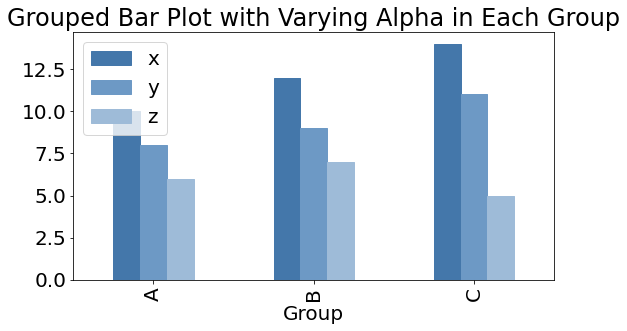

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample pivot-like data
data = {
    'Group': ['A', 'B', 'C'],
    'x': [10, 12, 14],
    'y': [8, 9, 11],
    'z': [6, 7, 5]
}

# Simulate a pivot table (index + multiple columns)
ddf = pd.DataFrame(data).set_index('Group')

# Plot grouped bar plot
ax = ddf.plot(kind='bar', figsize=(8, 5))

# Define alpha values to apply across bars *within* each group
alphas = [1.0, 0.6, 0.3]  # For the 1st, 2nd, 3rd bar in each group

# Apply alpha per bar in each group
# Each container corresponds to one column (series), so we zip index-wise
for bars_in_group in zip(*ax.containers):
    for bar, col in zip(bars_in_group, bset):
        bar.set_color(col)
ax.legend()

plt.title("Grouped Bar Plot with Varying Alpha in Each Group")
plt.tight_layout()
plt.show()


In [92]:
import ase.units

mass_thermo = get_all_thermo(f'{dynamics_path}{tags[-1]}/*', xyz=True) # Argument should be 'tag' to be consistent with zenodo

for comp, traj in mass_thermo.items():
    if '000conEC' in comp:
        print('Pure EMC:')
        M_EMC = traj[0].get_masses().sum() # u=g/mol
        m_EMC = M_EMC/ase.units.mol*1e-3 # g/mol*mol/1000=kg
        print(f'Total mass:\t{m_EMC} kg')
    elif '100conEC' in comp:
        print('Pure EC:')
        M_EC = traj[0].get_masses().sum() # u=g/mol
        m_EC = M_EC/ase.units.mol*1e-3 # g/mol*mol/1000=kg
        print(f'Total mass:\t{m_EC} kg')

Pure EMC:
Total mass:	1.1582317925845882e-23 kg
Pure EC:
Total mass:	1.462303889780969e-23 kg


In [229]:
corr_df = df.copy()
#corr_df = corr_df.drop('Train data', axis=1)
#corr_df = corr_df.drop('log-log r2', axis=1)
#corr_df = corr_df.drop('Diff. r2', axis=1) 
#corr_df = corr_df.drop('Diff. start time /ns', axis=1)
corr_df = corr_df[(corr_df['Composition'] == 'EMC') | (corr_df['Composition'] == 'EC')]
#corr_df

eta_EC = 1.9e-3 # Pa s
eta_EMC = 0.65e-3 # Pa s
kB = ase.units.kB/ase.units.J
xi = 2.837298
print(f'EMC viscosity:\t{eta_EMC} Pa s (at 298 K)')
print(f'EC viscosity:\t{eta_EC} Pa s (at 313 K)')
print(f'kB:\t\t{kB} J/K\n')

for tag, data in thermo.items():
    print(tag)
    data_set, functional, seed, dset = tag.split('/')
    k = 1
    for comp, traj in data.items():
        temp = int(comp.split('_')[-1][:-1])
        if '300K' in comp:
            dens = traj['v_mdensity']['data'].mean()*1000 # kg/m3
        else:
            dens = traj['Density']['data'].mean()*1000 # kg/m3
        if '000conEC' in comp:
            print('EMC:')
            k = 1
            total_mass = m_EMC
            eta = eta_EMC

        elif '100conEC' in comp:
            print('EC:')
            k = 1
            total_mass = m_EC
            eta = eta_EC
        else:
            k = 0
        
        volume = total_mass/dens # m3
        L = volume**(1/3) # m
        corr = k*xi*kB*temp/(6*np.pi*eta*L) # kT=[J]=[Pa m3] => Pa m3/(Pa s m)=m2/s
        corr *= 1e10 # 1e-6 cm2/s
        if corr > 0:
            print(f'Box length:\t{L*1e10:.3f} Å')
            print(f'Correction:\t{corr:.3f} 1e-6cm2/s\n')

        #func_mask = corr_df['Functional'] == functional
        comp_mask = corr_df['Composition'] == tmap[comp]  
        seed_mask = corr_df['Seed'] == int(seed[-1])
        dset_mask = corr_df['Sample'] == int(dset[-1])
        print(corr_df.loc[comp_mask & seed_mask & dset_mask, 'Diffusion coefficient'])
        corr_df.loc[comp_mask & seed_mask & dset_mask, 'Diffusion coefficient'] += corr
corr_df

EMC viscosity:	0.00065 Pa s (at 298 K)
EC viscosity:	0.0019 Pa s (at 313 K)
kB:		1.38064852e-23 J/K

SDN22NQ/B97/SEED1/DSET1
EMC:
Box length:	22.325 Å
Correction:	4.268 1e-6cm2/s

0      3.519126
20    22.582548
40     7.285252
Name: Diffusion coefficient, dtype: float64
Series([], Name: Diffusion coefficient, dtype: float64)
Series([], Name: Diffusion coefficient, dtype: float64)
EC:
Box length:	22.520 Å
Correction:	1.520 1e-6cm2/s

3      1.758617
23    10.423719
43     2.015321
Name: Diffusion coefficient, dtype: float64
SDN22NQ/B97/SEED1/DSET2
EMC:
Box length:	23.930 Å
Correction:	3.982 1e-6cm2/s

4      2.514486
24    12.519833
Name: Diffusion coefficient, dtype: float64
Series([], Name: Diffusion coefficient, dtype: float64)
Series([], Name: Diffusion coefficient, dtype: float64)
EC:
Box length:	23.588 Å
Correction:	1.451 1e-6cm2/s

7     2.337231
27    7.093466
Name: Diffusion coefficient, dtype: float64
SDN22NQ/B97/SEED1/DSET3
EMC:
Box length:	24.188 Å
Correction:	3.939 1e-6cm2

,Train data,Functional,Seed,Sample,Composition,Temperature,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,log-log r2,Diff. r2,Diff. start time /ns
0,SDN22NQQ,wB97X,1,1,EMC,298,1.133707,0.015552,7.786802,0.011999,0.818949,0.992566,0.10904
3,SDN22NQQ,wB97X,1,1,EC,313,1.379088,0.016214,3.278879,0.009244,0.915480,0.982605,0.11383
4,SDN22NQQ,wB97X,1,2,EMC,298,1.131117,0.016579,6.496071,0.025086,0.893847,0.953266,0.12962
7,SDN22NQQ,wB97X,1,2,EC,313,1.384449,0.016043,3.788611,0.011982,0.964612,0.984953,0.03876
8,SDN22NQQ,wB97X,1,3,EMC,298,1.117259,0.016536,8.251908,0.026862,0.879300,0.976756,0.15161
11,SDN22NQQ,wB97X,1,3,EC,313,1.336678,0.017196,4.627926,0.012706,0.820844,0.990228,0.14798
12,SDN22NQQ,wB97X,2,1,EMC,298,1.047008,0.019031,8.241460,0.026001,0.932915,0.993157,0.04262
15,SDN22NQQ,wB97X,2,1,EC,313,1.300434,0.017665,5.173632,0.020258,0.931404,0.990077,0.09591
16,SDN22NQQ,wB97X,3,1,EMC,298,1.304436,0.019875,0.079745,0.003496,0.708268,0.464969,0.17210
19,SDN22NQQ,wB97X,3,1,EC,313,1.451488,0.018359,0.662959,0.003877,0.826395,0.978329,0.10406


In [230]:
drop_list = ['Seed', 'Sample', 'log-log r2', 'Diff. r2']
SD22NQ_wB97_corr_df = reduce_df(corr_df.copy()[corr_df['Train data'] == 'SDN22NQ'], drop_list)
SD22NQ_wB97_corr_df

,Composition,Train data,Functional,Temperature,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,Diff. start time /ns
0,EC,SDN22NQ,wB97X,313,1.239912,0.008359,9.678827,0.011624,0.041394
1,EMC,SDN22NQ,wB97X,298,0.946189,0.009395,23.015131,0.034215,0.066052


### Intermolecular radial distributions

In [196]:
rdfs, number_densities = eval_rdfs(tags, dynamics_path)

with open('./part3a_rdfs.pkl', 'wb') as f:
    pickle.dump(rdfs, f)

with open('./part3a_rhos.pkl', 'wb') as f:
    pickle.dump(number_densities, f)

SDN22NQQ_wB97X DSET1 SEED1
../publication/dynamics/SDN22NQQ/wB97X/SEED1/DSET1/npt_000conEC_298K.xyz
../publication/dynamics/SDN22NQQ/wB97X/SEED1/DSET1/npt_033conEC_298K.xyz
../publication/dynamics/SDN22NQQ/wB97X/SEED1/DSET1/npt_066conEC_298K.xyz
../publication/dynamics/SDN22NQQ/wB97X/SEED1/DSET1/npt_100conEC_313K.xyz
SDN22NQQ_wB97X DSET2 SEED1
../publication/dynamics/SDN22NQQ/wB97X/SEED1/DSET2/npt_000conEC_298K.xyz
../publication/dynamics/SDN22NQQ/wB97X/SEED1/DSET2/npt_033conEC_298K.xyz
../publication/dynamics/SDN22NQQ/wB97X/SEED1/DSET2/npt_066conEC_298K.xyz
../publication/dynamics/SDN22NQQ/wB97X/SEED1/DSET2/npt_100conEC_313K.xyz
SDN22NQQ_wB97X DSET3 SEED1
../publication/dynamics/SDN22NQQ/wB97X/SEED1/DSET3/npt_000conEC_298K.xyz
../publication/dynamics/SDN22NQQ/wB97X/SEED1/DSET3/npt_033conEC_298K.xyz
../publication/dynamics/SDN22NQQ/wB97X/SEED1/DSET3/npt_066conEC_298K.xyz
../publication/dynamics/SDN22NQQ/wB97X/SEED1/DSET3/npt_100conEC_313K.xyz
SDN22NQQ_wB97X DSET1 SEED2
../publication/d

In [252]:
with open('./part3a_rdfs.pkl', 'rb') as f:
    rdfs = pickle.load(f)

with open('./part3a_rhos.pkl', 'rb') as f:
    number_densities = pickle.load(f)

In [253]:
rdfs.keys()

dict_keys(['SDN22NQQ_wB97X', 'SDN22NQ_wB97X', 'SDN22N_wB97X'])

In [260]:
rstart = 6
id_width = 20

radii = []
for model,dsets in rdfs.items():
    for dset,seeds in dsets.items():
        for seed,comps in seeds.items():
            for comp, (g, r) in comps.items():
                id0 = np.where(r>rstart)[0][0]
                
                idhi = id0+id_width
                rmin = min(r[id0:idhi])
                idx = np.argmin(g[id0:idhi])
                
                rho = number_densities[model][dset][seed][comp]
                r_prime = r[:id0+idx]
                g_prime = g[1:id0+idx]                        
                v_shell = 4/3*np.pi*(r_prime[1:]**3-r_prime[:-1]**3)
                N = sum(g_prime*v_shell*rho)
                train_data, functional = model.split('_')
                radii.append([train_data, functional, seed, dset, comp, r[id0+idx], N])

radii_df = pd.DataFrame(radii, columns=['Train data', 'Functional', 'Seed', 'Sample', 'Composition', 'Rmin', 'CN'])
for name, group in radii_df.groupby('Train data'):
    print('Average first shell coordinations:')
    print(name, group['CN'].mean(), '\n')
radii_df

Average first shell coordinations:
SDN22N 9.754363556084144 

Average first shell coordinations:
SDN22NQ 9.041401405391754 

Average first shell coordinations:
SDN22NQQ 10.377932878633384 



,Train data,Functional,Seed,Sample,Composition,Rmin,CN
0,SDN22NQQ,wB97X,SEED1,DSET1,"EMC (298$\,$K)",8.195,11.988117
1,SDN22NQQ,wB97X,SEED1,DSET1,"EC:EMC (3:7) (298$\,$K)",7.975,12.307413
2,SDN22NQQ,wB97X,SEED1,DSET1,"EC:EMC (7:3) (298$\,$K)",7.205,9.833874
3,SDN22NQQ,wB97X,SEED1,DSET1,"EC (313$\,$K)",6.985,10.512331
4,SDN22NQQ,wB97X,SEED2,DSET1,"EMC (298$\,$K)",8.195,10.927079
5,SDN22NQQ,wB97X,SEED2,DSET1,"EC:EMC (3:7) (298$\,$K)",7.645,9.689100
6,SDN22NQQ,wB97X,SEED2,DSET1,"EC:EMC (7:3) (298$\,$K)",7.315,9.576814
7,SDN22NQQ,wB97X,SEED2,DSET1,"EC (313$\,$K)",7.205,10.708805
8,SDN22NQQ,wB97X,SEED3,DSET1,"EMC (298$\,$K)",8.085,13.425760
9,SDN22NQQ,wB97X,SEED3,DSET1,"EC:EMC (3:7) (298$\,$K)",6.765,7.578198


Seed 1

Average first shell coordinations:
SDN22N 9.672670181485195 

Average first shell coordinations:
SDN22NQ 9.179484713731167 

Average first shell coordinations:
SDN22NQQ 11.160433963967069 



,Train data,Functional,Seed,Sample,Composition,Rmin,CN
0,SDN22NQQ,wB97X,SEED1,DSET1,"EMC (298$\,$K)",8.195,11.988117
1,SDN22NQQ,wB97X,SEED1,DSET1,"EC:EMC (3:7) (298$\,$K)",7.975,12.307413
2,SDN22NQQ,wB97X,SEED1,DSET1,"EC:EMC (7:3) (298$\,$K)",7.205,9.833874
3,SDN22NQQ,wB97X,SEED1,DSET1,"EC (313$\,$K)",6.985,10.512331
4,SDN22NQ,wB97X,SEED1,DSET1,"EMC (298$\,$K)",8.195,9.366384
5,SDN22NQ,wB97X,SEED1,DSET1,"EC:EMC (3:7) (298$\,$K)",7.645,8.539132
6,SDN22NQ,wB97X,SEED1,DSET1,"EC:EMC (7:3) (298$\,$K)",7.425,9.135402
7,SDN22NQ,wB97X,SEED1,DSET1,"EC (313$\,$K)",7.095,9.677022
8,SDN22N,wB97X,SEED1,DSET1,"EMC (298$\,$K)",7.645,8.763927
9,SDN22N,wB97X,SEED1,DSET1,"EC:EMC (3:7) (298$\,$K)",7.425,9.184222


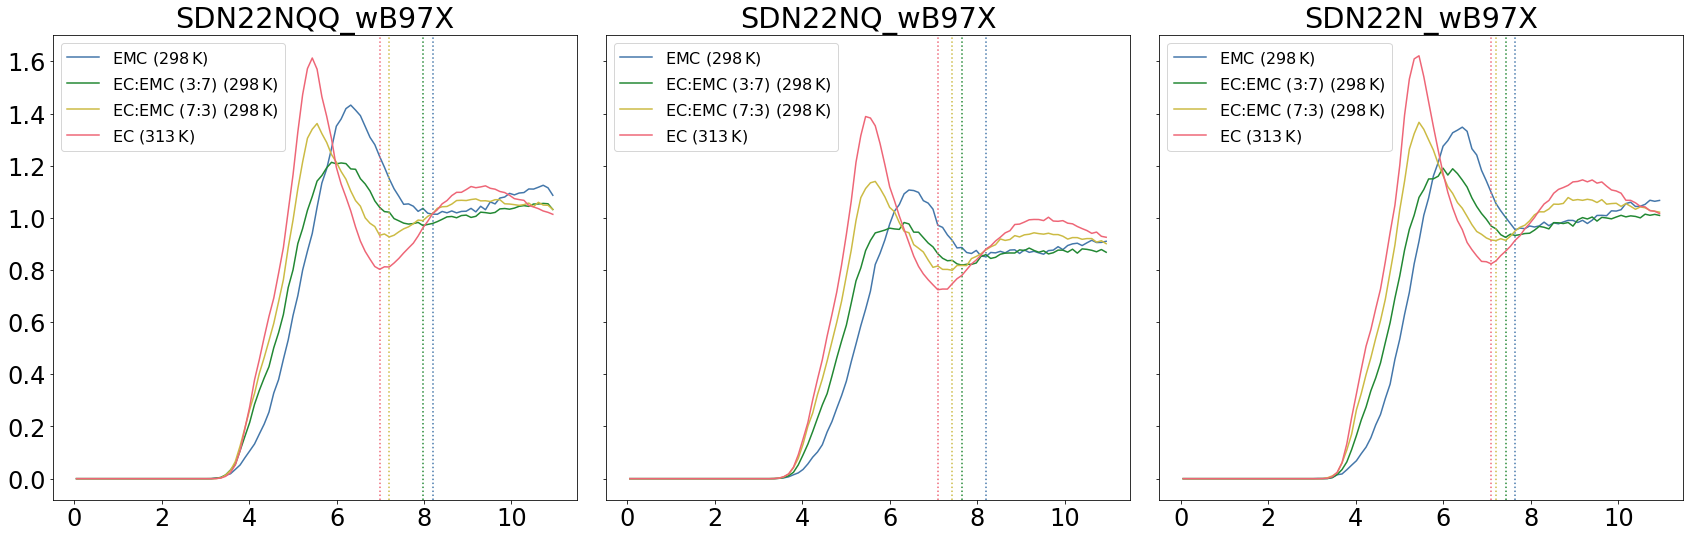

In [238]:
plt.rcParams.update({'font.size': fsize})


rstart = 6
id_width = 20

radii = []
fig, axs = plt.subplots(1,3, figsize=(3*8,1*8), sharey=True)
for ax, (model,dsets) in zip(axs, rdfs.items()):
    ax.set_title(model)
    #print(model)
    for dset,seeds in dsets.items():
        #print(dset)
        if dset == 'DSET1':
            for seed,comps in seeds.items():
                if seed == 'SEED1':
                    #print(seed)
                    for comp, (g, r) in comps.items():
                        #print(comp)
                        id0 = np.where(r>rstart)[0][0]
                        #print(id0, r[id0])
                        
                        idhi = id0+id_width
                        rmin = min(r[id0:idhi])
                        idx = np.argmin(g[id0:idhi])
                        #print(idx, r[idx])

                        ax.axvline(r[id0+idx], 0, 1, color=get_colour(comp), alpha=1, linestyle='dotted')
                        #ax.axvspan(r[id0], r[idhi],alpha=0.05, color='gray')
                        ax.plot(r, g, label=comp, color=get_colour(comp))
                        ax.legend(fontsize=fsize-8)
                        
                        rho = number_densities[model][dset][seed][comp]
                        r_prime = r[:id0+idx]
                        g_prime = g[1:id0+idx]                        
                        v_shell = 4/3*np.pi*(r_prime[1:]**3-r_prime[:-1]**3)
                        N = sum(g_prime*v_shell*rho)
                        
                        train_data, functional = model.split('_')
                        radii.append([train_data, functional, seed, dset, comp, r[id0+idx], N])
plt.tight_layout()

radii_df = pd.DataFrame(radii, columns=['Train data', 'Functional', 'Seed', 'Sample', 'Composition', 'Rmin', 'CN'])
for name, group in radii_df.groupby('Train data'):
    print('Average first shell coordinations:')
    print(name, group['CN'].mean(), '\n')
radii_df

Seed 2

Average first shell coordinations:
SDN22N 9.75618486777649 

Average first shell coordinations:
SDN22NQ 8.910306492598433 

Average first shell coordinations:
SDN22NQQ 10.225449502818734 



,Train data,Functional,Seed,Sample,Composition,Rmin,CN
0,SDN22NQQ,wB97X,SEED2,DSET1,"EMC (298$\,$K)",8.195,10.927079
1,SDN22NQQ,wB97X,SEED2,DSET1,"EC:EMC (3:7) (298$\,$K)",7.645,9.689100
2,SDN22NQQ,wB97X,SEED2,DSET1,"EC:EMC (7:3) (298$\,$K)",7.315,9.576814
3,SDN22NQQ,wB97X,SEED2,DSET1,"EC (313$\,$K)",7.205,10.708805
4,SDN22NQ,wB97X,SEED2,DSET1,"EMC (298$\,$K)",8.085,8.868373
5,SDN22NQ,wB97X,SEED2,DSET1,"EC:EMC (3:7) (298$\,$K)",7.645,8.710687
6,SDN22NQ,wB97X,SEED2,DSET1,"EC:EMC (7:3) (298$\,$K)",7.205,8.423893
7,SDN22NQ,wB97X,SEED2,DSET1,"EC (313$\,$K)",7.095,9.638273
8,SDN22N,wB97X,SEED2,DSET1,"EMC (298$\,$K)",8.085,10.059809
9,SDN22N,wB97X,SEED2,DSET1,"EC:EMC (3:7) (298$\,$K)",7.755,9.880418


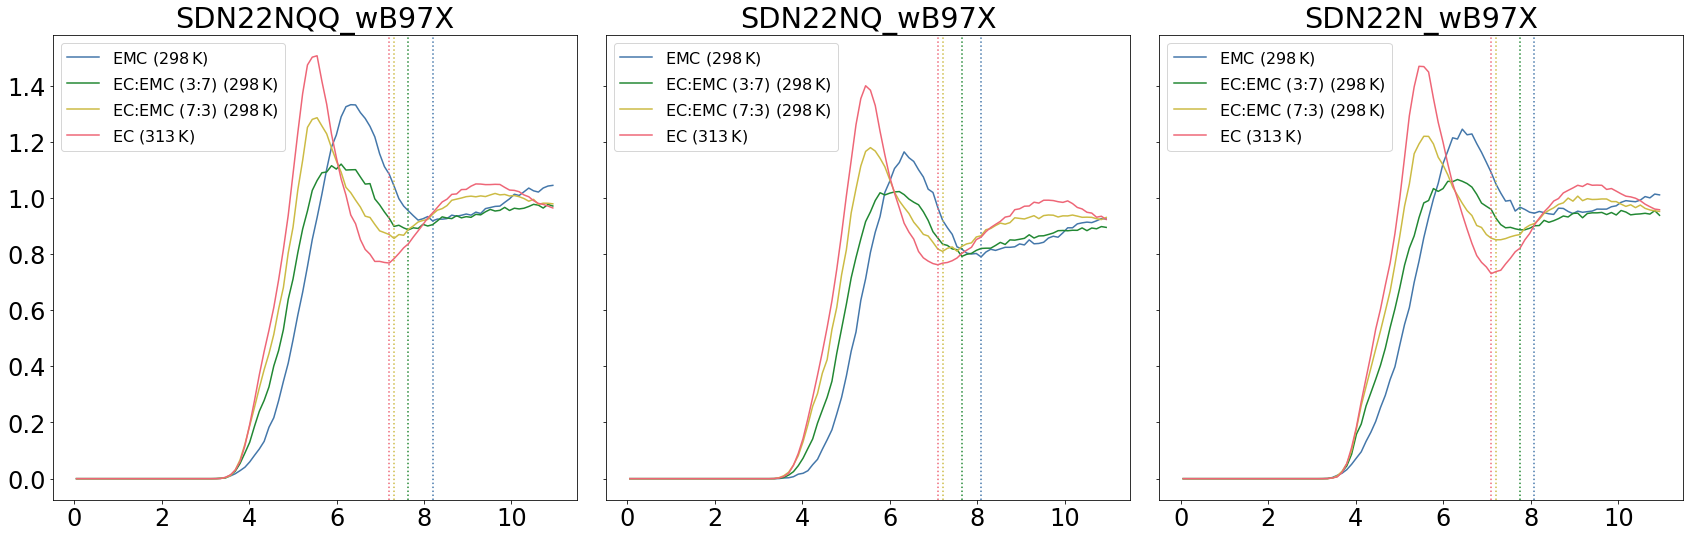

In [239]:
plt.rcParams.update({'font.size': fsize})


rstart = 6
id_width = 20

radii = []
fig, axs = plt.subplots(1,3, figsize=(3*8,1*8), sharey=True)
for ax, (model,dsets) in zip(axs, rdfs.items()):
    ax.set_title(model)
    #print(model)
    for dset,seeds in dsets.items():
        #print(dset)
        if dset == 'DSET1':
            for seed,comps in seeds.items():
                if seed == 'SEED2':
                    #print(seed)
                    for comp, (g, r) in comps.items():
                        #print(comp)
                        id0 = np.where(r>rstart)[0][0]
                        #print(id0, r[id0])
                        
                        idhi = id0+id_width
                        rmin = min(r[id0:idhi])
                        idx = np.argmin(g[id0:idhi])
                        #print(idx, r[idx])

                        ax.axvline(r[id0+idx], 0, 1, color=get_colour(comp), alpha=1, linestyle='dotted')
                        #ax.axvspan(r[id0], r[idhi],alpha=0.05, color='gray')
                        ax.plot(r, g, label=comp, color=get_colour(comp))
                        ax.legend(fontsize=fsize-8)
                        
                        rho = number_densities[model][dset][seed][comp]
                        r_prime = r[:id0+idx]
                        g_prime = g[1:id0+idx]                        
                        v_shell = 4/3*np.pi*(r_prime[1:]**3-r_prime[:-1]**3)
                        N = sum(g_prime*v_shell*rho)
                        
                        train_data, functional = model.split('_')
                        radii.append([train_data, functional, seed, dset, comp, r[id0+idx], N])
plt.tight_layout()

radii_df = pd.DataFrame(radii, columns=['Train data', 'Functional', 'Seed', 'Sample', 'Composition', 'Rmin', 'CN'])
for name, group in radii_df.groupby('Train data'):
    print('Average first shell coordinations:')
    print(name, group['CN'].mean(), '\n')
radii_df

Seed 3

Average first shell coordinations:
SDN22N 9.834235618990744 

Average first shell coordinations:
SDN22NQ 9.12303064881826 

Average first shell coordinations:
SDN22NQQ 10.582601109925228 



,Train data,Functional,Seed,Sample,Composition,Rmin,CN
0,SDN22NQQ,wB97X,SEED3,DSET1,"EMC (298$\,$K)",8.085,13.425760
1,SDN22NQQ,wB97X,SEED3,DSET1,"EC:EMC (3:7) (298$\,$K)",6.765,7.578198
2,SDN22NQQ,wB97X,SEED3,DSET1,"EC:EMC (7:3) (298$\,$K)",7.205,10.742233
3,SDN22NQQ,wB97X,SEED3,DSET1,"EC (313$\,$K)",6.875,10.584213
4,SDN22NQ,wB97X,SEED3,DSET1,"EMC (298$\,$K)",8.195,9.302457
5,SDN22NQ,wB97X,SEED3,DSET1,"EC:EMC (3:7) (298$\,$K)",7.645,8.654470
6,SDN22NQ,wB97X,SEED3,DSET1,"EC:EMC (7:3) (298$\,$K)",7.315,8.849337
7,SDN22NQ,wB97X,SEED3,DSET1,"EC (313$\,$K)",7.095,9.685858
8,SDN22N,wB97X,SEED3,DSET1,"EMC (298$\,$K)",8.195,9.969942
9,SDN22N,wB97X,SEED3,DSET1,"EC:EMC (3:7) (298$\,$K)",7.865,10.093049


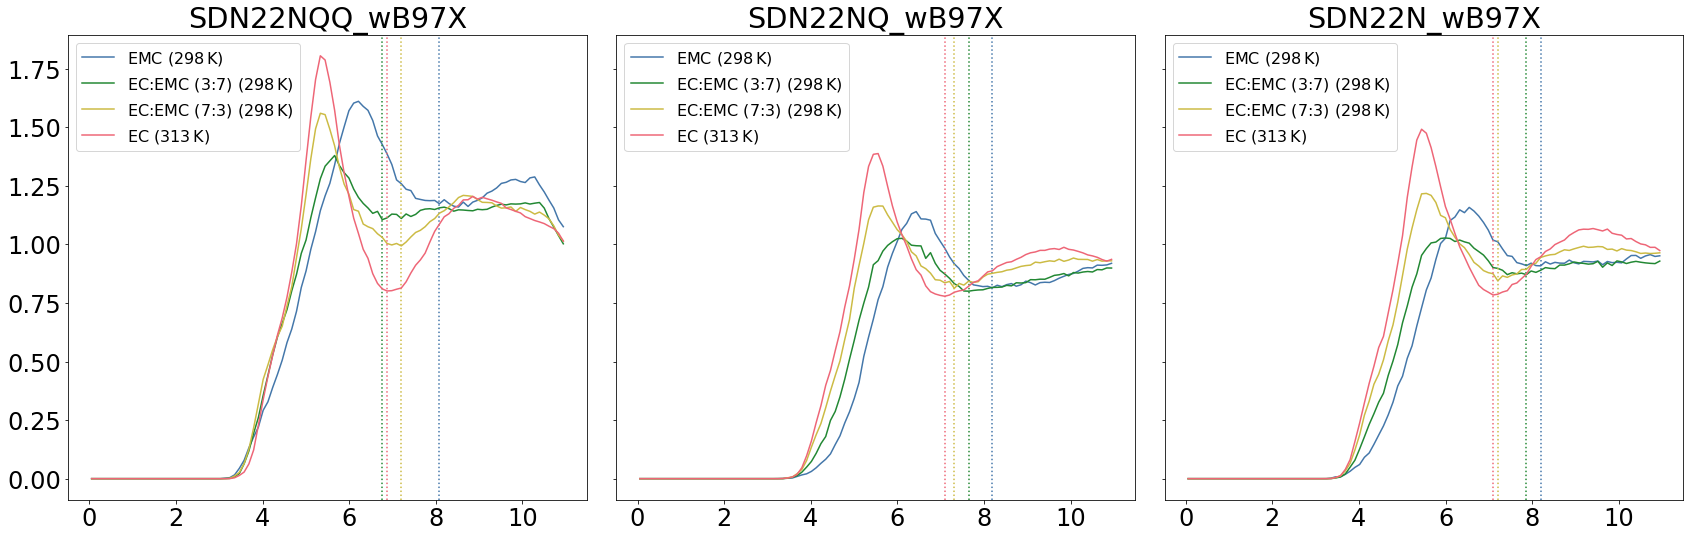

In [240]:
plt.rcParams.update({'font.size': fsize})


rstart = 6
id_width = 20

radii = []
fig, axs = plt.subplots(1,3, figsize=(3*8,1*8), sharey=True)
for ax, (model,dsets) in zip(axs, rdfs.items()):
    ax.set_title(model)
    #print(model)
    for dset,seeds in dsets.items():
        #print(dset)
        if dset == 'DSET1':
            for seed,comps in seeds.items():
                if seed == 'SEED3':
                    #print(seed)
                    for comp, (g, r) in comps.items():
                        #print(comp)
                        id0 = np.where(r>rstart)[0][0]
                        #print(id0, r[id0])
                        
                        idhi = id0+id_width
                        rmin = min(r[id0:idhi])
                        idx = np.argmin(g[id0:idhi])
                        #print(idx, r[idx])

                        ax.axvline(r[id0+idx], 0, 1, color=get_colour(comp), alpha=1, linestyle='dotted')
                        #ax.axvspan(r[id0], r[idhi],alpha=0.05, color='gray')
                        ax.plot(r, g, label=comp, color=get_colour(comp))
                        ax.legend(fontsize=fsize-8)
                        
                        rho = number_densities[model][dset][seed][comp]
                        r_prime = r[:id0+idx]
                        g_prime = g[1:id0+idx]                        
                        v_shell = 4/3*np.pi*(r_prime[1:]**3-r_prime[:-1]**3)
                        N = sum(g_prime*v_shell*rho)
                        
                        train_data, functional = model.split('_')
                        radii.append([train_data, functional, seed, dset, comp, r[id0+idx], N])
plt.tight_layout()

radii_df = pd.DataFrame(radii, columns=['Train data', 'Functional', 'Seed', 'Sample', 'Composition', 'Rmin', 'CN'])
for name, group in radii_df.groupby('Train data'):
    print('Average first shell coordinations:')
    print(name, group['CN'].mean(), '\n')
radii_df

Data set 1

Average first shell coordinations:
SDN22N 9.672670181485195 

Average first shell coordinations:
SDN22NQ 9.179484713731167 

Average first shell coordinations:
SDN22NQQ 11.160433963967069 



,Train data,Functional,Seed,Sample,Composition,Rmin,CN
0,SDN22NQQ,wB97X,SEED1,DSET1,"EMC (298$\,$K)",8.195,11.988117
1,SDN22NQQ,wB97X,SEED1,DSET1,"EC:EMC (3:7) (298$\,$K)",7.975,12.307413
2,SDN22NQQ,wB97X,SEED1,DSET1,"EC:EMC (7:3) (298$\,$K)",7.205,9.833874
3,SDN22NQQ,wB97X,SEED1,DSET1,"EC (313$\,$K)",6.985,10.512331
4,SDN22NQ,wB97X,SEED1,DSET1,"EMC (298$\,$K)",8.195,9.366384
5,SDN22NQ,wB97X,SEED1,DSET1,"EC:EMC (3:7) (298$\,$K)",7.645,8.539132
6,SDN22NQ,wB97X,SEED1,DSET1,"EC:EMC (7:3) (298$\,$K)",7.425,9.135402
7,SDN22NQ,wB97X,SEED1,DSET1,"EC (313$\,$K)",7.095,9.677022
8,SDN22N,wB97X,SEED1,DSET1,"EMC (298$\,$K)",7.645,8.763927
9,SDN22N,wB97X,SEED1,DSET1,"EC:EMC (3:7) (298$\,$K)",7.425,9.184222


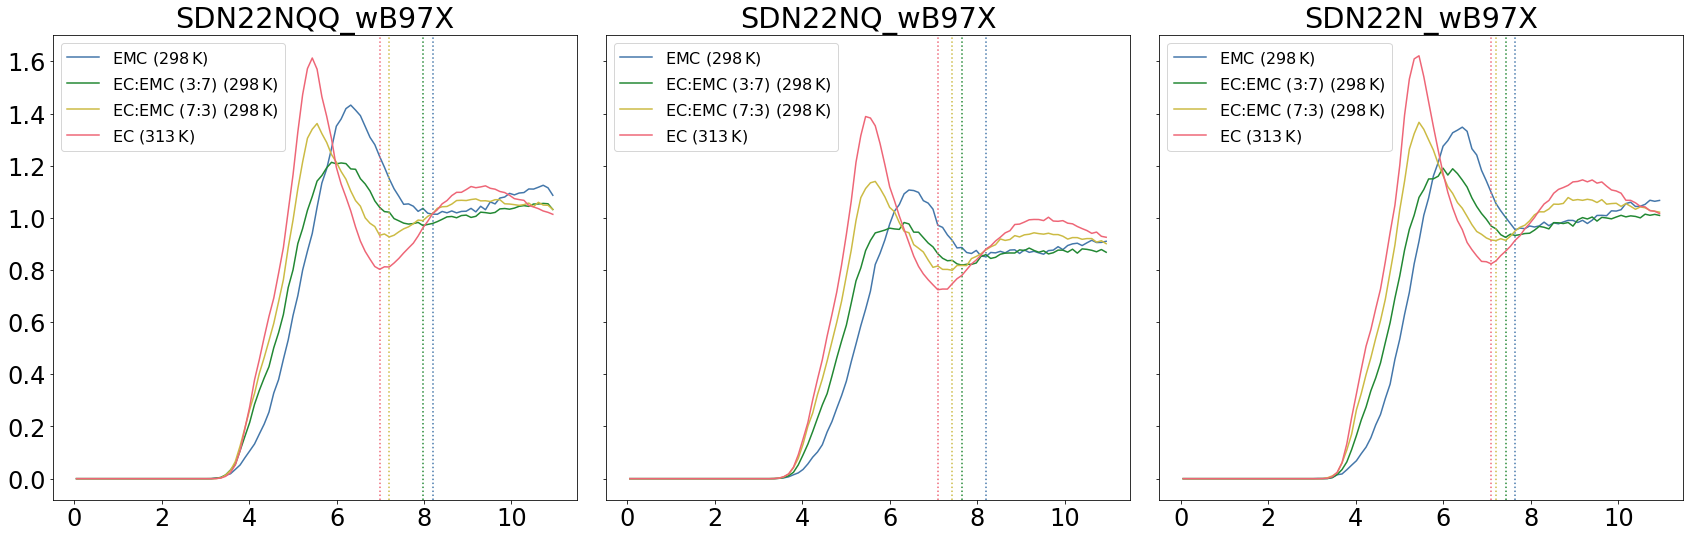

In [241]:
plt.rcParams.update({'font.size': fsize})


rstart = 6
id_width = 20

radii = []
fig, axs = plt.subplots(1,3, figsize=(3*8,1*8), sharey=True)
for ax, (model,dsets) in zip(axs, rdfs.items()):
    ax.set_title(model)
    #print(model)
    for dset,seeds in dsets.items():
        #print(dset)
        if dset == 'DSET1':
            for seed,comps in seeds.items():
                if seed == 'SEED1':
                    #print(seed)
                    for comp, (g, r) in comps.items():
                        #print(comp)
                        id0 = np.where(r>rstart)[0][0]
                        #print(id0, r[id0])
                        
                        idhi = id0+id_width
                        rmin = min(r[id0:idhi])
                        idx = np.argmin(g[id0:idhi])
                        #print(idx, r[idx])

                        ax.axvline(r[id0+idx], 0, 1, color=get_colour(comp), alpha=1, linestyle='dotted')
                        #ax.axvspan(r[id0], r[idhi],alpha=0.05, color='gray')
                        ax.plot(r, g, label=comp, color=get_colour(comp))
                        ax.legend(fontsize=fsize-8)
                        
                        rho = number_densities[model][dset][seed][comp]
                        r_prime = r[:id0+idx]
                        g_prime = g[1:id0+idx]                        
                        v_shell = 4/3*np.pi*(r_prime[1:]**3-r_prime[:-1]**3)
                        N = sum(g_prime*v_shell*rho)
                        
                        train_data, functional = model.split('_')
                        radii.append([train_data, functional, seed, dset, comp, r[id0+idx], N])
plt.tight_layout()

radii_df = pd.DataFrame(radii, columns=['Train data', 'Functional', 'Seed', 'Sample', 'Composition', 'Rmin', 'CN'])
for name, group in radii_df.groupby('Train data'):
    print('Average first shell coordinations:')
    print(name, group['CN'].mean(), '\n')
radii_df

Data set 2

Average first shell coordinations:
SDN22NQ 9.405058213582993 

Average first shell coordinations:
SDN22NQQ 10.482957232480569 



,Train data,Functional,Seed,Sample,Composition,Rmin,CN
0,SDN22NQQ,wB97X,SEED1,DSET2,"EMC (298$\,$K)",7.975,10.874989
1,SDN22NQQ,wB97X,SEED1,DSET2,"EC:EMC (3:7) (298$\,$K)",7.645,10.580066
2,SDN22NQQ,wB97X,SEED1,DSET2,"EC:EMC (7:3) (298$\,$K)",6.985,8.938437
3,SDN22NQQ,wB97X,SEED1,DSET2,"EC (313$\,$K)",7.205,11.538336
4,SDN22NQ,wB97X,SEED1,DSET2,"EMC (298$\,$K)",7.755,8.640036
5,SDN22NQ,wB97X,SEED1,DSET2,"EC:EMC (3:7) (298$\,$K)",7.535,8.955632
6,SDN22NQ,wB97X,SEED1,DSET2,"EC:EMC (7:3) (298$\,$K)",7.315,9.419617
7,SDN22NQ,wB97X,SEED1,DSET2,"EC (313$\,$K)",7.205,10.604948


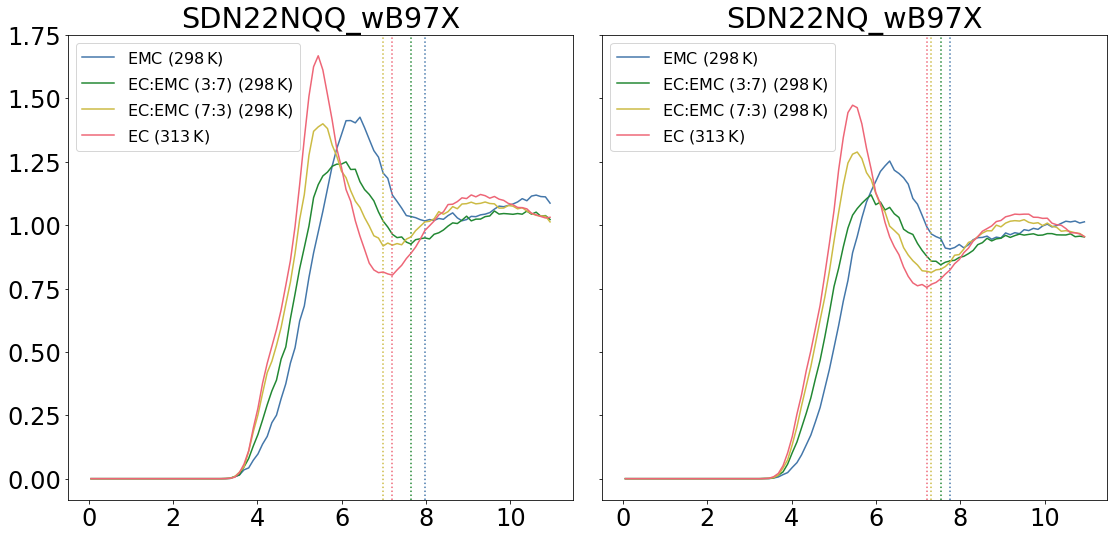

In [242]:
plt.rcParams.update({'font.size': fsize})


rstart = 6
id_width = 20

radii = []
fig, axs = plt.subplots(1,2, figsize=(2*8,1*8), sharey=True)
for ax, (model,dsets) in zip(axs, rdfs.items()):
    ax.set_title(model)
    #print(model)
    for dset,seeds in dsets.items():
        #print(dset)
        if dset == 'DSET2':
            for seed,comps in seeds.items():
                if seed == 'SEED1':
                    #print(seed)
                    for comp, (g, r) in comps.items():
                        #print(comp)
                        id0 = np.where(r>rstart)[0][0]
                        #print(id0, r[id0])
                        
                        idhi = id0+id_width
                        rmin = min(r[id0:idhi])
                        idx = np.argmin(g[id0:idhi])
                        #print(idx, r[idx])

                        ax.axvline(r[id0+idx], 0, 1, color=get_colour(comp), alpha=1, linestyle='dotted')
                        #ax.axvspan(r[id0], r[idhi],alpha=0.05, color='gray')
                        ax.plot(r, g, label=comp, color=get_colour(comp))
                        ax.legend(fontsize=fsize-8)
                        
                        rho = number_densities[model][dset][seed][comp]
                        r_prime = r[:id0+idx]
                        g_prime = g[1:id0+idx]                        
                        v_shell = 4/3*np.pi*(r_prime[1:]**3-r_prime[:-1]**3)
                        N = sum(g_prime*v_shell*rho)
                        
                        train_data, functional = model.split('_')
                        radii.append([train_data, functional, seed, dset, comp, r[id0+idx], N])
plt.tight_layout()

radii_df = pd.DataFrame(radii, columns=['Train data', 'Functional', 'Seed', 'Sample', 'Composition', 'Rmin', 'CN'])
for name, group in radii_df.groupby('Train data'):
    print('Average first shell coordinations:')
    print(name, group['CN'].mean(), '\n')
radii_df

Data set 3

Average first shell coordinations:
SDN22NQ 8.589126958227917 

Average first shell coordinations:
SDN22NQQ 9.438222583975314 



,Train data,Functional,Seed,Sample,Composition,Rmin,CN
0,SDN22NQQ,wB97X,SEED1,DSET3,"EMC (298$\,$K)",7.645,9.248210
1,SDN22NQQ,wB97X,SEED1,DSET3,"EC:EMC (3:7) (298$\,$K)",7.535,9.818787
2,SDN22NQQ,wB97X,SEED1,DSET3,"EC:EMC (7:3) (298$\,$K)",6.985,8.573834
3,SDN22NQQ,wB97X,SEED1,DSET3,"EC (313$\,$K)",6.985,10.112060
4,SDN22NQ,wB97X,SEED1,DSET3,"EMC (298$\,$K)",7.645,7.089897
5,SDN22NQ,wB97X,SEED1,DSET3,"EC:EMC (3:7) (298$\,$K)",7.535,7.936168
6,SDN22NQ,wB97X,SEED1,DSET3,"EC:EMC (7:3) (298$\,$K)",7.535,9.446713
7,SDN22NQ,wB97X,SEED1,DSET3,"EC (313$\,$K)",7.205,9.883730


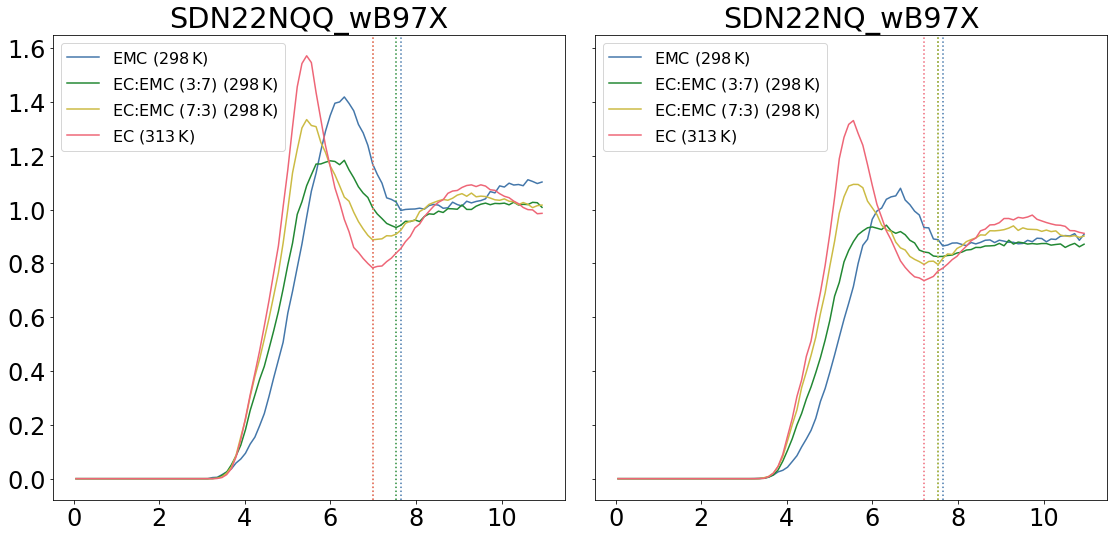

In [243]:
plt.rcParams.update({'font.size': fsize})


rstart = 6
id_width = 20

radii = []
fig, axs = plt.subplots(1,2, figsize=(2*8,1*8), sharey=True)
for ax, (model,dsets) in zip(axs, rdfs.items()):
    ax.set_title(model)
    #print(model)
    for dset,seeds in dsets.items():
        #print(dset)
        if dset == 'DSET3':
            for seed,comps in seeds.items():
                if seed == 'SEED1':
                    #print(seed)
                    for comp, (g, r) in comps.items():
                        #print(comp)
                        id0 = np.where(r>rstart)[0][0]
                        #print(id0, r[id0])
                        
                        idhi = id0+id_width
                        rmin = min(r[id0:idhi])
                        idx = np.argmin(g[id0:idhi])
                        #print(idx, r[idx])

                        ax.axvline(r[id0+idx], 0, 1, color=get_colour(comp), alpha=1, linestyle='dotted')
                        #ax.axvspan(r[id0], r[idhi],alpha=0.05, color='gray')
                        ax.plot(r, g, label=comp, color=get_colour(comp))
                        ax.legend(fontsize=fsize-8)

                        rho = number_densities[model][dset][seed][comp]
                        r_prime = r[:id0+idx]
                        g_prime = g[1:id0+idx]                        
                        v_shell = 4/3*np.pi*(r_prime[1:]**3-r_prime[:-1]**3)
                        N = sum(g_prime*v_shell*rho)
                        
                        train_data, functional = model.split('_')
                        radii.append([train_data, functional, seed, dset, comp, r[id0+idx], N])
plt.tight_layout()

radii_df = pd.DataFrame(radii, columns=['Train data', 'Functional', 'Seed', 'Sample', 'Composition', 'Rmin', 'CN'])
for name, group in radii_df.groupby('Train data'):
    print('Average first shell coordinations:')
    print(name, group['CN'].mean(), '\n')
radii_df

# NPT dynamics, part B

In [215]:
tags = [
    'SDN22NQ/B97/SEED1/DSET1',
    'SDN22NQ/B97/SEED1/DSET2',
    'SDN22NQ/B97/SEED1/DSET3',
    #'SDN22NQ/B97/SEED2/DSET1', # this is missing, locally (Sams) only 100%EMC?
    #'SDN22NQ/B97/SEED3/DSET1', # this is missing, locally (Sams) only 100%EMC?
] # These tags needs to be adjusted to be compliant with zenodo

thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*') # Argument should be 'tag' to be consistent with zenodo

In [27]:
def get_start_index(time, msd, threshold, window, start_id=0):
    window = int(window)
    start_id = int(start_id)
    print(f'Using slope error thresold of: {threshold}')
    #time = time
    ids = {}
    for i, t in enumerate(time[start_id:]):
        if i > window:
            
            slope, intercept, err, r2 = get_slope(np.log(time[i:i+window]),np.log(msd[i:i+window]))
            if abs(slope-1) < threshold:
                #print(f'{slope:.1f}')
                ids[start_id+i] = r2
    idx, r2 = max(ids.items(), key=lambda x: x[1])
    return idx, r2

In [28]:
diff_coeffs = []
diff_errs = []
log_r2 = []
diff_r2 = []
diff_starts = []
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):

        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']
        
        #idx, r2 = get_start_index(time,msd,threshold=1e-2, min_steps=5e3)
        idx, r2 = get_start_index(time,msd,threshold=5e-2, window=2000, start_id=0)
        if idx != None:   
            D, err, R2 = diffusion_coefficient(time[idx:],msd[idx:])
            diff_coeffs.append(D)
            diff_errs.append(err)
            log_r2.append(r2)
            diff_r2.append(R2)
            print(idx, len(time), r2, D, err, R2)
            diff_starts.append(idx)
        else:
            diff_coeffs.append(np.nan)
            diff_errs.append(np.nan)
            log_r2.append(np.nan)
            diff_r2.append(np.nan)
            diff_starts.append(np.nan)

Using slope error thresold of: 0.05


/home/viktor/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/viktor/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/viktor/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


2350 99997 0.9419523513618971 7.938574631473244e-10 2.6495068298017393e-12 0.9921966098380063
Using slope error thresold of: 0.05
6879 99999 0.8842984489250812 3.9106333275564606e-10 1.3545095842159064e-12 0.991986918093443
Using slope error thresold of: 0.05
3872 99999 0.8965813260909007 3.686740876266006e-10 1.4567181865715914e-12 0.989264922127717
Using slope error thresold of: 0.05
16256 99998 0.820733805309111 4.100771692477695e-10 2.2935694335114627e-12 0.9814106128765567
Using slope error thresold of: 0.05
4219 99999 0.9910631484595882 3.2488820339708034e-09 1.1736318408471294e-11 0.9910433697293163
Using slope error thresold of: 0.05
3226 99999 0.9470414135341269 2.056696414028338e-09 6.981491738305433e-12 0.9920015815376669
Using slope error thresold of: 0.05
2653 99999 0.9714574906553415 1.7324873344882898e-09 3.7442598688431905e-12 0.9967230784156568
Using slope error thresold of: 0.05
9173 99999 0.9717189271062471 1.6008161506030396e-09 7.303695585827767e-12 0.9865136055138

In [216]:
pkl_name = './part3b_B97_results.pkl'
try:
    bf = pd.read_pickle(pkl_name)
except:
    bf, dunit = get_density(tags, dynamics_path, std=True)
    bf['Diffusion coefficient'] = [d*1e10 for d in diff_coeffs] # 1e-6 cm2/s
    #bf['Corr. diffusion coefficient'] = [fsize_correction(D,r) for D,r in df[['Diffusion coefficient', 'Avg. density']]]
    bf['Diff. fit error'] = [e*1e10 for e in diff_errs] # 1e-6 cm2/s
    bf['log-log r2'] = log_r2
    bf['Diff. r2'] = diff_r2
    bf['Diff. start time /ns'] = [time[s]*1e-6 if type(s) == int else np.nan for s in diff_starts]
    pd.to_pickle(bf, pkl_name)
bf.style.applymap(rvalue_formatting, subset=['log-log r2', 'Diff. r2'])

/tmp/ipykernel_752548/3073170483.py:13: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  bf.style.applymap(rvalue_formatting, subset=['log-log r2', 'Diff. r2'])


,Train data,Functional,Seed,Sample,Composition,Temperature,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,log-log r2,Diff. r2,Diff. start time /ns
0,SDN22NQ,B97,1,1,EMC,298,1.040879,0.015715,7.938575,0.026495,0.941952,0.992197,0.023500
1,SDN22NQ,B97,1,1,EC:EMC (3:7),298,1.112943,0.015171,3.910633,0.013545,0.884298,0.991987,0.068790
2,SDN22NQ,B97,1,1,EC:EMC (7:3),298,1.194697,0.014892,3.686741,0.014567,0.896581,0.989265,0.038720
3,SDN22NQ,B97,1,1,EC,313,1.280443,0.018938,4.100772,0.022936,0.820734,0.981411,0.162560
4,SDN22NQ,B97,1,2,EMC,298,0.845267,0.021027,32.488820,0.117363,0.991063,0.991043,0.042190
5,SDN22NQ,B97,1,2,EC:EMC (3:7),298,0.919407,0.020792,20.566964,0.069815,0.947041,0.992002,0.032260
6,SDN22NQ,B97,1,2,EC:EMC (7:3),298,1.008562,0.018139,17.324873,0.037443,0.971457,0.996723,0.026530
7,SDN22NQ,B97,1,2,EC,313,1.114161,0.020028,16.008162,0.073037,0.971719,0.986514,0.091730
8,SDN22NQ,B97,1,3,EMC,298,0.818457,0.024260,33.994549,0.087789,0.948939,0.995772,0.119510
9,SDN22NQ,B97,1,3,EC:EMC (3:7),298,0.905670,0.024174,28.653041,0.101799,0.980327,0.991187,0.025830


/tmp/ipykernel_752548/1711649601.py:28: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[i].set_ylim([0, 1000])


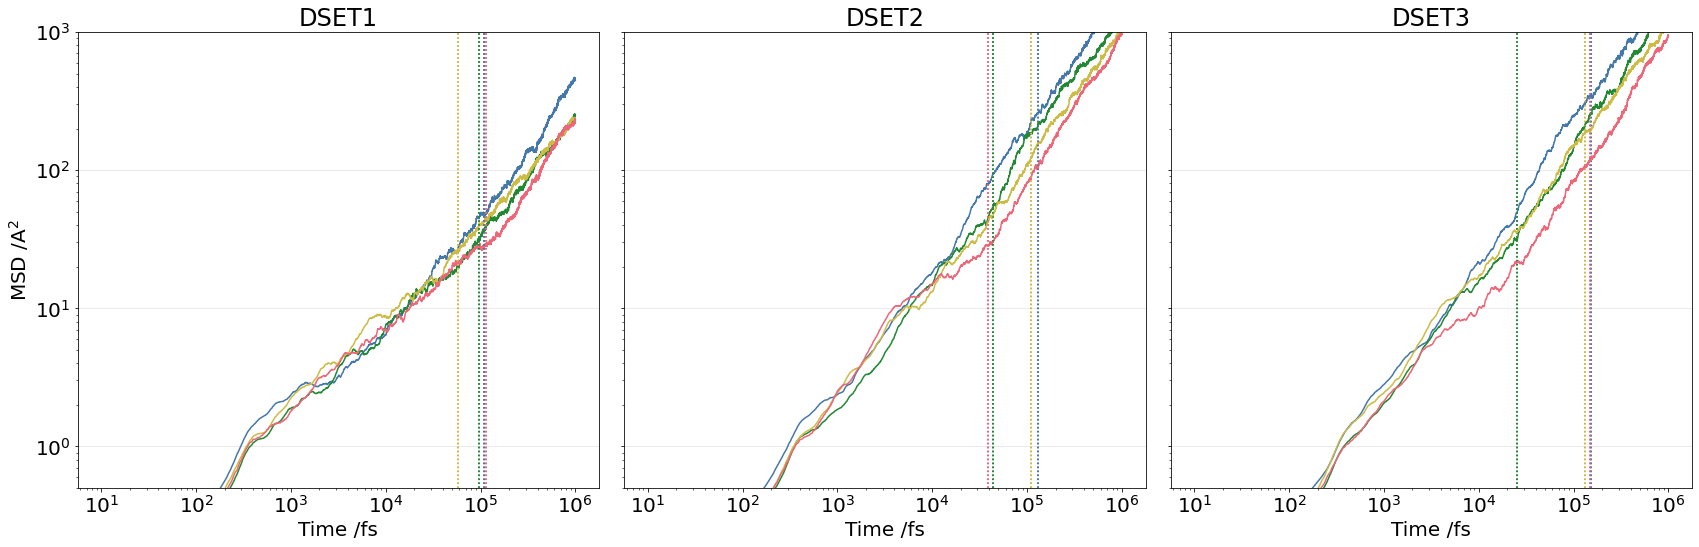

In [ ]:
plt.rcParams.update({'font.size': fsize})

order = [
    'EMC',
    'EC:EMC (3:7)', 
    'EC:EMC (7:3)',
    'EC',
]




fig, axs = plt.subplots(1,len(tags), figsize=(8*len(tags), 8*1), sharex=True, sharey=True)
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        # Plot density
        axs[i].set_ylim([0.5, 1.4])
        

        # Plot MSD
        axs[i].set_ylim([0, 1000])
        axs[0].set_ylabel(f'MSD /{munit}')
        axs[i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        axs[i].set_xscale('log')
        axs[i].set_yscale('log')

        axs[0].axvline(df['Diff. start time /ns'].iloc[j]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        axs[1].axvline(df['Diff. start time /ns'].iloc[j+4]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        axs[2].axvline(df['Diff. start time /ns'].iloc[j+8]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')

        # Shared plot setings
        #axs[i].set_title(f'{data_set}_{functional}')
        axs[i].set_title(dset_sample)
        axs[i].set_xlabel(f'Time /{tunit}')
        axs[i].grid(axis='y', alpha=0.3)
        

#axs[-1,-1].legend(loc='upper left')


plt.tight_layout()

In [33]:
BF = bf.copy()
BF[['log-log r2', 'Diff. r2']] = BF[['log-log r2', 'Diff. r2']].applymap(rvalue_formatting_latex)

/tmp/ipykernel_752548/3633192499.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  BF[['log-log r2', 'Diff. r2']] = BF[['log-log r2', 'Diff. r2']].applymap(rvalue_formatting_latex)


In [35]:
print(BF.to_latex(escape=False, index=False))

\begin{tabular}{llrrllrrrrllr}
\toprule
Train data & Functional & Seed & Sample & Composition & Temperature & Avg. density & Std. density & Diffusion coefficient & Diff. fit error & log-log r2 & Diff. r2 & Diff. start time /ns \\
\midrule
SDN22NQ & B97 & 1 & 1 & EMC & 298 & 1.040879 & 0.015715 & 7.938575 & 0.026495 & \color{YELLOW}0.9419 & 0.9921 & 0.023500 \\
SDN22NQ & B97 & 1 & 1 & EC:EMC (3:7) & 298 & 1.112943 & 0.015171 & 3.910633 & 0.013545 & \color{ORANGE}0.8842 & 0.9919 & 0.068790 \\
SDN22NQ & B97 & 1 & 1 & EC:EMC (7:3) & 298 & 1.194697 & 0.014892 & 3.686741 & 0.014567 & \color{ORANGE}0.8965 & 0.9892 & 0.038720 \\
SDN22NQ & B97 & 1 & 1 & EC & 313 & 1.280443 & 0.018938 & 4.100772 & 0.022936 & \color{ORANGE}0.8207 & 0.9814 & 0.162560 \\
SDN22NQ & B97 & 1 & 2 & EMC & 298 & 0.845267 & 0.021027 & 32.488820 & 0.117363 & 0.9910 & 0.9910 & 0.042190 \\
SDN22NQ & B97 & 1 & 2 & EC:EMC (3:7) & 298 & 0.919407 & 0.020792 & 20.566964 & 0.069815 & \color{YELLOW}0.9470 & 0.9920 & 0.032260 \\
SDN

## Results
### Densities

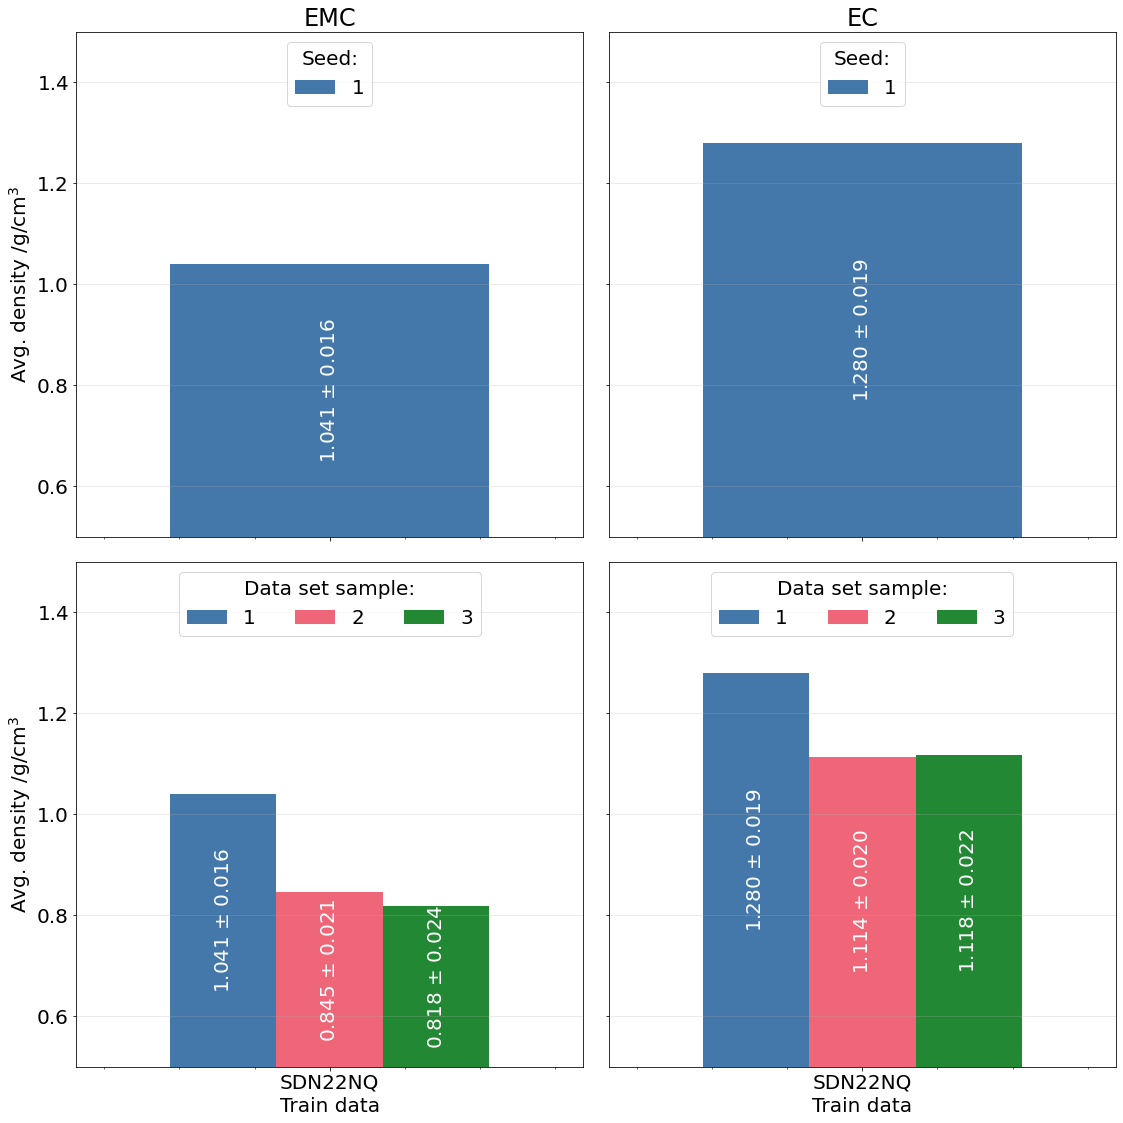

In [37]:
fsize = 20
plt.rcParams.update({'font.size': fsize})


comps = [
    'EMC',
    #'EC:EMC (3:7)', 
    #'EC:EMC (7:3)',
    'EC',
]


fig, axs = plt.subplots(2,2, figsize=(8*2, 8*2), sharey='row', sharex='col')

EMC_mask = bf['Composition'] == comps[0]
EC_mask = bf['Composition'] == comps[-1]
EC_EMC_df = bf[EC_mask | EMC_mask]

seed_df = EC_EMC_df[EC_EMC_df['Sample'] == 1]
for ax, (n,g) in zip(axs[0,:], reversed(list(seed_df.groupby('Composition')))):
    avg_g = g.pivot(
        index='Train data',
        columns='Seed',
        values='Avg. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    std_g = g.pivot(
        index='Train data',
        columns='Seed',
        values='Std. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    a0 = avg_g.plot.bar(
        title=n,
        ylim=[0.5,1.5],
        ylabel=f'Avg. density /{dunit}',
        rot=0,
        width=0.85,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    ax.legend(title='Seed:', ncols=3, loc='upper center', fontsize=fsize)

    for i, c in enumerate(a0.containers):
        col_name = avg_g.columns[i]
        dens_vals = avg_g[col_name]
        dens_errs = std_g[col_name]
        dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]
        ax.bar_label(c, rotation=90, fontsize=fsize, label_type='center', padding=10, labels=dens_labels, color='white')

sample_df = EC_EMC_df[EC_EMC_df['Seed'] == 1]
for ax, (n,g) in zip(axs[1,:], reversed(list(sample_df.groupby('Composition')))):
    avg_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Avg. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    std_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Std. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    a1 = avg_g.plot.bar(
        ylim=[0.5,1.5],
        ylabel=f'Avg. density /{dunit}',
        #color=cset[3:],
        rot=0,
        width=0.85,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    ax.legend(title='Data set sample:', ncols=3, loc='upper center', fontsize=fsize)

    #for c in a1.containers:
    #    ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', fmt='%.3f', padding=10)
    for i, c in enumerate(a1.containers):
        col_name = avg_g.columns[i]
        dens_vals = avg_g[col_name]
        dens_errs = std_g[col_name]
        dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]
        ax.bar_label(c, rotation=90, fontsize=fsize, label_type='center', padding=10, labels=dens_labels, color='white')

plt.tight_layout()

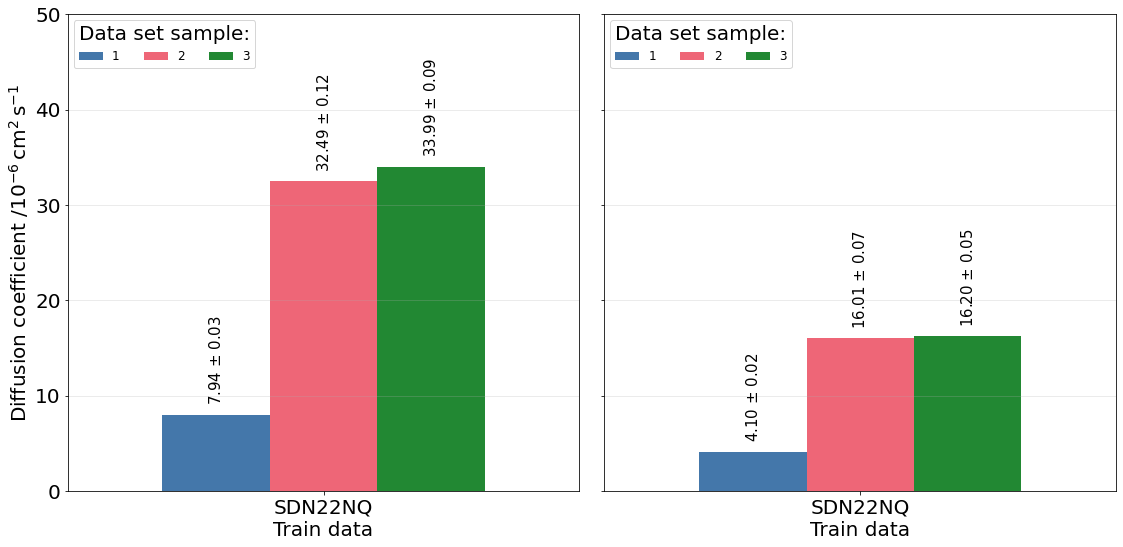

In [38]:
fsize = 20
plt.rcParams.update({'font.size': fsize})


comps = [
    'EMC',
    #'EC:EMC (3:7)', 
    #'EC:EMC (7:3)',
    'EC',
]


fig, axs = plt.subplots(1,2, figsize=(8*2, 8*1), sharey='row', sharex='col')

EMC_mask = bf['Composition'] == comps[0]
EC_mask = bf['Composition'] == comps[-1]
EC_EMC_df = bf[EC_mask | EMC_mask]

sample_df = EC_EMC_df[EC_EMC_df['Seed'] == 1]
for ax, (n,g) in zip(axs, reversed(list(sample_df.groupby('Composition')))):
    D_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Diffusion coefficient',
    )#.sort_index(axis=0,ascending=False)#[order]
    err_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Diff. fit error',
    )#.sort_index(axis=0,ascending=False)#[order]
    a1 = D_g.plot.bar(
        ylim=[0,50],
        ylabel=f'Diffusion coefficient /$10^{{-6}}\\,\\text{{cm}}^2\\,\\text{{s}}^{{-1}}$',
        #color=cset[3:],
        rot=0,
        width=0.85,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    ax.legend(title='Data set sample:', ncols=3, loc='upper left', fontsize=fsize-8)

    #for c in a1.containers:
    #    ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', fmt='%.3f', padding=10)
    for i, c in enumerate(a1.containers):
        col_name = D_g.columns[i]
        diff_vals = D_g[col_name]
        diff_erros = err_g[col_name]
        diff_labels = [f'{v:.2f} $\\pm$ {e:.2f}' for v, e in zip(diff_vals, diff_erros)]
        ax.bar_label(c, rotation=90, fontsize=fsize-5, label_type='edge', padding=10, labels=diff_labels, color='black')

plt.tight_layout()

In [231]:
drop_list = ['Seed', 'Sample', 'log-log r2', 'Diff. r2']
SD22NQ_B97_df = reduce_df(bf[bf['Train data'] == 'SDN22NQ'], drop_list)
SD22NQ_B97_df

,Composition,Train data,Functional,Temperature,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,Diff. start time /ns
0,EC,SDN22NQ,B97,313,1.171017,0.011830,12.103789,0.031202,0.095443
1,EC:EMC (3:7),SDN22NQ,B97,298,0.979340,0.011770,17.710213,0.041393,0.042293
2,EC:EMC (7:3),SDN22NQ,B97,298,1.066945,0.010709,13.321529,0.026599,0.030050
3,EMC,SDN22NQ,B97,298,0.901534,0.011915,24.807315,0.049647,0.061733


#### Diffusion corrections
For the diffusion data, we first need to compute the correction coefficients used by [Schrodinger SI, equ 5](https://pubs.acs.org/doi/suppl/10.1021/acs.jpcb.2c03746/suppl_file/jp2c03746_si_001.pdf) and [Bamboo, equ 61](https://arxiv.org/pdf/2404.07181), quoting [standard practice, equ 3](https://livecomsjournal.org/index.php/livecoms/article/view/v1i1e6324/937).
$$
D(\infty)=D(L)+\frac{2.837298\times k_BT}{6\pi \eta L}
$$
Box sizes are computed from number of molecules (table S1) and densities (table S2) from Schrodinger, temperatures are taken from table S1 and viscosity from table S3.

<!---
The Arrhenius model of mixing states that the viscosity, $\eta$, of a liquid mixture is
$$
\ln\eta_\text{mix} = \sum_{i=0}^N x_i \ln \eta_i
$$
where $N$ is the number of components and $x_i$ is the mole fraction associated with component $i$.

Based on: https://www.frontiersin.org/journals/energy-research/articles/10.3389/fenrg.2022.1074699/full, the expected error associated with a binary mixture of hydrocarbons is around 5%, with a standard deviation of 6% of that. Thus the mixtures should carry an additional 0.3% uncertainty.
-->

Obtain sample masses:

In [99]:
import ase.units

mass_thermo = get_all_thermo(f'{dynamics_path}{tags[-1]}/*', xyz=True) # Argument should be 'tag' to be consistent with zenodo

for comp, traj in mass_thermo.items():
    if '000conEC' in comp:
        print('Pure EMC:')
        M_EMC = traj[0].get_masses().sum() # u=g/mol
        m_EMC = M_EMC/ase.units.mol*1e-3 # g/mol*mol/1000=kg
        print(f'Total mass:\t{m_EMC} kg')
    elif '100conEC' in comp:
        print('Pure EC:')
        M_EC = traj[0].get_masses().sum() # u=g/mol
        m_EC = M_EC/ase.units.mol*1e-3 # g/mol*mol/1000=kg
        print(f'Total mass:\t{m_EC} kg')

Pure EMC:
Total mass:	1.1582317925845882e-23 kg
Pure EC:
Total mass:	1.462303889780969e-23 kg


Obtain and apply correction:

In [232]:
corr_df = bf.copy()
#corr_df = corr_df.drop('Train data', axis=1)
#corr_df = corr_df.drop('log-log r2', axis=1)
#corr_df = corr_df.drop('Diff. r2', axis=1) 
#corr_df = corr_df.drop('Diff. start time /ns', axis=1)
corr_df = corr_df[(corr_df['Composition'] == 'EMC') | (corr_df['Composition'] == 'EC')]
corr_df

eta_EC = 1.9e-3 # Pa s
eta_EMC = 0.65e-3 # Pa s
kB = ase.units.kB/ase.units.J
xi = 2.837298
print(f'EMC viscosity:\t{eta_EMC} Pa s (at 298 K)')
print(f'EC viscosity:\t{eta_EC} Pa s (at 313 K)')
print(f'kB:\t\t{kB} J\n')

for tag, data in thermo.items():
    print(tag)
    data_set, functional, seed, dset = tag.split('/')
    
    for comp, traj in data.items():
        temp = int(comp.split('_')[-1][:-1])
        if '300K' in comp:
            dens = traj['v_mdensity']['data'].mean()*1000 # kg/m3
        else:
            dens = traj['Density']['data'].mean()*1000 # kg/m3
        if '000conEC' in comp:
            print('EMC:')
            k = 1
            total_mass = m_EMC
            eta = eta_EMC

        elif '100conEC' in comp:
            print('EC:')
            k = 1
            total_mass = m_EC
            eta = eta_EC
        else:
            k = 0
        
        volume = total_mass/dens # m3
        L = volume**(1/3) # m
        corr = k*xi*kB*temp/(6*np.pi*eta*L) # kT=[J]=[Pa m3] => Pa m3/(Pa s m)=m2/s
        corr *= 1e10 # 1e-6 cm2/s
        if corr > 0:
            print(f'Box length:\t{L*1e10:.3f} Å')
            print(f'Correction:\t{corr:.3f} 1e-6cm2/s\n')

        #func_mask = corr_df['Functional'] == functional
        comp_mask = corr_df['Composition'] == tmap[comp]  
        seed_mask = corr_df['Seed'] == int(seed[-1])
        dset_mask = corr_df['Sample'] == int(dset[-1])
        print(corr_df.loc[comp_mask & seed_mask & dset_mask, 'Diffusion coefficient'])
        corr_df.loc[comp_mask & seed_mask & dset_mask, 'Diffusion coefficient'] += corr
corr_df

EMC viscosity:	0.00065 Pa s (at 298 K)
EC viscosity:	0.0019 Pa s (at 313 K)
kB:		1.38064852e-23 J

SDN22NQ/B97/SEED1/DSET1
EMC:
Box length:	22.325 Å
Correction:	4.268 1e-6cm2/s

0    7.938575
Name: Diffusion coefficient, dtype: float64
Series([], Name: Diffusion coefficient, dtype: float64)
Series([], Name: Diffusion coefficient, dtype: float64)
EC:
Box length:	22.520 Å
Correction:	1.520 1e-6cm2/s

3    4.100772
Name: Diffusion coefficient, dtype: float64
SDN22NQ/B97/SEED1/DSET2
EMC:
Box length:	23.930 Å
Correction:	3.982 1e-6cm2/s

4    32.48882
Name: Diffusion coefficient, dtype: float64
Series([], Name: Diffusion coefficient, dtype: float64)
Series([], Name: Diffusion coefficient, dtype: float64)
EC:
Box length:	23.588 Å
Correction:	1.451 1e-6cm2/s

7    16.008162
Name: Diffusion coefficient, dtype: float64
SDN22NQ/B97/SEED1/DSET3
EMC:
Box length:	24.188 Å
Correction:	3.939 1e-6cm2/s

8    33.994549
Name: Diffusion coefficient, dtype: float64
Series([], Name: Diffusion coefficient, 

,Train data,Functional,Seed,Sample,Composition,Temperature,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,log-log r2,Diff. r2,Diff. start time /ns
0,SDN22NQ,B97,1,1,EMC,298,1.040879,0.015715,12.206251,0.026495,0.941952,0.992197,0.02350
3,SDN22NQ,B97,1,1,EC,313,1.280443,0.018938,5.621034,0.022936,0.820734,0.981411,0.16256
4,SDN22NQ,B97,1,2,EMC,298,0.845267,0.021027,36.470405,0.117363,0.991063,0.991043,0.04219
7,SDN22NQ,B97,1,2,EC,313,1.114161,0.020028,17.459541,0.073037,0.971719,0.986514,0.09173
8,SDN22NQ,B97,1,3,EMC,298,0.818457,0.024260,37.933585,0.087789,0.948939,0.995772,0.11951
11,SDN22NQ,B97,1,3,EC,313,1.118447,0.022357,17.655673,0.053865,0.967682,0.992324,0.03204


#### Committee average

In [233]:
drop_list = ['Seed', 'Sample', 'log-log r2', 'Diff. r2']
SD22NQ_B97_corr_df = reduce_df(corr_df.copy()[corr_df['Train data'] == 'SDN22NQ'], drop_list)
SD22NQ_B97_corr_df

,Composition,Train data,Functional,Temperature,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,Diff. start time /ns
0,EC,SDN22NQ,B97,313,1.171017,0.011830,13.578749,0.031202,0.095443
1,EMC,SDN22NQ,B97,298,0.901534,0.011915,28.870080,0.049647,0.061733


## Latex tables for paper

In [45]:
def seed_density(df, composition,train_data):
    comp_mask = df['Composition'] == composition
    train_mask = df['Train data'] == train_data
    selection = df[comp_mask & train_mask]
    deviation = abs(selection['Avg. density'].min()-selection['Avg. density'].max())
    return deviation


configs = [
    'EMC',
    'EC:EMC (3:7)', 
    'EC:EMC (7:3)',
    'EC',
]

data = {
    'Seed pair':['SD22N', 'SD22NQ', 'SD22NQQ'],
}

for config in configs:
    SD22N_deviation = seed_density(df, config, 'SDN22N')
    SD22NQ_deviation = seed_density(df, config, 'SDN22NQ')
    SD22NQQ_deviation = seed_density(df, config, 'SDN22NQQ')
    data[config] = [
        SD22N_deviation,
        SD22NQ_deviation,
        SD22NQQ_deviation,
    ]
    print(f'SD22N deviations: {SD22N_deviation:.4f} g/mL')
    print(f'SD22NQ deviations: {SD22NQ_deviation:.4f} g/mL')
    print(f'SD22NQQ deviations: {SD22NQQ_deviation:.4f} g/mL\n')

seed_dens_df = pd.DataFrame(data).round(decimals=3)
print(seed_dens_df.to_latex(index=False))

SD22N deviations: 0.0908 g/mL
SD22NQ deviations: 0.1042 g/mL
SD22NQQ deviations: 0.2574 g/mL

SD22N deviations: 0.0945 g/mL
SD22NQ deviations: 0.0913 g/mL
SD22NQQ deviations: 0.2355 g/mL

SD22N deviations: 0.0913 g/mL
SD22NQ deviations: 0.0826 g/mL
SD22NQQ deviations: 0.1975 g/mL

SD22N deviations: 0.1102 g/mL
SD22NQ deviations: 0.0703 g/mL
SD22NQQ deviations: 0.1511 g/mL

\begin{tabular}{lrrrr}
\toprule
Seed pair & EMC & EC:EMC (3:7) & EC:EMC (7:3) & EC \\
\midrule
SD22N & 0.091000 & 0.095000 & 0.091000 & 0.110000 \\
SD22NQ & 0.104000 & 0.091000 & 0.083000 & 0.070000 \\
SD22NQQ & 0.257000 & 0.236000 & 0.197000 & 0.151000 \\
\bottomrule
\end{tabular}



In [46]:
def sample_density(df, composition,train_data):
    comp_mask = df['Composition'] == composition
    sample_mask = df['Seed'] == 1
    train_mask = df['Train data'] == train_data
    selection = df[comp_mask & train_mask]
    deviation = abs(selection['Avg. density'].min()-selection['Avg. density'].max())
    return deviation


configs = [
    'EMC',
    'EC:EMC (3:7)', 
    'EC:EMC (7:3)',
    'EC',
]

data = {
    #'Seed pair':['SD22NQ', 'SD22NQQ'],
    'Seed pair':['SD22NQ'],
}

for config in configs:
    #SD22N_deviation = seed_density(sample_df, config, 'SDN22N')
    SD22NQ_deviation = sample_density(df, config, 'SDN22NQ')
    SD22NQQ_deviation = sample_density(df, config, 'SDN22NQQ')
    data[config] = [
        #SD22N_deviation,
        SD22NQ_deviation,
        #SD22NQQ_deviation,
    ]
    print(config)
    #print(f'SD22N deviations: {SD22N_deviation:.4f} g/mL')
    print(f'SD22NQ deviations: {SD22NQ_deviation:.4f} g/mL')
    #print(f'SD22NQQ deviations: {SD22NQQ_deviation:.4f} g/mL\n')

seed_dens_df = pd.DataFrame(data).round(decimals=3)
#diff_df['Avg. error'] = diff_df.sum(axis=1, numeric_only=True)/len(diff_df.columns)
print(seed_dens_df.to_latex(index=False))

EMC
SD22NQ deviations: 0.1042 g/mL
EC:EMC (3:7)
SD22NQ deviations: 0.0913 g/mL
EC:EMC (7:3)
SD22NQ deviations: 0.0826 g/mL
EC
SD22NQ deviations: 0.0703 g/mL
\begin{tabular}{lrrrr}
\toprule
Seed pair & EMC & EC:EMC (3:7) & EC:EMC (7:3) & EC \\
\midrule
SD22NQ & 0.104000 & 0.091000 & 0.083000 & 0.070000 \\
\bottomrule
\end{tabular}



# NPT dynamics, part C

In [220]:
cf = pd.concat([SD22NQ_B97_df, SD22NQ_wB97_df])
cf

,Composition,Train data,Functional,Temperature,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,Diff. start time /ns
0,EC,SDN22NQ,B97,313,1.171017,0.011830,12.103789,0.031202,0.095443
1,EC:EMC (3:7),SDN22NQ,B97,298,0.979340,0.011770,17.710213,0.041393,0.042293
2,EC:EMC (7:3),SDN22NQ,B97,298,1.066945,0.010709,13.321529,0.026599,0.030050
3,EMC,SDN22NQ,B97,298,0.901534,0.011915,24.807315,0.049647,0.061733
0,EC,SDN22NQ,wB97X,313,1.239912,0.008359,8.793851,0.011624,0.041394
1,EC:EMC (3:7),SDN22NQ,wB97X,298,1.032804,0.009197,13.314893,0.022457,0.049718
2,EC:EMC (7:3),SDN22NQ,wB97X,298,1.130835,0.008155,9.856954,0.012524,0.044054
3,EMC,SDN22NQ,wB97X,298,0.946189,0.009395,20.577471,0.034215,0.066052


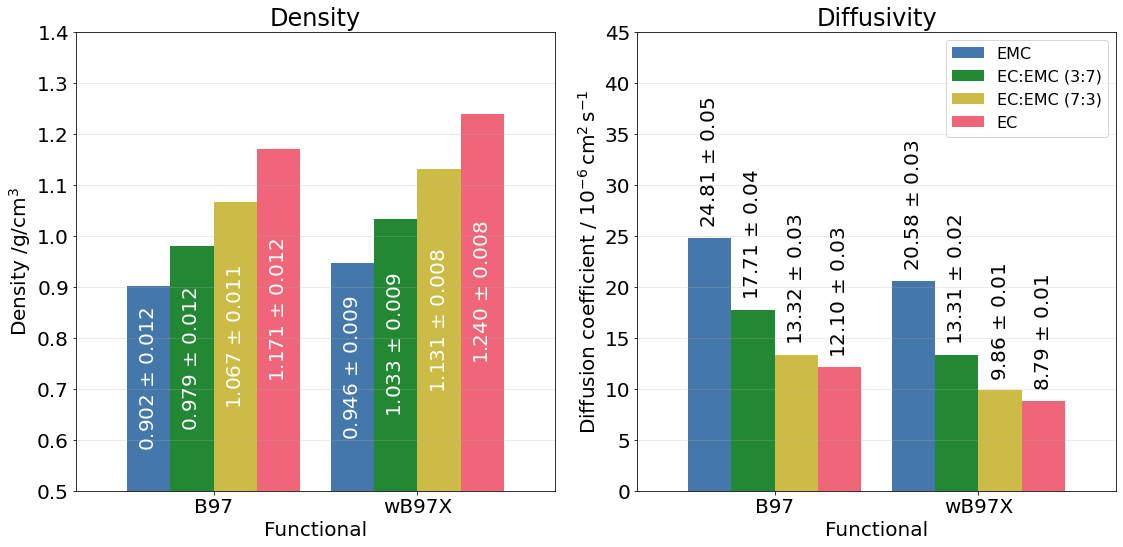

In [221]:
order = [
    'EMC',
    'EC:EMC (3:7)', 
    'EC:EMC (7:3)',
    'EC',
]

# Pivot tables for plotting

dens_df = cf.pivot(
	index='Functional',
	columns='Composition',
	values='Avg. density',
).sort_index(axis=0,ascending=True)[order]
dens_err_df = cf.pivot(
	index='Functional',
	columns='Composition',
	values='Std. density',
).sort_index(axis=0,ascending=True)[order]

diff_df = cf.pivot(
	index='Functional',
	columns='Composition',
	values='Diffusion coefficient',
).sort_index(axis=0,ascending=True)[order]
diff_err_df = cf.pivot(
	index='Functional',
	columns='Composition',
	values='Diff. fit error',
).sort_index(axis=0,ascending=True)[order]

fig, axs = plt.subplots(1,2, figsize=(8*2, 8*1), sharex=True, sharey=False)

a0 = dens_df.plot.bar(
    title='Density',
    ylim=[0.5,1.4],
    ylabel=f'Density /{dunit}',
    rot=0,
    width=0.85,
    color=[get_colour(o) for o in order],
    ax=axs[0],
    legend=False,
)
axs[0].grid(axis='y', alpha=0.3)
for i, c in enumerate(a0.containers):
    col_name = dens_df.columns[i]
    dens_vals = dens_df[col_name]
    dens_errors = dens_err_df[col_name]
    dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errors)]
    axs[0].bar_label(c, rotation=90, fontsize=fsize, label_type='center', padding=10, labels=dens_labels, color='white')


a1 = diff_df.plot.bar(
    title='Diffusivity',
    ylim=[0,45],
    ylabel=f'Diffusion coefficient / $10^{{-6}}\\,\\text{{cm}}^2\\,\\text{{s}}^{{-1}}$',
    rot=0,
    width=0.85,
    color=[get_colour(o) for o in order],
    ax=axs[1],
    legend=False,
)
axs[1].grid(axis='y', alpha=0.3)
axs[1].legend(loc='upper right', fontsize=fsize-4)
for i, c in enumerate(a1.containers):
    col_name = dens_df.columns[i]
    diff_vals = diff_df[col_name]
    diff_errors = diff_err_df[col_name]
    diff_labels = [f'{v:.2f} $\\pm$ {e:.2f}' for v, e in zip(diff_vals, diff_errors)]
    axs[1].bar_label(c, rotation=90, fontsize=fsize, label_type='edge', padding=10, labels=diff_labels, color='black')

plt.tight_layout()

In [234]:
corr_cf = pd.concat([SD22NQ_B97_corr_df, SD22NQ_wB97_corr_df])
corr_cf

,Composition,Train data,Functional,Temperature,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,Diff. start time /ns
0,EC,SDN22NQ,B97,313,1.171017,0.011830,13.578749,0.031202,0.095443
1,EMC,SDN22NQ,B97,298,0.901534,0.011915,28.870080,0.049647,0.061733
0,EC,SDN22NQ,wB97X,313,1.239912,0.008359,9.678827,0.011624,0.041394
1,EMC,SDN22NQ,wB97X,298,0.946189,0.009395,23.015131,0.034215,0.066052


Some latex output:

In [235]:
merged_df = corr_cf.copy()
merged_df['Density'] = (
    merged_df['Avg. density'].map("{:.3f}".format) + " ± " + merged_df['Std. density'].map("{:.3f}".format)
)
merged_df['Diffusion coefficient'] = (
    merged_df['Diffusion coefficient'].map("{:.3f}".format) + " ± " + merged_df['Diff. fit error'].map("{:.3f}".format)
)
merged_df = merged_df.drop(['Avg. density', 'Std. density', 'Diff. fit error'], axis=1)

In [236]:
merged_df = corr_cf.copy()
merged_df['Std. density'] *= 1000
merged_df['Diff. fit error'] *= 1000
merged_df['Density'] = (
    merged_df['Avg. density'].map("{:.3f}".format) + merged_df['Std. density'].map("({:.0f})".format)
)
merged_df['Diffusion coefficient'] = (
    merged_df['Diffusion coefficient'].map("{:.3f}".format) + merged_df['Diff. fit error'].map("({:.0f})".format)
)
merged_df = merged_df.drop(['Avg. density', 'Std. density', 'Diff. fit error'], axis=1)

In [237]:
cols = [
    'Composition',
    'Functional',
    'Temperature',
    'Density',
    'Diffusion coefficient'
]

dfs = []
for name, group in merged_df[cols].groupby('Composition'):
    dfs.append(group)

print(pd.concat(dfs).to_latex(index=False))

\begin{tabular}{lllll}
\toprule
Composition & Functional & Temperature & Density & Diffusion coefficient \\
\midrule
EC & B97 & 313 & 1.171(12) & 13.579(31) \\
EC & wB97X & 313 & 1.240(8) & 9.679(12) \\
EMC & B97 & 298 & 0.902(12) & 28.870(50) \\
EMC & wB97X & 298 & 0.946(9) & 23.015(34) \\
\bottomrule
\end{tabular}



In [238]:
cols = [
    'Composition',
    'Functional',
    'Temperature',
    'Density',
    'Diffusion coefficient'
]

dfs = []
for name, group in merged_df[cols].groupby('Composition'):
    dfs.append(group)

print(pd.concat(dfs).to_latex(index=False))

\begin{tabular}{lllll}
\toprule
Composition & Functional & Temperature & Density & Diffusion coefficient \\
\midrule
EC & B97 & 313 & 1.171(12) & 13.579(31) \\
EC & wB97X & 313 & 1.240(8) & 9.679(12) \\
EMC & B97 & 298 & 0.902(12) & 28.870(50) \\
EMC & wB97X & 298 & 0.946(9) & 23.015(34) \\
\bottomrule
\end{tabular}



## Latex tables for paper

In [172]:
bf

,Train data,Functional,Seed,Sample,Composition,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,log-log r2,Diff. r2,Diff. start time /ns
0,SDN22NQ,B97,1,1,"EMC (298$\,$K)",1.040879,0.015715,7.938575,0.026495,0.941952,0.992197,0.02350
1,SDN22NQ,B97,1,1,"EC:EMC (3:7) (298$\,$K)",1.112943,0.015171,3.910969,0.013536,0.878981,0.991995,0.06833
2,SDN22NQ,B97,1,1,"EC:EMC (7:3) (298$\,$K)",1.194697,0.014892,3.702312,0.014700,0.779476,0.989058,0.02945
3,SDN22NQ,B97,1,1,"EC (313$\,$K)",1.280443,0.018938,4.103129,0.022308,0.716613,0.982172,0.15074
4,SDN22NQ,B97,1,2,"EMC (298$\,$K)",0.845267,0.021027,32.473160,0.113064,0.983611,0.991518,0.02403
5,SDN22NQ,B97,1,2,"EC:EMC (3:7) (298$\,$K)",0.919407,0.020792,20.581719,0.069785,0.922499,0.992001,0.02992
6,SDN22NQ,B97,1,2,"EC:EMC (7:3) (298$\,$K)",1.008562,0.018139,17.326640,0.037330,0.953038,0.996738,0.02491
7,SDN22NQ,B97,1,2,"EC (313$\,$K)",1.114161,0.020028,15.959554,0.064962,0.896298,0.988581,0.03584
8,SDN22NQ,B97,1,3,"EMC (298$\,$K)",0.818457,0.024260,33.997580,0.077395,0.941220,0.996497,0.06189
9,SDN22NQ,B97,1,3,"EC:EMC (3:7) (298$\,$K)",0.905670,0.024174,28.640107,0.101420,0.972727,0.991222,0.02329


In [335]:
def functional_density(df, functional, composition):
    comp_mask = df['Composition'] == composition
    func_mask = df['Functional'] == functional
    selection = df[comp_mask & func_mask]['Avg. density']
    #return round(selection.iloc[0], precision)
    return selection.iloc[0]


configs = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

data = {
    'Functional pair':['\BNS and \wBNS'],
}

for config in configs:
    B97_dens = functional_density(cf, 'B97', config)
    wB97_dens = functional_density(cf, 'wB97X', config)
    data[config] = [abs(B97_dens-wB97_dens)]
    print(config)
    print(f'PBED3-B97D3 diff.: {abs(B97_dens-wB97_dens):.4f} g/mL\n')

dens_df = pd.DataFrame(data).round(decimals=3)
print(dens_df.to_latex(index=False))

IndexError: single positional indexer is out-of-bounds

In [747]:
def functional_diffusivity(df, functional, composition):
    comp_mask = df['Composition'] == composition
    func_mask = df['Functional'] == functional
    selection = df[comp_mask & func_mask]['Diffusion coefficient']
    return selection.iloc[0]


configs = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

data = {
    'Functional pair':['\BNS and \wBNS'],
}

for config in configs:
    B97_diff = functional_diffusivity(cf, 'B97', config)
    wB97_diff = functional_diffusivity(cf, 'wB97X', config)
    data[config] = [abs(B97_diff-wB97_diff)]
    print(config)
    print(f'B97-wB97 diff.: {abs(B97_diff-wB97_diff):.4f}*1e-6 cm2/s\n')

diff_df = pd.DataFrame(data).round(decimals=3)
print(diff_df.to_latex(index=False))

EMC (298$\,$K)
B97-wB97 diff.: 4.5051*1e-6 cm2/s

EC:EMC (3:7) (298$\,$K)
B97-wB97 diff.: 4.4154*1e-6 cm2/s

EC:EMC (7:3) (298$\,$K)
B97-wB97 diff.: 3.3657*1e-6 cm2/s

EC (313$\,$K)
B97-wB97 diff.: 3.2466*1e-6 cm2/s

\begin{tabular}{lrrrr}
\toprule
Functional pair & EMC (298$\,$K) & EC:EMC (3:7) (298$\,$K) & EC:EMC (7:3) (298$\,$K) & EC (313$\,$K) \\
\midrule
\BNS and \wBNS & 4.505000 & 4.415000 & 3.366000 & 3.247000 \\
\bottomrule
\end{tabular}



___
# Supplementary information

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


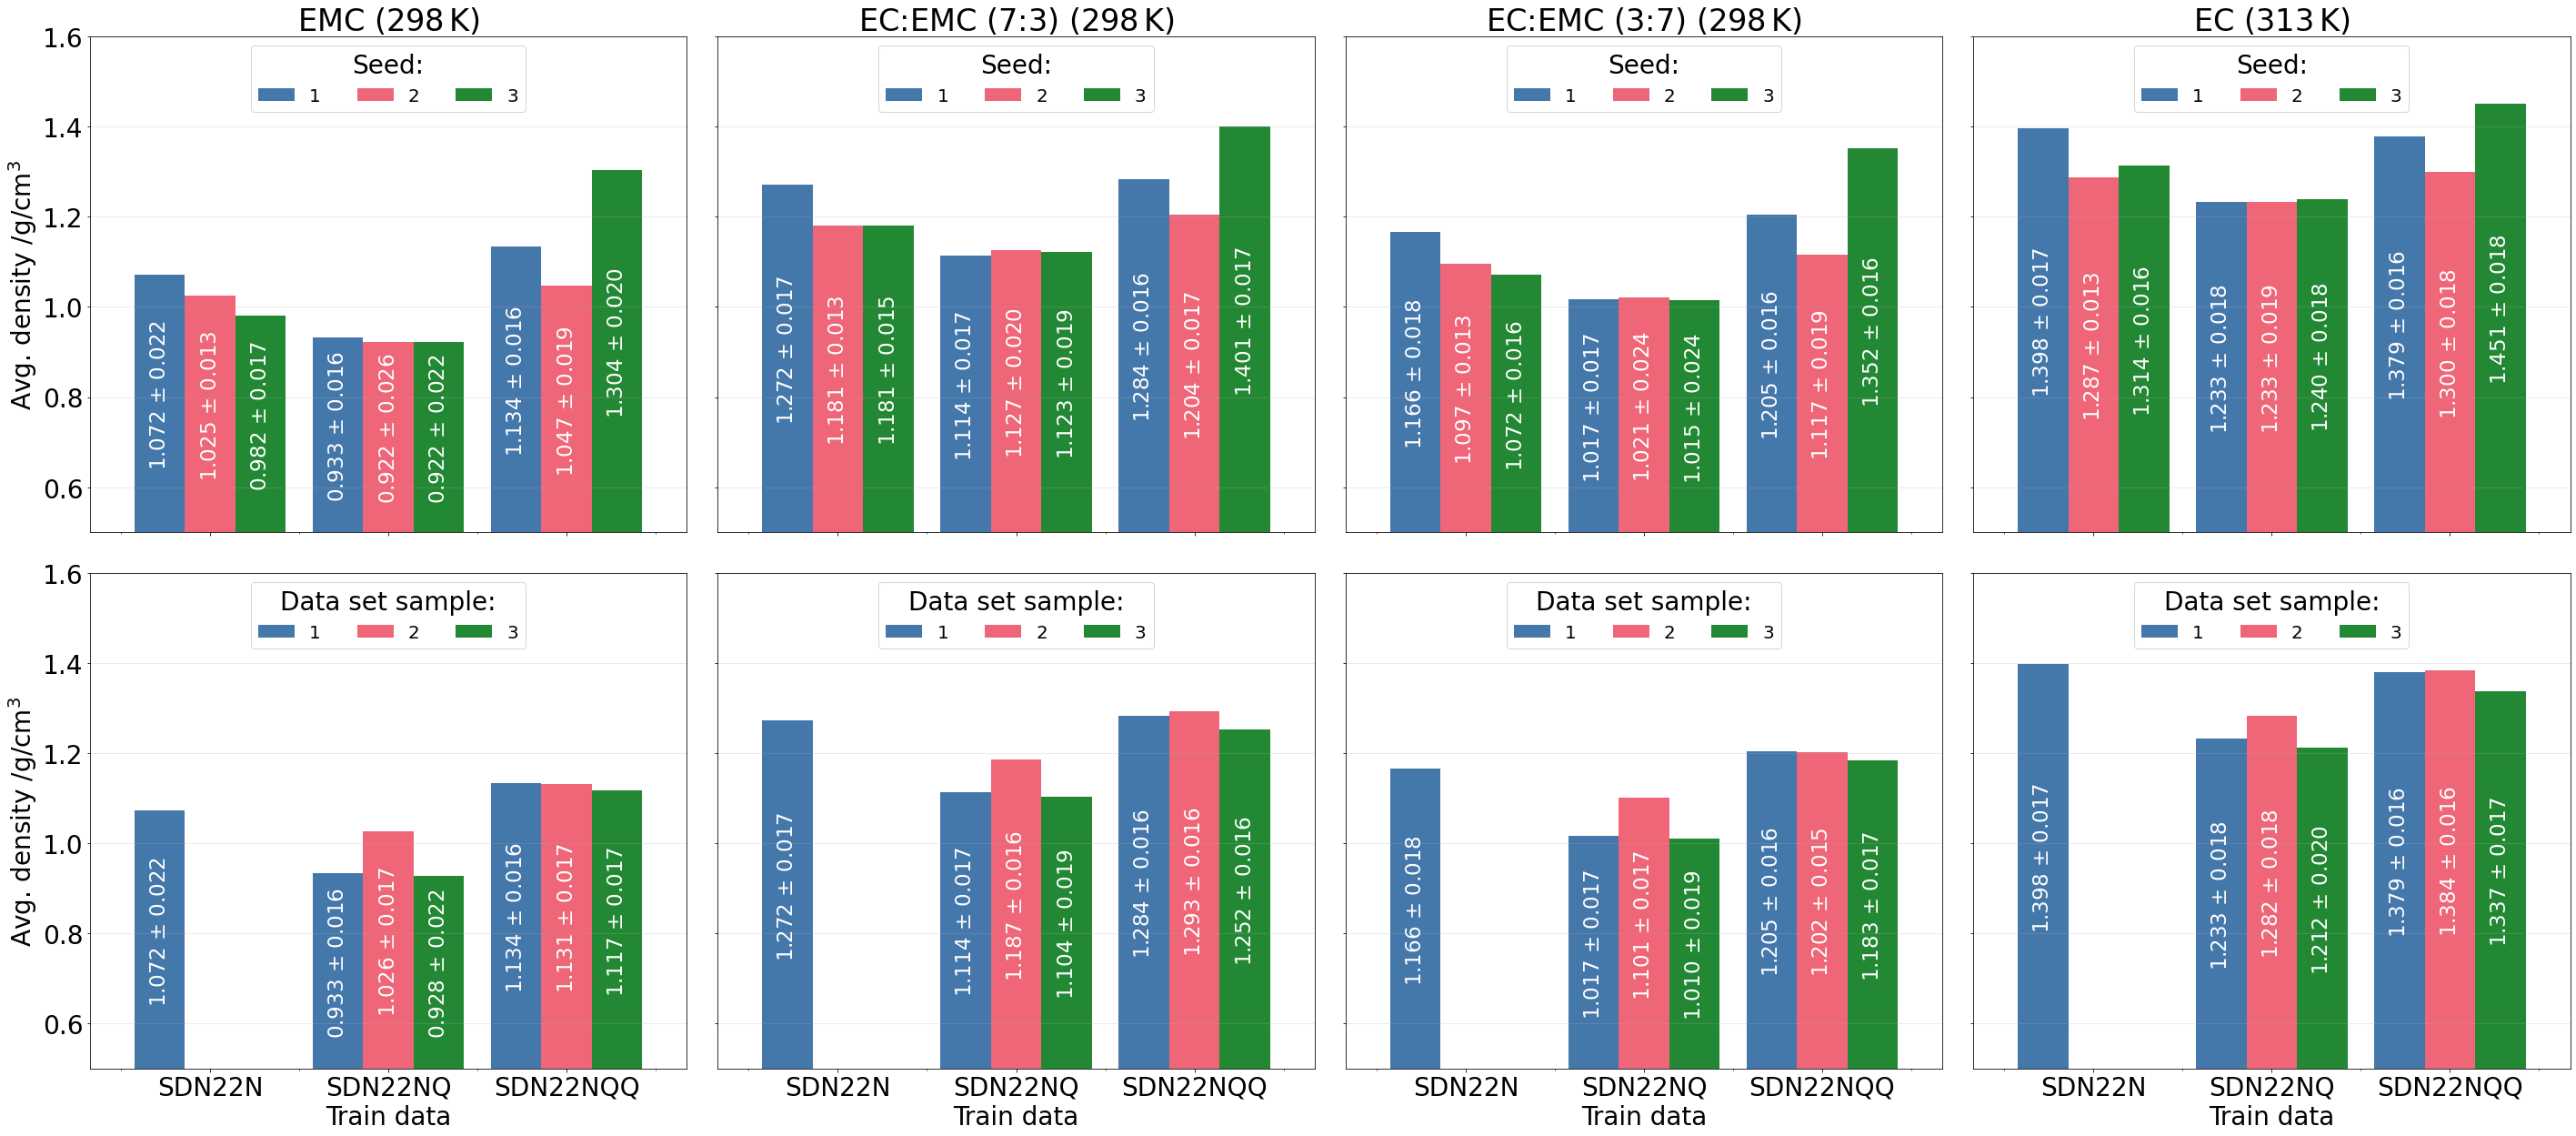

In [748]:
fsize = 28
plt.rcParams.update({'font.size': fsize})

fig, axs = plt.subplots(2,4, figsize=(10*4, 9*2), sharey='row', sharex='col')


seed_df = df[df['Sample'] == 1]
for ax, (n,g) in zip(axs[0,:], reversed(list(seed_df.groupby('Composition')))):
    avg_g = g.pivot(
        index='Train data',
        columns='Seed',
        values='Avg. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    std_g = g.pivot(
        index='Train data',
        columns='Seed',
        values='Std. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    a0 = avg_g.plot.bar(
        title=n,
        ylim=[0.5,1.6],
        ylabel=f'Avg. density /{dunit}',
        rot=0,
        width=0.85,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    ax.legend(title='Seed:', ncols=3, loc='upper center', fontsize=fsize-8)

    #for c in a0.containers:
    #    ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', fmt='%.3f', padding=10)
    for i, c in enumerate(a0.containers):
        col_name = avg_g.columns[i]
        dens_vals = avg_g[col_name]
        dens_errs = std_g[col_name]
        dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]
        ax.bar_label(c, rotation=90, fontsize=fsize-5, label_type='center', padding=10, labels=dens_labels, color='white')


sample_df = df[df['Seed'] == 1]
for ax, (n,g) in zip(axs[1,:], reversed(list(sample_df.groupby('Composition')))):
    avg_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Avg. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    std_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Std. density',
    )#.sort_index(axis=0,ascending=False)#[order]
    a1 = avg_g.plot.bar(
        ylim=[0.5,1.6],
        ylabel=f'Avg. density /{dunit}',
        #color=cset[3:],
        rot=0,
        width=0.85,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    ax.legend(title='Data set sample:', ncols=3, loc='upper center', fontsize=fsize-8)

    #for c in a1.containers:
    #    ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', fmt='%.3f', padding=10)
    for i, c in enumerate(a1.containers):
        col_name = avg_g.columns[i]
        dens_vals = avg_g[col_name]
        dens_errs = std_g[col_name]
        dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]
        ax.bar_label(c, rotation=90, fontsize=fsize-5, label_type='center', padding=10, labels=dens_labels, color='white')

plt.tight_layout()

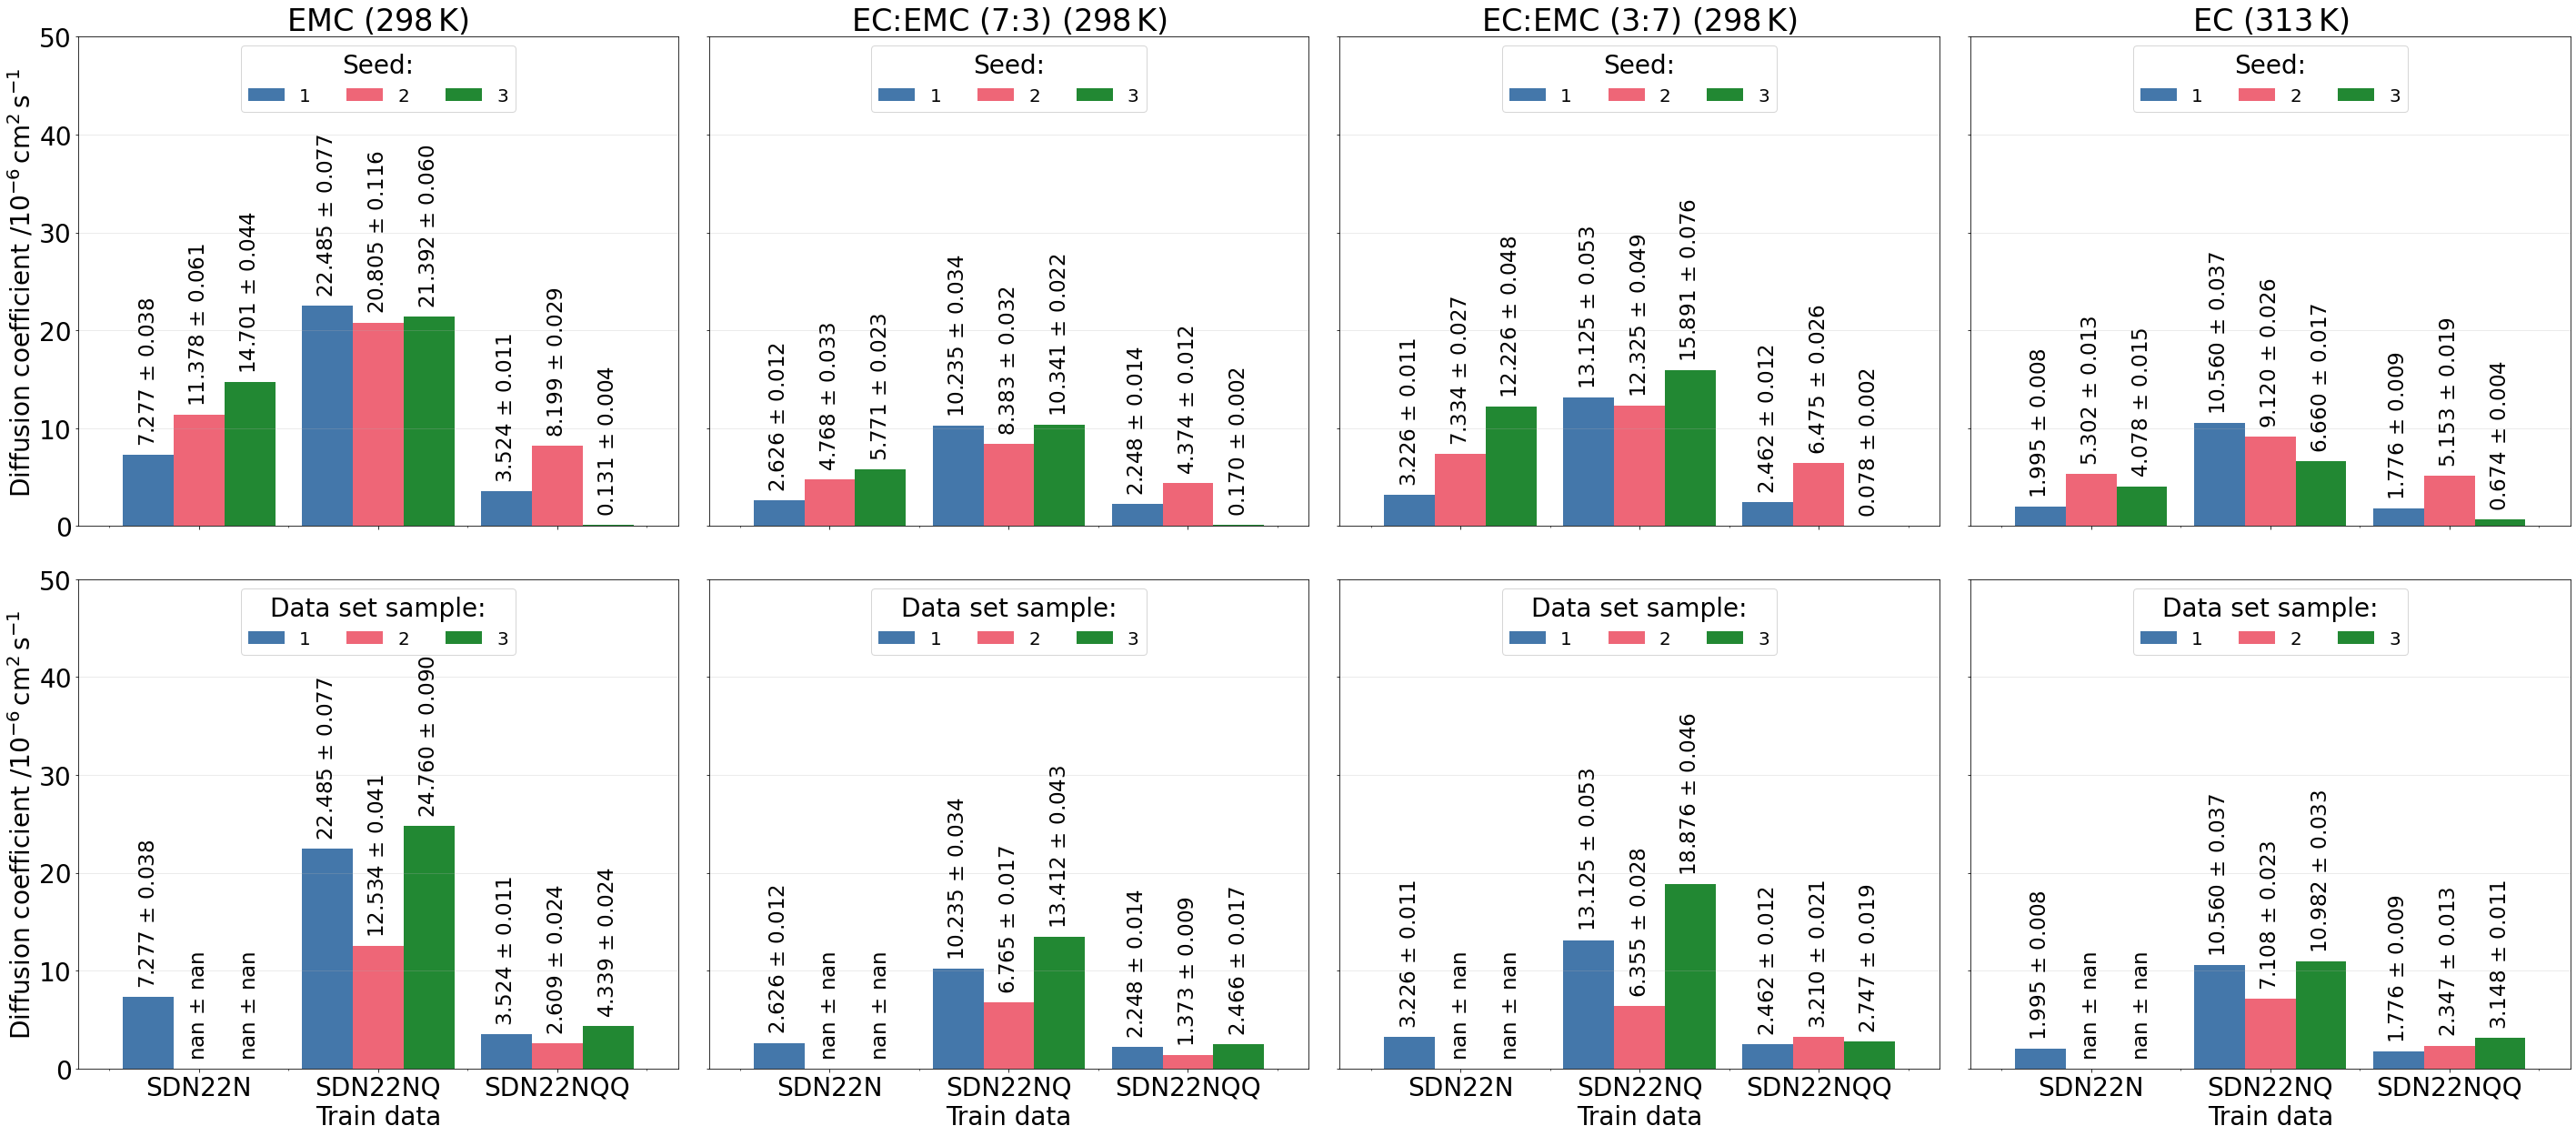

In [749]:
fsize = 28
plt.rcParams.update({'font.size': fsize})

fig, axs = plt.subplots(2,4, figsize=(10*4, 9*2), sharey='row', sharex='col')


seed_df = df[df['Sample'] == 1]
for ax, (n,g) in zip(axs[0,:], reversed(list(seed_df.groupby('Composition')))):
    D_g = g.pivot(
        index='Train data',
        columns='Seed',
        values='Diffusion coefficient',
    )#.sort_index(axis=0,ascending=False)#[order]
    err_g = g.pivot(
        index='Train data',
        columns='Seed',
        values='Diff. fit error',
    )#.sort_index(axis=0,ascending=False)#[order]
    a0 = D_g.plot.bar(
        title=n,
        ylim=[0,50],
        ylabel=f'Diffusion coefficient /$10^{{-6}}\\,\\text{{cm}}^2\\,\\text{{s}}^{{-1}}$',
        rot=0,
        width=0.85,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    ax.legend(title='Seed:', ncols=3, loc='upper center', fontsize=fsize-8)

    #for c in a0.containers:
    #    ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', fmt='%.3f', padding=10)
    for i, c in enumerate(a0.containers):
        col_name = D_g.columns[i]
        diff_vals = D_g[col_name]
        diff_erros = err_g[col_name]
        diff_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(diff_vals, diff_erros)]
        ax.bar_label(c, rotation=90, fontsize=fsize-5, label_type='edge', padding=10, labels=diff_labels, color='black')

sample_df = df[df['Seed'] == 1]
for ax, (n,g) in zip(axs[1,:], reversed(list(sample_df.groupby('Composition')))):
    D_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Diffusion coefficient',
    )#.sort_index(axis=0,ascending=False)#[order]
    err_g = g.pivot(
        index='Train data',
        columns='Sample',
        values='Diff. fit error',
    )#.sort_index(axis=0,ascending=False)#[order]
    a1 = D_g.plot.bar(
        ylim=[0,50],
        ylabel=f'Diffusion coefficient /$10^{{-6}}\\,\\text{{cm}}^2\\,\\text{{s}}^{{-1}}$',
        #color=cset[3:],
        rot=0,
        width=0.85,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)
    ax.legend(title='Data set sample:', ncols=3, loc='upper center', fontsize=fsize-8)

    #for c in a1.containers:
    #    ax.bar_label(c, rotation=90, fontsize=fsize-12, label_type='edge', fmt='%.3f', padding=10)
    for i, c in enumerate(a1.containers):
        col_name = D_g.columns[i]
        diff_vals = D_g[col_name]
        diff_erros = err_g[col_name]
        diff_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(diff_vals, diff_erros)]
        ax.bar_label(c, rotation=90, fontsize=fsize-5, label_type='edge', padding=10, labels=diff_labels, color='black')

plt.tight_layout()

## Checking differences between functionals
Here we compare, for each data set (using the same seed in all cases) the effect the labels has on the output.

In [323]:
B97_tags = [
    'SDN22NQQ/B97/SEED1/DSET1',
    'SDN22NQQ/B97/SEED1/DSET2',
    'SDN22NQQ/B97/SEED1/DSET3',
] # These tags needs to be adjusted to be compliant with zenodo

wB97_tags = [
    'SDN22NQQ/wB97X/SEED1/DSET1',
    'SDN22NQQ/wB97X/SEED1/DSET2',
    'SDN22NQQ/wB97X/SEED1/DSET3',
] # These tags needs to be adjusted to be compliant with zenodo

In [324]:
# Obtain data and store to dicts
B97_xyz = dict()
wB97_xyz = dict()
for tag1, tag2 in zip(B97_tags, wB97_tags):
    B97_xyz[tag1] = get_xyz(f'{static_path}{tag1}/train_data/*') # Argument should be 'tag' to be consistent with zenodo
    wB97_xyz[tag2] = get_xyz(f'{static_path}{tag2}/train_data/*') # Argument should be 'tag' to be consistent with zenodo

SDN22NQQ B97 DSET1 SEED1 SDN22NQQ wB97X DSET1 SEED1
Atoms(symbols='COCOCOH2CO3C3H8', pbc=False, REF_forces=...) 23
Atoms(symbols='CO3C2H6CO3C2H6CO3C2H6CO3C2H6', pbc=False, forces=..., molID=..., calculator=SinglePointCalculator(...)) 48
SDN22NQQ B97 DSET2 SEED1 SDN22NQQ wB97X DSET2 SEED1
Atoms(symbols='CO3C2H6CO3C3H8COCOC2HOH5CO3C2H6', pbc=False, REF_forces=...) 52
Atoms(symbols='COCOCH2OH2CO3C2H6COCOCH2OH2', pbc=False, REF_forces=..., molID=...) 32
SDN22NQQ B97 DSET3 SEED1 SDN22NQQ wB97X DSET3 SEED1
Atoms(symbols='COCOCOH2CO3C3H8', pbc=False, REF_forces=...) 23
Atoms(symbols='COCOCH2OH2COCOCH2OH2COCOCH2OH2COCOCH2OH2', pbc=False, REF_forces=..., molID=...) 40


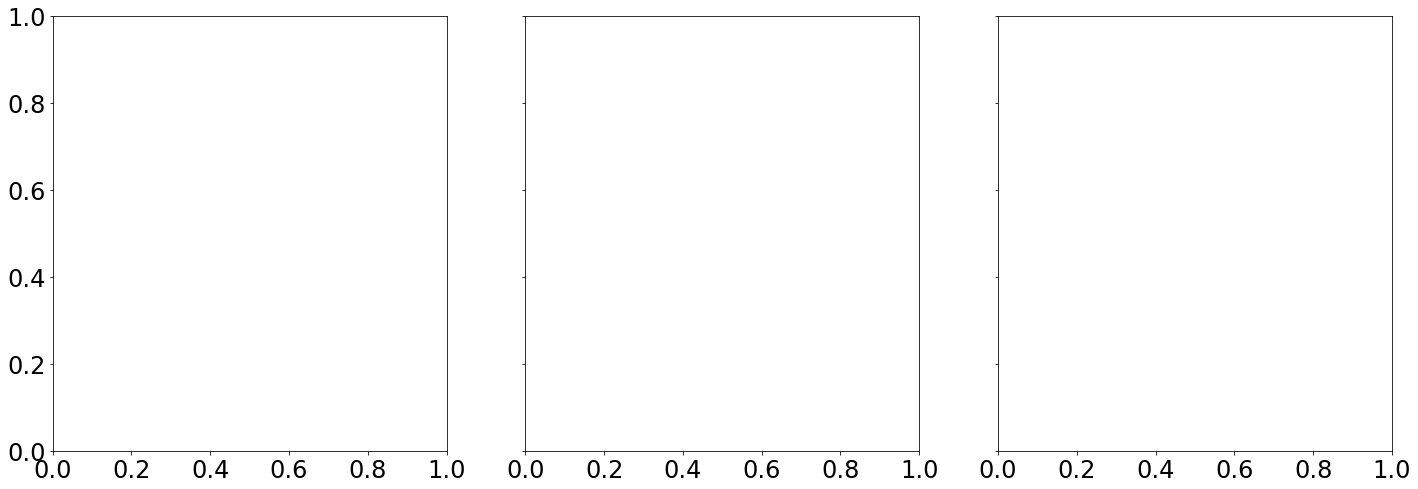

In [334]:
fsize = 24
plt.rcParams.update({'font.size': fsize})

fig, axs = plt.subplots(1,len(B97_tags), figsize=(8*len(B97_tags), 8*1), sharex=True, sharey=True)
for i, (tag1,tag2) in enumerate(zip(B97_xyz, wB97_xyz)):
    atoms1 = B97_xyz[tag1]
    atoms2 = wB97_xyz[tag2]
    data_set1, functional1, seed1, dset_sample1 = tag1.split('/')
    data_set2, functional2, seed2, dset_sample2 = tag2.split('/')


    IDx = 3
    print(data_set1, functional1,dset_sample1,seed1, data_set2,functional2,dset_sample2,seed2)
    print(atoms1[IDx], len(atoms1[IDx]))
    print(atoms2[IDx], len(atoms2[IDx]))
    
    """
    # Obtain forces and errors
    B97_forces = [a.arrays['forces'] for a in atoms1 if 'forces' in a.arrays.keys()]
    print(B97_forces[0])
    B97_forces = np.concatenate(B97_forces).flatten()

    wB97_forces = [a.arrays['forces'] for a in atoms2 if 'forces' in a.arrays.keys()]
    print(wB97_forces[0])
    wB97_forces = np.concatenate(wB97_forces).flatten()
    rmse, rrmse = RMSE(wB97_forces, B97_forces)


    # Plot correlations
    axs[0,i].set_title(f'Training data: {data_set1}')
    axs[0,i].plot(wB97_forces, B97_forces, '.', label=f'RMSE:    {rmse*1e3:.3f}$\\,$meV$\,$Å$^{{-1}}$\nRRMSE:    {rrmse*100:.3f}%', alpha=0.3)
    axs[0,i].legend(loc='upper left', numpoints=1, fontsize=fsize, handlelength=1)

    # Plot settings
    axs[0,i].plot([0, 1], [0, 1], 'k--', transform=axs[0,i].transAxes, alpha=0.3)
    axs[0,i].set_xlim([-60,60])
    axs[0,i].set_ylim([-60,60])
    if i == 0: axs[0,i].set_ylabel('B97 forces /eV$\,$Å$^{-1}$')

    axs[1,i].set_xlabel('wB97 forces /eV$\,$Å$^{-1}$')
    """

In [177]:
recomp_tags = [
    'SDN22NQQ/B97/SEED1/DSET1',
    'SDN22NQQ/B97/SEED1/DSET2',
    'SDN22NQQ/B97/SEED1/DSET3',
    #'SDN22NQQ/B97/SEED2/DSET1', missing
    #'SDN22NQQ/B97/SEED3/DSET1', missing
    'SDN22NQ/B97/SEED1/DSET1',
    'SDN22NQ/B97/SEED1/DSET2',
    'SDN22NQ/B97/SEED1/DSET3',
    #'SDN22NQ/B97/SEED2/DSET1', missing
    #'SDN22NQ/B97/SEED3/DSET1', missing
] # These tags needs to be adjusted to be compliant with zenodo

recomp_thermo = dict()
for tag in recomp_tags:
    recomp_thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*') # Argument should be 'tag' to be consistent with zenodo

In [185]:
diff_coeffs = []
diff_errs = []
log_r2 = []
diff_r2 = []
diff_starts = []
for i, k in enumerate(recomp_thermo):
    tag = recomp_tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(recomp_thermo[k].items()):

        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']
        
        #idx, r2 = get_start_index(time,msd,threshold=1e-2, min_steps=5e3)
        idx, r2 = get_start_index(time,msd,threshold=5e-2, window=2000, start_id=5000)
        if idx != None:   
            D, err, R2 = diffusion_coefficient(time[idx:],msd[idx:])
            diff_coeffs.append(D)
            diff_errs.append(err)
            log_r2.append(r2)
            diff_r2.append(R2)
            print(idx, len(time), r2, D, err, R2)
            diff_starts.append(idx)
        else:
            diff_coeffs.append(np.nan)
            diff_errs.append(np.nan)
            log_r2.append(np.nan)
            diff_r2.append(np.nan)
            diff_starts.append(np.nan)

Using slope error thresold of: 0.05
7782 99998 0.8985734111303151 3.416142027367656e-10 1.4290416766935248e-12 0.9884663539009545
Using slope error thresold of: 0.05
11517 99998 0.9072014815512656 3.0877041205953965e-10 1.961133826177624e-12 0.9748402568884994
Using slope error thresold of: 0.05
8141 99998 0.9798540980314439 3.566624693306686e-10 1.290253714419163e-12 0.991382735238051
Using slope error thresold of: 0.05
11443 99998 0.9347154047585767 5.704464150124369e-10 2.136707654714053e-12 0.9910963292271198
Using slope error thresold of: 0.05
8194 99999 0.9308315096154741 8.929896311655329e-10 1.9390161044192432e-12 0.9968799639924074
Using slope error thresold of: 0.05
8470 99999 0.8518040360816848 1.1352189082259007e-09 2.871558467253812e-12 0.995783229542228
Using slope error thresold of: 0.05
7001 99999 0.9873261223491527 7.914097506382398e-10 1.897510195875198e-12 0.9961492604917306
Using slope error thresold of: 0.05
8279 99999 0.8416015781799043 1.1519477759417065e-09 5.31

In [186]:
cf, dunit = get_density(recomp_tags, dynamics_path, std=True)
cf['Diffusion coefficient'] = [d*1e10 for d in diff_coeffs] # 1e-6 cm2/s
cf['Diff. fit error'] = [e*1e10 for e in diff_errs]
cf['log-log r2'] = log_r2
cf['Diff. r2'] = diff_r2
cf['Diff. start time /ns'] = [time[s]*1e-6 if type(s) == int else np.nan for s in diff_starts]
cf.style.map(rvalue_formatting, subset=['log-log r2', 'Diff. r2'])

{'SDN22NQQ/B97/SEED1/DSET1': {'npt_000conEC_298K': 1.0972758779375589, 'npt_033conEC_298K': 1.1341481305426107, 'npt_066conEC_298K': 1.1813750304106083, 'npt_100conEC_313K': 1.2382209655993122}, 'SDN22NQQ/B97/SEED1/DSET2': {'npt_000conEC_298K': 1.0142275806258063, 'npt_033conEC_298K': 1.0550833923639236, 'npt_066conEC_298K': 1.1135255122151222, 'npt_100conEC_313K': 1.1706012561625614}, 'SDN22NQQ/B97/SEED1/DSET3': {'npt_000conEC_298K': 0.9633286659466596, 'npt_033conEC_298K': 1.0236501543615435, 'npt_066conEC_298K': 1.088814447274473, 'npt_100conEC_313K': 1.1593070867208672}, 'SDN22NQ/B97/SEED1/DSET1': {'npt_000conEC_298K': 1.040878980399412, 'npt_033conEC_298K': 1.1129425156551567, 'npt_066conEC_298K': 1.194697342603426, 'npt_100conEC_313K': 1.2804432001340025}, 'SDN22NQ/B97/SEED1/DSET2': {'npt_000conEC_298K': 0.8452666793367932, 'npt_033conEC_298K': 0.9194072432824328, 'npt_066conEC_298K': 1.0085624202442025, 'npt_100conEC_313K': 1.1141606496464966}, 'SDN22NQ/B97/SEED1/DSET3': {'npt_0

,Train data,Functional,Seed,Sample,Composition,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,log-log r2,Diff. r2,Diff. start time /ns
0,SDN22NQQ,B97,1,1,"EMC (298$\,$K)",1.097276,0.015692,3.416142,0.014290,0.898573,0.988466,0.077820
1,SDN22NQQ,B97,1,1,"EC:EMC (3:7) (298$\,$K)",1.134148,0.015030,3.087704,0.019611,0.907201,0.974840,0.115170
2,SDN22NQQ,B97,1,1,"EC:EMC (7:3) (298$\,$K)",1.181375,0.016095,3.566625,0.012903,0.979854,0.991383,0.081410
3,SDN22NQQ,B97,1,1,"EC (313$\,$K)",1.238221,0.015759,5.704464,0.021367,0.934715,0.991096,0.114430
4,SDN22NQQ,B97,1,2,"EMC (298$\,$K)",1.014228,0.016647,8.929896,0.019390,0.930832,0.996880,0.081940
5,SDN22NQQ,B97,1,2,"EC:EMC (3:7) (298$\,$K)",1.055083,0.017535,11.352189,0.028716,0.851804,0.995783,0.084700
6,SDN22NQQ,B97,1,2,"EC:EMC (7:3) (298$\,$K)",1.113526,0.018982,7.914098,0.018975,0.987326,0.996149,0.070010
7,SDN22NQQ,B97,1,2,"EC (313$\,$K)",1.170601,0.019168,11.519478,0.053121,0.841602,0.986093,0.082790
8,SDN22NQQ,B97,1,3,"EMC (298$\,$K)",0.963329,0.021163,16.495628,0.050701,0.928017,0.993725,0.075560
9,SDN22NQQ,B97,1,3,"EC:EMC (3:7) (298$\,$K)",1.023650,0.021914,10.566219,0.038221,0.965637,0.991278,0.070010


In [187]:
data_mask = df['Train data'] != 'SDN22N'
seed_mask = df['Seed'] == 1

wB97_df = df[data_mask & seed_mask]

comps = [
    'EMC (298$\,$K)',
    #'EC:EMC (3:7) (298$\,$K)', 
    #'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

ef = pd.concat([cf, wB97_df])#.reset_index()
#EMC_mask = ef['Composition'] == comps[0]
#EC_mask = ef['Composition'] == comps[-1]
#ef = ef[EC_mask | EMC_mask]
ef

,Train data,Functional,Seed,Sample,Composition,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,log-log r2,Diff. r2,Diff. start time /ns
0,SDN22NQQ,B97,1,1,"EMC (298$\,$K)",1.097276,0.015692,3.416142,0.014290,0.898573,0.988466,0.07782
1,SDN22NQQ,B97,1,1,"EC:EMC (3:7) (298$\,$K)",1.134148,0.015030,3.087704,0.019611,0.907201,0.974840,0.11517
2,SDN22NQQ,B97,1,1,"EC:EMC (7:3) (298$\,$K)",1.181375,0.016095,3.566625,0.012903,0.979854,0.991383,0.08141
3,SDN22NQQ,B97,1,1,"EC (313$\,$K)",1.238221,0.015759,5.704464,0.021367,0.934715,0.991096,0.11443
4,SDN22NQQ,B97,1,2,"EMC (298$\,$K)",1.014228,0.016647,8.929896,0.019390,0.930832,0.996880,0.08194
5,SDN22NQQ,B97,1,2,"EC:EMC (3:7) (298$\,$K)",1.055083,0.017535,11.352189,0.028716,0.851804,0.995783,0.08470
6,SDN22NQQ,B97,1,2,"EC:EMC (7:3) (298$\,$K)",1.113526,0.018982,7.914098,0.018975,0.987326,0.996149,0.07001
7,SDN22NQQ,B97,1,2,"EC (313$\,$K)",1.170601,0.019168,11.519478,0.053121,0.841602,0.986093,0.08279
8,SDN22NQQ,B97,1,3,"EMC (298$\,$K)",0.963329,0.021163,16.495628,0.050701,0.928017,0.993725,0.07556
9,SDN22NQQ,B97,1,3,"EC:EMC (3:7) (298$\,$K)",1.023650,0.021914,10.566219,0.038221,0.965637,0.991278,0.07001


### SD22NQQ
#### Density

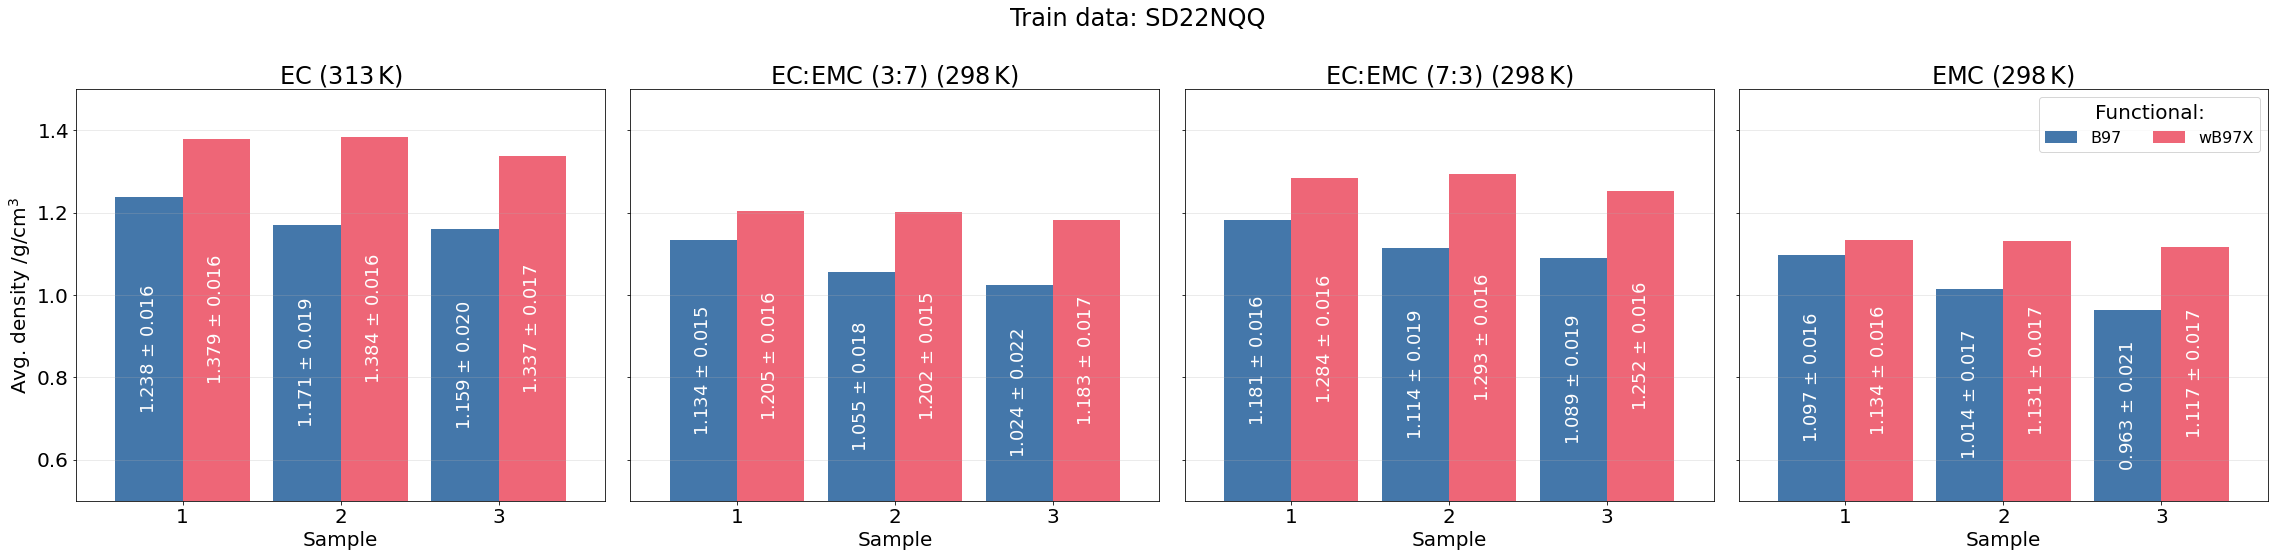

In [188]:
fsize = 20
plt.rcParams.update({'font.size': fsize})



fig, axs = plt.subplots(1,4, figsize=(8*4, 8*1), sharey=True)

SD22NQQ_functional_comp = ef[ef['Train data'] == 'SDN22NQQ']

fig.suptitle('Train data: SD22NQQ')
#for ax, (n,g) in zip(axs, reversed(list(SD22NQQ_functional_comp.groupby('Composition')))):
for ax, (n,g) in zip(axs, SD22NQQ_functional_comp.groupby('Composition')):
    ax.set_title(n)
    avg_g = g.pivot(
        index='Sample',
        columns='Functional',
        values='Avg. density',
    ).sort_index(axis=0,ascending=True)#[order]
    std_g = g.pivot(
        index='Sample',
        columns='Functional',
        values='Std. density',
    ).sort_index(axis=0,ascending=True)#[order]
    a1 = avg_g.plot.bar(
        ylim=[0.5,1.5],
        ylabel=f'Avg. density /{dunit}',
        color=cset,
        rot=0,
        width=0.85,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)

    for i, c in enumerate(a1.containers):
        col_name = avg_g.columns[i]
        dens_vals = avg_g[col_name]
        dens_errs = std_g[col_name]
        dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]
        ax.bar_label(c, rotation=90, fontsize=fsize-2, label_type='center', padding=0, labels=dens_labels, color='white')

axs[-1].legend(title='Functional:', ncols=3, loc='upper right', fontsize=fsize-4)
plt.tight_layout()

#### Diffusivity

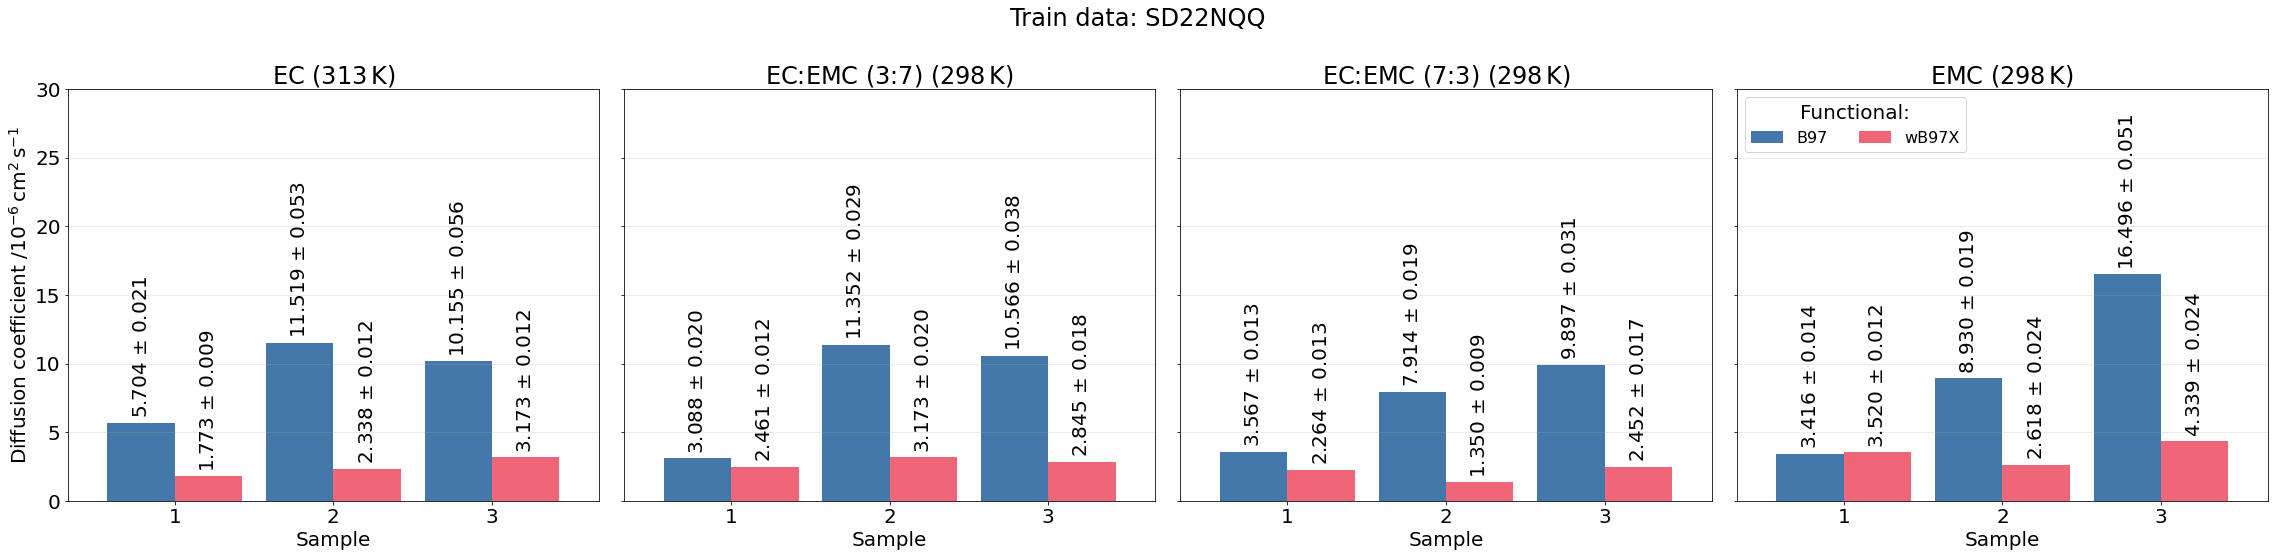

In [189]:
fsize = 20
plt.rcParams.update({'font.size': fsize})



fig, axs = plt.subplots(1,4, figsize=(8*4, 8*1), sharey=True)

SD22NQQ_functional_comp = ef[ef['Train data'] == 'SDN22NQQ']

fig.suptitle('Train data: SD22NQQ')
#for ax, (n,g) in zip(axs, reversed(list(SD22NQQ_functional_comp.groupby('Composition')))):
for ax, (n,g) in zip(axs, SD22NQQ_functional_comp.groupby('Composition')):
    D_g = g.pivot(
        index='Sample',
        columns='Functional',
        values='Diffusion coefficient',
    ).sort_index(axis=0,ascending=True)#[order]
    err_g = g.pivot(
        index='Sample',
        columns='Functional',
        values='Diff. fit error',
    ).sort_index(axis=0,ascending=True)#[order]
    a0 = D_g.plot.bar(
        title=n,
        ylim=[0,30],
        ylabel=f'Diffusion coefficient /$10^{{-6}}\\,\\text{{cm}}^2\\,\\text{{s}}^{{-1}}$',
        rot=0,
        width=0.85,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)

    for i, c in enumerate(a0.containers):
        col_name = D_g.columns[i]
        diff_vals = D_g[col_name]
        diff_erros = err_g[col_name]
        diff_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(diff_vals, diff_erros)]
        ax.bar_label(c, rotation=90, fontsize=fsize, label_type='edge', padding=5, labels=diff_labels, color='black')

axs[-1].legend(title='Functional:', ncols=3, loc='upper left', fontsize=fsize-4)
plt.tight_layout()

### SD22NQ
#### Density

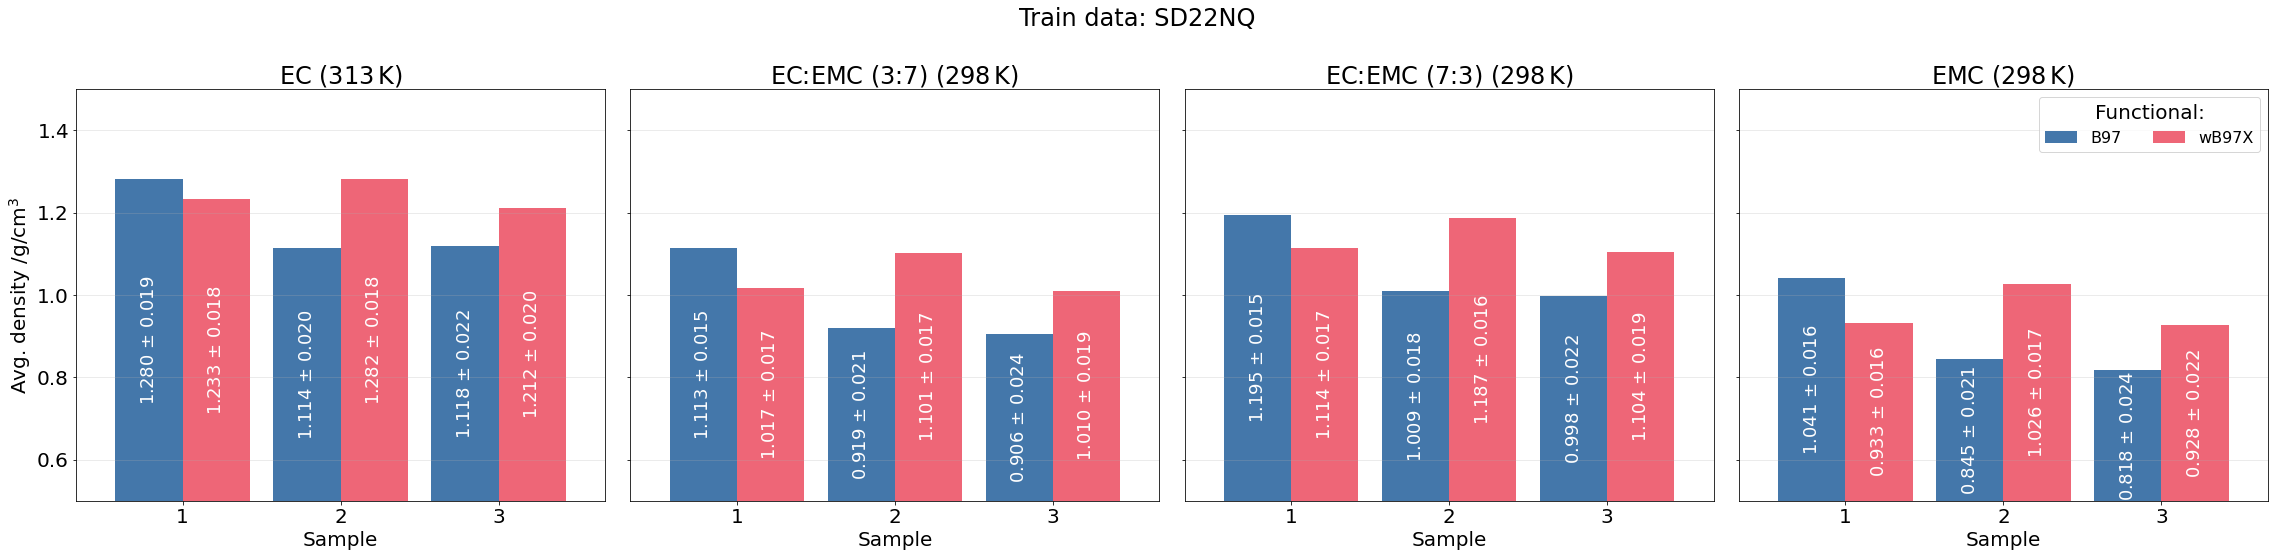

In [190]:
fsize = 20
plt.rcParams.update({'font.size': fsize})



fig, axs = plt.subplots(1,4, figsize=(8*4, 8*1), sharey=True)

SD22NQ_functional_comp = ef[ef['Train data'] == 'SDN22NQ']

fig.suptitle('Train data: SD22NQ')
#for ax, (n,g) in zip(axs, reversed(list(SD22NQ_functional_comp.groupby('Composition')))):
for ax, (n,g) in zip(axs, SD22NQ_functional_comp.groupby('Composition')):
    ax.set_title(n)
    avg_g = g.pivot(
        index='Sample',
        columns='Functional',
        values='Avg. density',
    ).sort_index(axis=0,ascending=True)#[order]
    std_g = g.pivot(
        index='Sample',
        columns='Functional',
        values='Std. density',
    ).sort_index(axis=0,ascending=True)#[order]
    a1 = avg_g.plot.bar(
        ylim=[0.5,1.5],
        ylabel=f'Avg. density /{dunit}',
        color=cset,
        rot=0,
        width=0.85,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)

    for i, c in enumerate(a1.containers):
        col_name = avg_g.columns[i]
        dens_vals = avg_g[col_name]
        dens_errs = std_g[col_name]
        dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]
        ax.bar_label(c, rotation=90, fontsize=fsize-2, label_type='center', padding=0, labels=dens_labels, color='white')

axs[-1].legend(title='Functional:', ncols=3, loc='upper right', fontsize=fsize-4)
plt.tight_layout()

#### Diffusivity

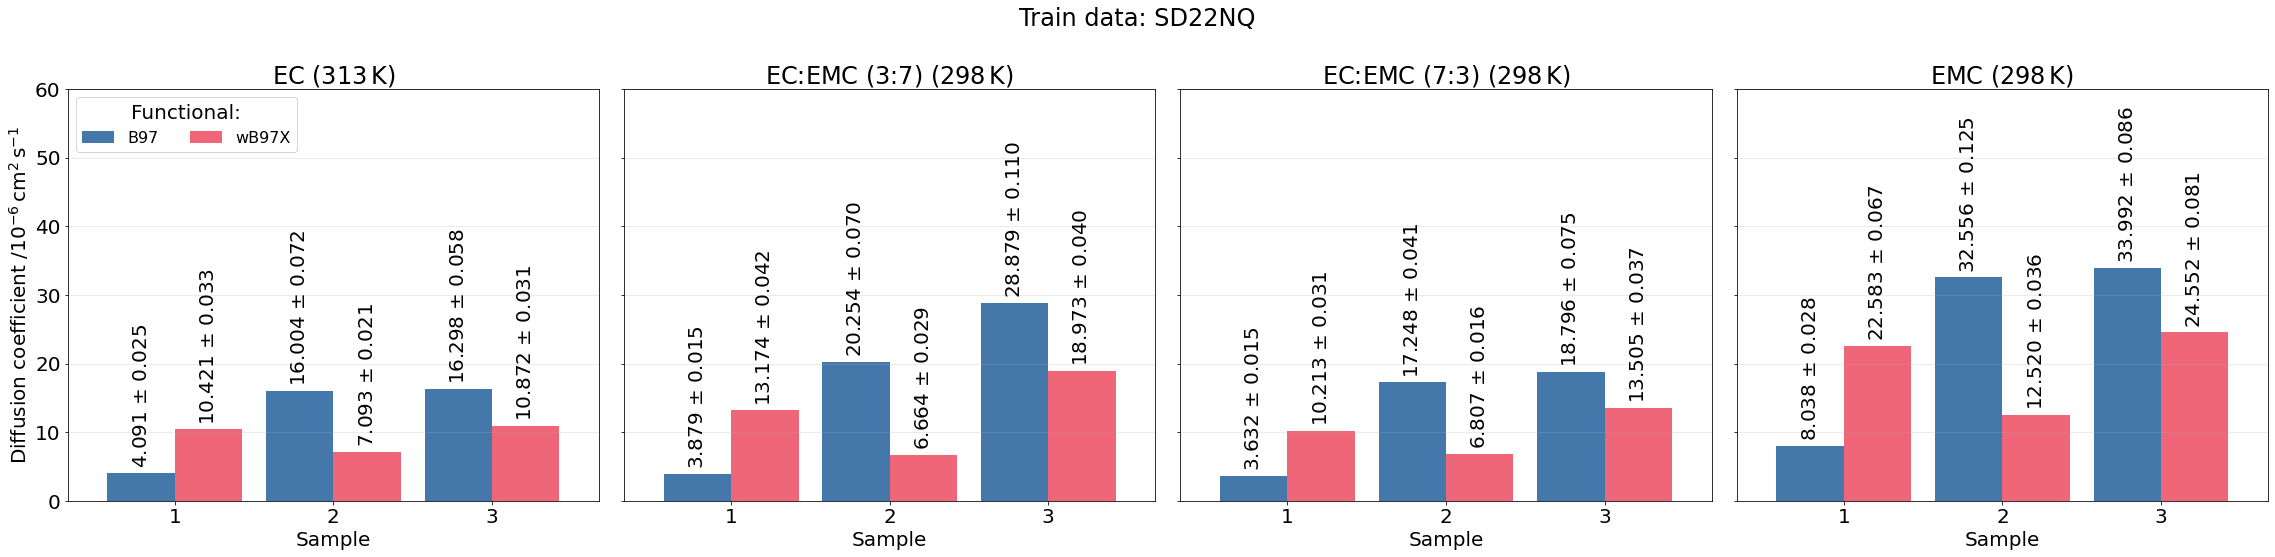

In [191]:
fsize = 20
plt.rcParams.update({'font.size': fsize})



fig, axs = plt.subplots(1,4, figsize=(8*4, 8*1), sharey=True)

SD22NQ_functional_comp = ef[ef['Train data'] == 'SDN22NQ']

fig.suptitle('Train data: SD22NQ')
#for ax, (n,g) in zip(axs, reversed(list(SD22NQ_functional_comp.groupby('Composition')))):
for ax, (n,g) in zip(axs, SD22NQ_functional_comp.groupby('Composition')):
    D_g = g.pivot(
        index='Sample',
        columns='Functional',
        values='Diffusion coefficient',
    ).sort_index(axis=0,ascending=True)#[order]
    err_g = g.pivot(
        index='Sample',
        columns='Functional',
        values='Diff. fit error',
    ).sort_index(axis=0,ascending=True)#[order]
    a0 = D_g.plot.bar(
        title=n,
        ylim=[0,60],
        ylabel=f'Diffusion coefficient /$10^{{-6}}\\,\\text{{cm}}^2\\,\\text{{s}}^{{-1}}$',
        rot=0,
        width=0.85,
        legend=False,
        ax=ax,
    )
    ax.grid(axis='y', alpha=0.3)

    for i, c in enumerate(a0.containers):
        col_name = D_g.columns[i]
        diff_vals = D_g[col_name]
        diff_erros = err_g[col_name]
        diff_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(diff_vals, diff_erros)]
        ax.bar_label(c, rotation=90, fontsize=fsize, label_type='edge', padding=5, labels=diff_labels, color='black')

axs[0].legend(title='Functional:', ncols=3, loc='upper left', fontsize=fsize-4)
plt.tight_layout()